<a href="https://colab.research.google.com/github/shreevigneshs/UCSC-243/blob/main/assignments/243_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install scikit-multilearn

In [2]:
# !pip install pandarallel

In [3]:
# !wget http://vectors.nlpl.eu/repository/20/6.zip

In [4]:
# !unzip '/content/drive/MyDrive/NLP243/assignments/2/6.zip' -d wikipedia

In [5]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.8 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=8adbdc158a5767970b27dc7e765604a931b1c9e260717aa683476f1a20942d65
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [6]:
from typing import List
import re
import string
import math
import os

import torch
import torchtext
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from collections import Counter
from itertools import chain

# from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import spacy

from sklearn.model_selection import train_test_split
# import skmultilearn
from nltk.tokenize import word_tokenize
# from pandarallel import pandarallel
import pickle as pkl
from argparse import Namespace
import matplotlib.ticker as plticker

import gensim
from gensim.test.utils import datapath

In [7]:
# Load embeddings into Gensim class containing matrix
word2vec_weights = gensim.models.KeyedVectors.load_word2vec_format("/content/drive/MyDrive/NLP243/assignments/2/gensim_wiki_word2vec/wikipedia/model.txt")

In [8]:
# df = pd.read_csv("/content/drive/MyDrive/NLP243/assignments/2/hw2_train.csv")
# df["split"] = "train"
# df.columns = ["id", "text", "bio", "split"]
# df.bio = df.bio.replace(np.nan, "none", regex=True)

In [9]:
# df.head()

In [10]:
# np.random.seed(20221018)
# train_proportion = 0.90
# val_proportion = 0.10

In [11]:
# item_list = list(row.to_dict() for _, row in df.iterrows())
# print(len(item_list))
# np.random.shuffle(item_list)
# clean_item_list = [item for item in item_list if len(item['text'].split(' ')) == len(item['bio'].split(' '))]
# print(len(clean_item_list))

In [12]:
# item_list = clean_item_list

In [13]:
# # Create split data
# final_list = []

# n_total = len(item_list)
# n_train = int(train_proportion * n_total)
# n_val = int(val_proportion * n_total)

# # Give data point a split attribute
# for item in item_list[:n_train]:
#   item['split'] = 'train'
    
# for item in item_list[n_train:n_train+n_val+1]:
#   item['split'] = 'val'

# # Add to final list
# final_list.extend(item_list)

# final_df = pd.DataFrame(final_list)

In [14]:
# # don't apply this as you will remove tokens from text but not label
# def preprocess_text(text):
#   text = text.lower()
#   text = re.sub(r"([.,!?])", r" \1 ", text)
#   text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
#   return text

# final_df.text = final_df.text.apply(preprocess_text)

In [15]:
# final_df.head()

In [16]:
# final_df.to_csv("/content/drive/MyDrive/NLP243/assignments/2/clean_hw2_train_20221020.csv", index=False)

In [17]:
df = pd.read_csv("/content/drive/MyDrive/NLP243/assignments/2/clean_hw2_train_20221020.csv")

In [18]:
df.head()

,id,text,bio,split
0,1604,a showing of movies that are in spanish,O O O O O O O B_language,train
1,1824,find movies of yash chopra,O O O B_director I_director,train
2,1918,what movies made the most money,O O O O O O,train
3,961,show me movies about time travel,O O O O B_subject I_subject,train
4,1888,i would like to watch an alfred hitchcock movie,O O O O O O B_director I_director O,train


In [70]:
# train_data = [(_text, _tag) for _text, _tag in zip(df.text[df.split == 'train'] , df.bio[df.split == 'train'])]
train_data = [(_text, _tag) for _text, _tag in zip(df.text , df.bio)]
val_data = [(_text, _tag) for _text, _tag in zip(df.text[df.split == 'val'] , df.bio[df.split == 'val'])]

In [71]:
class W2VSequencer(object):
    def __init__(self, gensim_w2v):
        # It uses the vocabulary of words from the word embeddings we use

        self.nlp = spacy.load("en_core_web_sm")
        self.w2v = gensim_w2v
        self.w2v.add(['<s>'], [np.random.uniform(low=-1, high=1.0, size=(300,))])
        self.w2v.add(['</s>'], [np.random.uniform(low=-1, high=1.0, size=(300,))])
        self.w2v.add(['<pad>'], [np.random.uniform(low=-1, high=1.0, size=(300,))])
        self.w2v.add(['<unk>'], [np.random.uniform(low=-1, high=1.0, size=(300,))])

        self.bos = self.w2v.vocab.get('<s>')
        self.eos = self.w2v.vocab.get('</s>')
        self.pad = self.w2v.vocab.get('<pad>')
        self.unk = self.w2v.vocab.get('<unk>')

        self.bos_index = self.bos.index
        self.eos_index = self.eos.index
        self.pad_index = self.pad.index
        self.unk_index = self.unk.index

        # self.tokenizer = lambda text: [t.text for t in self.nlp(text)]
        self.tokenizer = lambda text: [t for t in text.split(' ')]

    def encode(self, text):
        # Input will look like:
        # [<s>, w1, w2, ..., wn, </s>]
        
        # sequence = [self.bos_index]
        sequence = []

        tokens = self.tokenizer(text)
        for token in tokens:

            index = self.w2v.vocab.get(token, self.unk).index
            sequence.append(index)

        # sequence.append(self.eos_index)

        return sequence

    def create_padded_tensor(self, sequences):
        # Given a list of sequences, pad all to the same length

        lengths = [len(sequence) for sequence in sequences]
        max_seq_len = max(lengths)
        tensor = torch.full((len(sequences), max_seq_len), self.pad_index, dtype=torch.long)

        for i, sequence in enumerate(sequences):
            for j, token in enumerate(sequence):
                tensor[i][j] = token
        
        return tensor, lengths


class Sequencer(object):
    def __init__(self, corpus, bos_token='<s>', eos_token='</s>', unk_token='<unk>', pad_token='<pad>'):
        self.word2idx = {}
        self.idx2word = {}

        self.unk_index = self.add_token(unk_token) 
        self.pad_index = self.add_token(pad_token)
        self.bos_index = self.add_token(bos_token)
        self.eos_index = self.add_token(eos_token)
        self.nlp = spacy.load("en_core_web_sm")
        self.tokenizer = lambda text: [t.text for t in self.nlp(text)]

        for _corpora in corpus:
          for _token in self.tokenizer(_corpora):
            self.add_token(_token)

    def add_token(self, token):

        self.word2idx[token] = new_index = len(self.word2idx)
        self.idx2word[new_index] = token

        return new_index

    def encode(self, text):
        # Input will look like:
        # [<s>, w1, w2, ..., wn, </s>]
        tokens = self.tokenizer(text)

        # sequence = [self.bos_index]
        sequence = []

        for token in tokens:

            index = self.word2idx.get(token, self.unk_index)
            sequence.append(index)
        
        # sequence.append(self.eos_index)

        return sequence

    def create_padded_tensor(self, sequences):
        # Input: [[4, 2, 3], [5, 4, 2, 4, 6]]
        # Output:
        # Tensor
        # 4 2 3 0 0
        # 5 4 2 4 6

        # Given a list of sequences, pad all to the same length

        lengths = [len(sequence) for sequence in sequences]
        max_seq_len = max(lengths)
        tensor = torch.full((len(sequences), max_seq_len), self.pad_index, dtype=torch.long)

        for i, sequence in enumerate(sequences):
            for j, token in enumerate(sequence):
                tensor[i][j] = token
        
        return tensor, lengths


class TagSequencer(object):
    def __init__(self, tag_corpus, bos_token='<s>', eos_token='</s>', unk_token='<unk>', pad_token='<pad>'):
        self.word2idx = {}
        self.idx2word = {}
        self.unk_index = self.add_token(unk_token) 
        self.pad_index = self.add_token(pad_token)
        self.bos_index = self.add_token(bos_token)
        self.eos_index = self.add_token(eos_token)
        self.tokenizer = lambda text: [t for t in text.split(' ')]

        for _tags in tag_corpus:
          # print("_tags: {}".format(_tags))
          for _token in self.tokenizer(_tags):
            # print("_token: {}".format(_token))
            self.add_token(_token)

    def add_token(self, token):
        print("token: {}".format(token))
        
        if token not in self.word2idx:
          self.word2idx[token] = new_index = len(self.word2idx)
          self.idx2word[new_index] = token
          return new_index
        
        else:
          return self.word2idx[token]

    def encode(self, text):
        # Input will look like:
        # [<s>, w1, w2, ..., wn, </s>]
        tokens = self.tokenizer(text)

        # sequence = [self.bos_index]
        sequence = []

        for token in tokens:

            index = self.word2idx.get(token, self.unk_index)
            sequence.append(index)
        
        # sequence.append(self.eos_index)

        return sequence

    def create_padded_tensor(self, sequences):
        # Input: [[4, 2, 3], [5, 4, 2, 4, 6]]
        # Output:
        # Tensor
        # 4 2 3 0 0
        # 5 4 2 4 6

        # Given a list of sequences, pad all to the same length
        
        lengths = [len(sequence) for sequence in sequences]
        max_seq_len = max(lengths)
        tensor = torch.full((len(sequences), max_seq_len), self.pad_index, dtype=torch.long)

        for i, sequence in enumerate(sequences):
            for j, token in enumerate(sequence):
                tensor[i][j] = token
        
        return tensor, lengths

In [21]:
# w2v_sequencer = W2VSequencer(word2vec_weights)
# train_tags = list(set(chain.from_iterable([e[1] for e in train_data])))
# label_sequencer = TagSequencer(train_tags)

In [72]:
class TaggerDataset(Dataset):
    def __init__(self, data, text_sequencer, tag_sequencer):
        
        # [(tokens, tags)]
        self.data = data

        # Convert word tokens to list of integers
        self.input_sequencer = text_sequencer
        
        # Convert tag tokens to list of integers
        self.out_sequencer = tag_sequencer

    def __getitem__(self, index):
        text, tags = self.data[index]
        # print("text: {}".format(text))
        # print("tags: {}".format(tags))

        x = self.input_sequencer.encode(text) # Input: [string], Output: [ints]
        y = self.out_sequencer.encode(tags) # Input: [string], Output: [ints]


        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
train_texts = list([e[0] for e in train_data])
train_tags = list([e[1] for e in train_data])

text_sequencer = W2VSequencer(word2vec_weights)
text_transformer = lambda text: text_sequencer.encode(text)

tag_sequencer = TagSequencer(train_tags)
tag_transformer = lambda tags: tag_sequencer.encode(tags)

In [75]:
train_dataset = TaggerDataset(train_data, text_sequencer, tag_sequencer)
val_dataset = TaggerDataset(val_data, text_sequencer, tag_sequencer)
# test_dataset = TaggerDataset(test_data, text_sequencer, tag_sequencer)

def prepare_batch(batch, in_sequencer, out_sequencer):
    # batch: [batch_len, (text, label)]
    texts, labels = zip(*batch)
    text_tensor, lengths = in_sequencer.create_padded_tensor(texts)
    label_tensor, _ = out_sequencer.create_padded_tensor(labels)
    return (text_tensor, lengths, label_tensor)

# Loader iterator: which produces a list of batches
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, collate_fn=lambda batch: prepare_batch(batch, text_sequencer, tag_sequencer))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, collate_fn=lambda batch: prepare_batch(batch, text_sequencer, tag_sequencer), shuffle=False)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, collate_fn=lambda batch: prepare_batch(batch, text_sequencer, tag_sequencer), shuffle=False)

In [76]:
class SimpleLSTMTagger(nn.Module):
    def __init__(self, output_size, pad_index, rnn_hidden_size=100, dropout_p=0.5, w2v_weights=None):
        super(SimpleLSTMTagger, self).__init__()
        self.pad_index = pad_index
        self.embedding = nn.Embedding.from_pretrained(w2v_weights, freeze=False)
        embed_dim = 300

        # Single Layer LSTM, unidirectional
        self.rnn = nn.LSTM(
            input_size=embed_dim,
            hidden_size=rnn_hidden_size,
            bias=True
        )

        # Dropout layer applied after the embedding layers
        self.dropout = nn.Dropout(dropout_p)

        # Maps RNN hidden state to a vector of size num_labels
        self.fc = nn.Linear(rnn_hidden_size, output_size)
        

    def forward(self, x, lengths):
        # x size: [batch_size, seq_len]
        
        # batch_size = x.size(0)
        # print("batch_size: {}".format(batch_size))

        embed = self.dropout(self.embedding(x))
        #embed: [batch_size = 4, seq_len, embed_dim = 300]

        # print("lengths: {}".format(lengths))

        packed_input = nn.utils.rnn.pack_padded_sequence(embed, lengths, batch_first=True, enforce_sorted=False)
        # packed_input (PackedTensor)

        output, (h_n, c_n) = self.rnn(packed_input)

        seq_unpacked, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True, padding_value=self.pad_index)
        # output: [batch_size, seq_len, hidden_size]
        

        logits = self.fc(seq_unpacked)
        # logits: [batch_size, seq_len, output_size]

        return logits

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [78]:
device

device(type='cuda')

In [79]:
hidden_size=100
output_size = len(tag_sequencer.idx2word)

lstm_clf = SimpleLSTMTagger(output_size, tag_sequencer.pad_index, rnn_hidden_size=hidden_size, w2v_weights=torch.FloatTensor(word2vec_weights.vectors))

In [80]:
lstm_clf.to(device)

SimpleLSTMTagger(
  (embedding): Embedding(302870, 300)
  (rnn): LSTM(300, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=100, out_features=31, bias=True)
)

In [81]:
learning_rate = 1e-3
loss_function = nn.CrossEntropyLoss(ignore_index=tag_sequencer.pad_index) # Avoid computing loss on padding tokens
optimizer = optim.Adam(lstm_clf.parameters(), lr=learning_rate)

In [82]:
from seqeval.metrics import classification_report
from seqeval.scheme import IOB2

def train(model, optimizer, loss_function, loader, device, labels, log_every_n=100):
        """
        Run a single epoch of training
        """

        model.train() # Run model in training mode

        loss_history = []
        running_loss = 0.
        running_loss_history = []

        batch_wise_true_labels = []
        batch_wise_predictions = []

        for i, batch in tqdm_notebook(enumerate(loader)):
            batch_size = batch[0].shape[0]

            optimizer.zero_grad() # Always set gradient to 0 before computing it

            logits = model(batch[0].to(device), batch[1]) # __call__ model() in this case: __call__ internally calls forward()
            # [batch_size, seq_len, num_classes]
            loss = loss_function(logits.view(-1, logits.size(2)), batch[2].view(-1).to(device)) # Compute loss: Cross entropy loss

            loss_history.append(loss.item())

            running_loss += (loss_history[-1] - running_loss) / (i + 1) # Compute rolling average

            loss.backward() # Perform backprop, which will compute dL/dw

            if log_every_n and i % log_every_n == 0:
                print("Running loss: ", running_loss)
                        
            nn.utils.clip_grad_norm_(model.parameters(), 3.0) # We clip gradient's norm to 3

            optimizer.step() # Update step: w = w - eta * dL / dW : eta = 1e-2 (0.01), gradient = 5e30; update value of 5e28

            probs = F.softmax(logits, dim=-1) 
            # probs shape: (batch_size, seq_len, num_classes)
            # -1 dimension picks the last dimension in the shape of the tensor, in this case 'num_classes'
            

            # softmax vector: [[0.1, 0.2, 0.6, 0.1, 0.0], [0.9, 0.01, 0.01, 0.01, 0.07]]
            # output tensor: [2, 0]
            predictions = torch.argmax(probs, dim=-1) # Output predictions; Argmax picks the index with the highest probability among all the classes (choosing our most probable class)
            # predictions shape: (batch_size, seq_len)

            # print('true')
            # print(batch[2].tolist())

            # print('predictions')
            # print(predictions.tolist())

            batch_wise_true_labels.append(batch[2].tolist())
            batch_wise_predictions.append(predictions.tolist())

        print("Epoch completed!")
        print("Epoch Loss: ", running_loss)
        print("Epoch Perplexity: ", math.exp(running_loss))

        running_loss_history.append(running_loss)

        all_true_labels = batch_wise_true_labels
        all_predictions = batch_wise_predictions

        # Non padding indices
        pad_index = labels.index('<pad>')

        non_padding_true_values = [[_x[i] for i in range(len(_x)) if _x[i] != tag_sequencer.pad_index] for _batch in all_true_labels for _x in _batch]
        non_padding_predictions = [[_x[i] for i in range(len(_x)) if _x[i] != tag_sequencer.pad_index] for _batch in all_predictions for _x in _batch]

        # print("non_padding_true_values")
        # print(non_padding_true_values)

        # print('non_padding_predictions')
        # print(non_padding_predictions)

        # print(non_padding_true_values)

        true_labels = [[str(tag_sequencer.idx2word[_y]).replace('_', '-') for _y in _x] for _x in non_padding_true_values]
        predicted_labels = [[str(tag_sequencer.idx2word[_y]).replace('_', '-') for _y in _x][:len(_t)] for _x, _t in zip(non_padding_predictions, true_labels)]

        # print('mismatches')        
        # print([_idx for _idx, _x in enumerate(zip(true_labels, predicted_labels)) if len(_x[0]) != len(_x[1])])

        print(classification_report(true_labels, predicted_labels, scheme=IOB2))

        # The history information can allow us to draw a loss plot
        return loss_history, running_loss_history
        # return true_labels, predicted_labels

    
def evaluate(model, optimizer, loss_function, loader, device, labels, log_every_n=100):
    """
    Evaluate the model on a validation set
    """

    model.eval() # Run model in eval mode (disables dropout layer)

    batch_wise_true_labels = []
    batch_wise_predictions = []

    loss_history = []
    running_loss = 0.
    running_loss_history = []

    with torch.no_grad(): # Disable gradient computation - required only during training
        for i, batch in tqdm_notebook(enumerate(loader)):
            # batch[0] shape: (batch_size, input_size)

            logits = model(batch[0].to(device), batch[1]) # Run forward pass (except we don't store gradients)
            # logits shape: (batch_size, num_classes)
            
            loss = loss_function(logits.view(-1, logits.size(2)), batch[2].view(-1).to(device)) # Compute loss
            # No backprop is done during validation
            
            # Instead of using CrossEntropyLoss, you use BCEWithLogitsLoss
            # BCEWithLogitsLoss - independently calculates loss for each class
            

            loss_history.append(loss.item())

            running_loss += (loss_history[-1] - running_loss) / (i + 1) # Compute rolling average

            # logits : [batch_size, seq_len, num_classes] and each of the values in logits can be anything (-infinity, +infity)
            # Converts the raw outputs into probabilities for each class using softmax
            probs = F.softmax(logits, dim=-1) 
            # probs shape: (batch_size, seq_len, num_classes)
            # -1 dimension picks the last dimension in the shape of the tensor, in this case 'num_classes'
            

            # softmax vector: [[0.1, 0.2, 0.6, 0.1, 0.0], [0.9, 0.01, 0.01, 0.01, 0.07]]
            # output tensor: [2, 0]
            predictions = torch.argmax(probs, dim=-1) # Output predictions; Argmax picks the index with the highest probability among all the classes (choosing our most probable class)
            # predictions shape: (batch_size, seq_len)

            # batch_wise_true_labels.append(batch[2].view(-1).tolist())
            # batch_wise_predictions.append(predictions.view(-1).tolist())

            batch_wise_true_labels.append(batch[2].tolist())
            batch_wise_predictions.append(predictions.tolist())
    
    # # flatten the list of predictions using itertools
    # all_true_labels = list(chain.from_iterable(batch_wise_true_labels))
    # all_predictions = list(chain.from_iterable(batch_wise_predictions))

    # # Non padding indices
    # pad_index = labels.index('<pad>')

    
    # non_padding_labels = [all_true_labels[i] for i in range(len(all_true_labels)) if all_true_labels[i] != pad_index]
    # non_padding_predictions = [all_predictions[i] for i in range(len(all_true_labels)) if all_true_labels[i] != pad_index]

    # print("Evaluation Loss: ", running_loss)

    # # Now we can generate a classification report
    # print("Classification report after epoch:")
    # print(classification_report(non_padding_labels, non_padding_predictions, target_names=labels, labels=range(len(labels))))

    print("Evaluation Loss: ", running_loss)
    running_loss_history.append(running_loss)

    all_true_labels = batch_wise_true_labels
    all_predictions = batch_wise_predictions

    # Non padding indices
    pad_index = labels.index('<pad>')

    # non_padding_true_values = [[_batch[i] for i in range(len(_batch)) if _batch[i] != pad_index] for _batch in all_true_labels]
    # non_padding_predictions = [[_batch[i] for i in range(len(_batch)) if _batch[i] != pad_index] for _batch in all_predictions]

    non_padding_true_values = [[_x[i] for i in range(len(_x)) if _x[i] != pad_index] for _batch in all_true_labels for _x in _batch]
    non_padding_predictions = [[_x[i] for i in range(len(_x)) if _x[i] != pad_index] for _batch in all_predictions for _x in _batch]

    true_labels = [[str(tag_sequencer.idx2word[_y]).replace('_', '-') for _y in _x] for _x in non_padding_true_values]
    predicted_labels = [[str(tag_sequencer.idx2word[_y]).replace('_', '-') for _y in _x][:len(_t)] for _x, _t in zip(non_padding_predictions, true_labels)]

    print("Eval classification report after epoch:")
    print(classification_report(true_labels, predicted_labels, scheme=IOB2))

    return loss_history, running_loss_history
    # return true_labels, predicted_labels

In [83]:
def run_training(model, optimizer, loss_function, train_loader, valid_loader, device, labels, n_epochs=10):
        # Useful for us to review what experiment we're running
        # Normally, you'd want to save this to a file
        print(model)
        print(optimizer)
        print(loss_function)

        train_losses = []
        train_running_losses = []

        valid_losses = []
        valid_running_losses = []

        for i in range(n_epochs):
            loss_history, running_loss_history = train(model, optimizer, loss_function, train_loader, device, labels, log_every_n=100)
            valid_loss_history, valid_running_loss_history = evaluate(model, optimizer, loss_function, valid_loader, device, labels, log_every_n=100)

            train_losses.append(loss_history)
            train_running_losses.append(running_loss_history)

            valid_losses.append(valid_loss_history)
            valid_running_losses.append(valid_running_loss_history)

        # Training done, let's look at the loss curves
        all_train_losses = list(chain.from_iterable(train_losses))
        all_train_running_losses = list(chain.from_iterable(train_running_losses))

        all_valid_losses = list(chain.from_iterable(valid_losses))
        all_valid_running_losses = list(chain.from_iterable(valid_running_losses))

        train_epoch_idx = range(len(all_train_running_losses))
        valid_epoch_idx = range(len(all_valid_running_losses))
        # sns.lineplot(epoch_idx, all_losses)
        sns.lineplot(train_epoch_idx, all_train_running_losses)
        sns.lineplot(valid_epoch_idx, all_valid_running_losses)
        plt.show()

        return train_losses, train_running_losses, valid_losses, valid_running_losses

['<unk>', '<pad>', '<s>', '</s>', 'O', 'B_language', 'B_director', 'I_director', 'B_subject', 'I_subject', 'B_mpaa_rating', 'B_movie', 'I_movie', 'B_person', 'I_person', 'B_producer', 'B_country', 'B_cast', 'I_cast', 'I_country', 'I_language', 'B_genre', 'I_producer', 'B_release_year', 'I_release_year', 'B_char', 'I_char', 'I_mpaa_rating', 'I-movie', 'I_genre', 'B_location']
SimpleLSTMTagger(
  (embedding): Embedding(302870, 300)
  (rnn): LSTM(300, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=100, out_features=31, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
CrossEntropyLoss()


0it [00:00, ?it/s]

Running loss:  3.499751091003418
Epoch completed!
Epoch Loss:  1.086751344613731
Epoch Perplexity:  2.964627358985097
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        94
        char       0.00      0.00      0.00        15
     country       0.00      0.00      0.00       143
    director       0.00      0.00      0.00       165
       genre       0.00      0.00      0.00        66
    language       0.12      0.01      0.02       104
    location       0.00      0.00      0.00         2
       movie       0.26      0.29      0.27       889
 mpaa-rating       0.00      0.00      0.00       125
      person       0.00      0.00      0.00       162
    producer       0.00      0.00      0.00       138
release-year       0.00      0.00      0.00         4
     subject       0.00      0.00      0.00        92

   micro avg       0.22      0.13      0.16      1999
   macro avg       0.03      0.02      0.02      1999
weighted avg    

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0it [00:00, ?it/s]

Evaluation Loss:  0.6958798989653587
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.00      0.00      0.00        11
    director       0.00      0.00      0.00        15
       genre       0.00      0.00      0.00         5
    language       0.67      0.27      0.38        15
       movie       0.43      0.47      0.45       100
 mpaa-rating       0.29      0.13      0.18        15
      person       0.00      0.00      0.00        15
    producer       0.00      0.00      0.00        26
     subject       0.00      0.00      0.00         3

   micro avg       0.39      0.25      0.30       216
   macro avg       0.14      0.09      0.10       216
weighted avg       0.27      0.25      0.25       216



0it [00:00, ?it/s]

Running loss:  0.5945363640785217
Epoch completed!
Epoch Loss:  0.5878002406097949
Epoch Perplexity:  1.8000244364396871
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        94
        char       0.00      0.00      0.00        15
     country       0.20      0.06      0.09       143
    director       0.00      0.00      0.00       165
       genre       0.42      0.15      0.22        66
    language       0.71      0.70      0.71       104
    location       0.00      0.00      0.00         2
       movie       0.55      0.60      0.57       889
 mpaa-rating       0.30      0.27      0.29       125
      person       0.00      0.00      0.00       162
    producer       0.03      0.01      0.01       138
release-year       0.00      0.00      0.00         4
          s>       0.00      0.00      0.00         0
     subject       0.39      0.67      0.49        92

   micro avg       0.48      0.36      0.41      1999
   macro avg 

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <s> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0it [00:00, ?it/s]

Evaluation Loss:  0.5424093790352345
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.50      0.09      0.15        11
    director       0.00      0.00      0.00        15
       genre       1.00      0.40      0.57         5
    language       0.86      0.80      0.83        15
       movie       0.62      0.63      0.63       100
 mpaa-rating       1.00      0.40      0.57        15
      person       0.00      0.00      0.00        15
    producer       0.24      0.23      0.24        26
     subject       0.60      1.00      0.75         3

   micro avg       0.60      0.43      0.50       216
   macro avg       0.48      0.36      0.37       216
weighted avg       0.50      0.43      0.45       216



0it [00:00, ?it/s]

Running loss:  0.47666043043136597
Epoch completed!
Epoch Loss:  0.45481338538229454
Epoch Perplexity:  1.575879273484103
              precision    recall  f1-score   support

        cast       0.03      0.01      0.01        94
        char       0.00      0.00      0.00        15
     country       0.56      0.23      0.33       143
    director       0.07      0.04      0.05       165
       genre       0.88      0.74      0.80        66
    language       0.74      0.86      0.79       104
    location       0.00      0.00      0.00         2
       movie       0.69      0.71      0.70       889
 mpaa-rating       0.66      0.34      0.44       125
      person       0.03      0.01      0.02       162
    producer       0.19      0.15      0.17       138
release-year       0.00      0.00      0.00         4
     subject       0.77      0.89      0.83        92

   micro avg       0.58      0.48      0.52      1999
   macro avg       0.35      0.31      0.32      1999
weighted avg

0it [00:00, ?it/s]

Evaluation Loss:  0.46480832248926157
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.33      0.09      0.14        11
    director       0.00      0.00      0.00        15
       genre       1.00      0.60      0.75         5
    language       0.86      0.80      0.83        15
       movie       0.69      0.69      0.69       100
 mpaa-rating       1.00      0.40      0.57        15
      person       0.00      0.00      0.00        15
    producer       0.30      0.35      0.32        26
     subject       0.75      1.00      0.86         3

   micro avg       0.59      0.48      0.53       216
   macro avg       0.49      0.39      0.42       216
weighted avg       0.54      0.48      0.49       216



0it [00:00, ?it/s]

Running loss:  0.3785373270511627
Epoch completed!
Epoch Loss:  0.3906081425957381
Epoch Perplexity:  1.4778792819932445
              precision    recall  f1-score   support

        cast       0.05      0.03      0.04        94
        char       0.00      0.00      0.00        15
     country       0.74      0.34      0.46       143
    director       0.22      0.24      0.23       165
       genre       0.85      0.86      0.86        66
    language       0.79      0.88      0.83       104
    location       0.00      0.00      0.00         2
       movie       0.75      0.76      0.75       889
 mpaa-rating       0.76      0.36      0.49       125
      person       0.06      0.04      0.05       162
    producer       0.31      0.26      0.28       138
release-year       0.00      0.00      0.00         4
     subject       0.91      0.95      0.93        92

   micro avg       0.62      0.54      0.58      1999
   macro avg       0.42      0.36      0.38      1999
weighted avg 

0it [00:00, ?it/s]

Evaluation Loss:  0.44994066283106804
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.50      0.09      0.15        11
    director       0.00      0.00      0.00        15
       genre       0.57      0.80      0.67         5
    language       0.86      0.80      0.83        15
       movie       0.71      0.82      0.76       100
 mpaa-rating       1.00      0.40      0.57        15
      person       0.00      0.00      0.00        15
    producer       0.35      0.42      0.39        26
     subject       0.75      1.00      0.86         3

   micro avg       0.56      0.55      0.55       216
   macro avg       0.47      0.43      0.42       216
weighted avg       0.55      0.55      0.53       216



0it [00:00, ?it/s]

Running loss:  0.3818870484828949
Epoch completed!
Epoch Loss:  0.3527760754805059
Epoch Perplexity:  1.4230124603730347
              precision    recall  f1-score   support

        cast       0.09      0.06      0.07        94
        char       1.00      0.13      0.24        15
     country       0.80      0.41      0.54       143
    director       0.27      0.38      0.31       165
       genre       0.82      0.88      0.85        66
    language       0.83      0.86      0.84       104
    location       0.00      0.00      0.00         2
       movie       0.75      0.77      0.76       889
 mpaa-rating       0.84      0.37      0.51       125
      person       0.09      0.06      0.07       162
    producer       0.33      0.25      0.28       138
release-year       0.00      0.00      0.00         4
     subject       0.89      0.92      0.91        92

   micro avg       0.62      0.57      0.59      1999
   macro avg       0.51      0.39      0.41      1999
weighted avg 

0it [00:00, ?it/s]

Evaluation Loss:  0.453131765127182
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.67      0.18      0.29        11
    director       0.05      0.07      0.06        15
       genre       1.00      0.80      0.89         5
    language       0.80      0.80      0.80        15
       movie       0.74      0.84      0.79       100
 mpaa-rating       1.00      0.40      0.57        15
      person       0.00      0.00      0.00        15
    producer       0.29      0.46      0.36        26
     subject       1.00      1.00      1.00         3

   micro avg       0.56      0.57      0.56       216
   macro avg       0.55      0.46      0.47       216
weighted avg       0.58      0.57      0.55       216



0it [00:00, ?it/s]

Running loss:  0.31635820865631104
Epoch completed!
Epoch Loss:  0.32107457355596125
Epoch Perplexity:  1.378608384790012
              precision    recall  f1-score   support

        cast       0.19      0.16      0.17        94
        char       1.00      0.13      0.24        15
     country       0.78      0.50      0.61       143
    director       0.28      0.41      0.33       165
       genre       0.85      0.91      0.88        66
    language       0.87      0.85      0.86       104
    location       0.00      0.00      0.00         2
       movie       0.77      0.80      0.79       889
 mpaa-rating       0.81      0.37      0.51       125
      person       0.11      0.08      0.09       162
    producer       0.34      0.30      0.32       138
release-year       1.00      0.25      0.40         4
     subject       0.93      0.95      0.94        92
        unk>       0.00      0.00      0.00         0

   micro avg       0.63      0.60      0.62      1999
   macro avg

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <unk> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


0it [00:00, ?it/s]

Evaluation Loss:  0.43236925080418587
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.86      0.55      0.67        11
    director       0.15      0.27      0.20        15
       genre       1.00      0.60      0.75         5
    language       0.86      0.80      0.83        15
       movie       0.78      0.87      0.82       100
 mpaa-rating       1.00      0.40      0.57        15
      person       0.00      0.00      0.00        15
    producer       0.31      0.58      0.41        26
     subject       0.75      1.00      0.86         3

   micro avg       0.56      0.63      0.60       216
   macro avg       0.57      0.51      0.51       216
weighted avg       0.62      0.63      0.60       216



0it [00:00, ?it/s]

Running loss:  0.30375421047210693
Epoch completed!
Epoch Loss:  0.29881429625675077
Epoch Perplexity:  1.3482592234388555
              precision    recall  f1-score   support

        cast       0.19      0.16      0.17        94
        char       0.40      0.13      0.20        15
     country       0.79      0.58      0.67       143
    director       0.29      0.41      0.34       165
       genre       0.95      0.95      0.95        66
    language       0.84      0.87      0.85       104
    location       0.00      0.00      0.00         2
       movie       0.79      0.82      0.80       889
 mpaa-rating       0.82      0.37      0.51       125
      person       0.21      0.19      0.20       162
    producer       0.33      0.28      0.30       138
release-year       0.33      0.25      0.29         4
     subject       0.98      0.96      0.97        92

   micro avg       0.65      0.63      0.64      1999
   macro avg       0.53      0.46      0.48      1999
weighted av

0it [00:00, ?it/s]

Evaluation Loss:  0.41259700804948807
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.60      0.55      0.57        11
    director       0.19      0.27      0.22        15
       genre       1.00      0.60      0.75         5
    language       0.80      0.80      0.80        15
       movie       0.74      0.86      0.80       100
 mpaa-rating       1.00      0.40      0.57        15
      person       0.38      0.33      0.36        15
    producer       0.39      0.46      0.42        26
     subject       0.75      1.00      0.86         3

   micro avg       0.61      0.63      0.62       216
   macro avg       0.59      0.53      0.53       216
weighted avg       0.62      0.63      0.61       216



0it [00:00, ?it/s]

Running loss:  0.2976759076118469
Epoch completed!
Epoch Loss:  0.28482755995355546
Epoch Perplexity:  1.3295327436650637
              precision    recall  f1-score   support

        cast       0.22      0.22      0.22        94
        char       0.80      0.27      0.40        15
     country       0.81      0.59      0.69       143
    director       0.32      0.44      0.37       165
       genre       0.93      0.94      0.93        66
    language       0.89      0.88      0.89       104
    location       0.00      0.00      0.00         2
       movie       0.79      0.82      0.80       889
 mpaa-rating       0.82      0.37      0.51       125
      person       0.30      0.25      0.28       162
    producer       0.35      0.27      0.30       138
release-year       0.25      0.25      0.25         4
     subject       0.96      0.93      0.95        92

   micro avg       0.67      0.64      0.65      1999
   macro avg       0.57      0.48      0.51      1999
weighted avg

0it [00:00, ?it/s]

Evaluation Loss:  0.3938394077122212
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.60      0.55      0.57        11
    director       0.27      0.27      0.27        15
       genre       1.00      0.60      0.75         5
    language       0.75      0.80      0.77        15
       movie       0.78      0.87      0.82       100
 mpaa-rating       1.00      0.40      0.57        15
      person       0.25      0.40      0.31        15
    producer       0.35      0.54      0.42        26
     subject       0.75      1.00      0.86         3

   micro avg       0.61      0.65      0.63       216
   macro avg       0.58      0.54      0.53       216
weighted avg       0.63      0.65      0.62       216



0it [00:00, ?it/s]

Running loss:  0.2971527576446533
Epoch completed!
Epoch Loss:  0.26537404907867307
Epoch Perplexity:  1.303918614128625
              precision    recall  f1-score   support

        cast       0.25      0.31      0.28        94
        char       0.50      0.27      0.35        15
     country       0.81      0.62      0.70       143
    director       0.33      0.43      0.38       165
       genre       0.97      0.95      0.96        66
    language       0.89      0.88      0.88       104
    location       0.00      0.00      0.00         2
       movie       0.80      0.83      0.82       889
 mpaa-rating       0.79      0.48      0.60       125
      person       0.35      0.33      0.34       162
    producer       0.34      0.33      0.33       138
release-year       0.50      0.25      0.33         4
     subject       0.96      0.96      0.96        92

   micro avg       0.67      0.67      0.67      1999
   macro avg       0.58      0.51      0.53      1999
weighted avg 

0it [00:00, ?it/s]

Evaluation Loss:  0.3985741250216961
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.86      0.55      0.67        11
    director       0.19      0.27      0.22        15
       genre       0.60      0.60      0.60         5
    language       0.86      0.80      0.83        15
       movie       0.76      0.84      0.80       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.27      0.40      0.32        15
    producer       0.35      0.46      0.40        26
     subject       0.75      1.00      0.86         3

   micro avg       0.60      0.63      0.62       216
   macro avg       0.55      0.54      0.53       216
weighted avg       0.62      0.63      0.62       216



0it [00:00, ?it/s]

Running loss:  0.2554863393306732
Epoch completed!
Epoch Loss:  0.2543493980774656
Epoch Perplexity:  1.289622317117317
              precision    recall  f1-score   support

        cast       0.23      0.31      0.26        94
        char       0.71      0.33      0.45        15
     country       0.74      0.59      0.66       143
    director       0.42      0.49      0.45       165
       genre       0.95      0.94      0.95        66
    language       0.87      0.87      0.87       104
    location       0.00      0.00      0.00         2
       movie       0.82      0.84      0.83       889
 mpaa-rating       0.86      0.62      0.72       125
      person       0.42      0.41      0.41       162
    producer       0.40      0.32      0.36       138
release-year       0.67      0.50      0.57         4
     subject       0.96      0.96      0.96        92

   micro avg       0.70      0.69      0.69      1999
   macro avg       0.62      0.55      0.58      1999
weighted avg  

0it [00:00, ?it/s]

Evaluation Loss:  0.3907561060041189
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.86      0.55      0.67        11
    director       0.22      0.27      0.24        15
       genre       1.00      0.60      0.75         5
    language       0.80      0.80      0.80        15
       movie       0.74      0.84      0.79       100
 mpaa-rating       1.00      0.47      0.64        15
      person       0.38      0.40      0.39        15
    producer       0.37      0.42      0.39        26
     subject       0.75      1.00      0.86         3

   micro avg       0.63      0.63      0.63       216
   macro avg       0.61      0.53      0.55       216
weighted avg       0.63      0.63      0.62       216



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


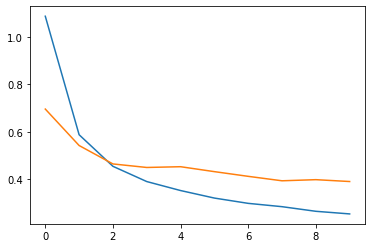

In [58]:
label_list = [tag_sequencer.idx2word[i] for i in range(len(tag_sequencer.idx2word))]

print(label_list)
train_true, train_pred, val_true, val_pred = run_training(lstm_clf, optimizer, loss_function, train_loader, val_loader, device, label_list, n_epochs=10)

['<unk>', '<pad>', '<s>', '</s>', 'O', 'B_language', 'B_director', 'I_director', 'B_subject', 'I_subject', 'B_mpaa_rating', 'B_movie', 'I_movie', 'B_person', 'I_person', 'B_producer', 'B_country', 'B_cast', 'I_cast', 'I_country', 'I_language', 'B_genre', 'I_producer', 'B_release_year', 'I_release_year', 'B_char', 'I_char', 'I_mpaa_rating', 'I-movie', 'I_genre', 'B_location']
SimpleLSTMTagger(
  (embedding): Embedding(302870, 300)
  (rnn): LSTM(300, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=100, out_features=31, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
CrossEntropyLoss()


0it [00:00, ?it/s]

Running loss:  0.23703564703464508
Epoch completed!
Epoch Loss:  0.24609453219454736
Epoch Perplexity:  1.279020476439549
              precision    recall  f1-score   support

        cast       0.27      0.35      0.30        94
        char       0.75      0.40      0.52        15
     country       0.86      0.64      0.73       143
    director       0.44      0.48      0.46       165
       genre       0.93      0.95      0.94        66
    language       0.92      0.91      0.92       104
    location       0.00      0.00      0.00         2
       movie       0.81      0.83      0.82       889
 mpaa-rating       0.82      0.63      0.71       125
      person       0.40      0.38      0.39       162
    producer       0.44      0.34      0.38       138
release-year       1.00      0.50      0.67         4
     subject       0.97      0.96      0.96        92

   micro avg       0.71      0.69      0.70      1999
   macro avg       0.66      0.57      0.60      1999
weighted avg

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0it [00:00, ?it/s]

Evaluation Loss:  0.38094982877373695
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.60      0.27      0.37        11
     country       0.67      0.55      0.60        11
    director       0.36      0.27      0.31        15
       genre       1.00      0.60      0.75         5
    language       0.80      0.80      0.80        15
       movie       0.77      0.85      0.81       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.50      0.47      0.48        15
    producer       0.50      0.62      0.55        26
     subject       0.60      1.00      0.75         3

   micro avg       0.69      0.68      0.68       216
   macro avg       0.67      0.59      0.60       216
weighted avg       0.69      0.68      0.67       216



0it [00:00, ?it/s]

Running loss:  0.24067330360412598
Epoch completed!
Epoch Loss:  0.23568907147273424
Epoch Perplexity:  1.2657806816516963
              precision    recall  f1-score   support

        cast       0.31      0.40      0.35        94
        char       0.78      0.47      0.58        15
     country       0.83      0.62      0.71       143
    director       0.46      0.49      0.47       165
       genre       0.97      0.94      0.95        66
    language       0.91      0.89      0.90       104
    location       0.00      0.00      0.00         2
       movie       0.82      0.85      0.84       889
 mpaa-rating       0.89      0.69      0.77       125
      person       0.47      0.46      0.46       162
    producer       0.43      0.36      0.39       138
release-year       0.50      0.50      0.50         4
     subject       0.97      0.97      0.97        92

   micro avg       0.73      0.71      0.72      1999
   macro avg       0.64      0.59      0.61      1999
weighted av

0it [00:00, ?it/s]

Evaluation Loss:  0.3747508153319359
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.50      0.27      0.35        11
     country       0.60      0.55      0.57        11
    director       0.31      0.27      0.29        15
       genre       1.00      0.60      0.75         5
    language       0.75      0.80      0.77        15
       movie       0.81      0.87      0.84       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.47      0.53      0.50        15
    producer       0.53      0.62      0.57        26
     subject       0.75      1.00      0.86         3

   micro avg       0.69      0.69      0.69       216
   macro avg       0.66      0.60      0.61       216
weighted avg       0.69      0.69      0.68       216



0it [00:00, ?it/s]

Running loss:  0.22781085968017578
Epoch completed!
Epoch Loss:  0.22414070786908263
Epoch Perplexity:  1.2512470673509506
              precision    recall  f1-score   support

        cast       0.31      0.43      0.36        94
        char       0.89      0.53      0.67        15
     country       0.81      0.66      0.73       143
    director       0.47      0.51      0.49       165
       genre       1.00      0.97      0.98        66
    language       0.90      0.90      0.90       104
    location       0.00      0.00      0.00         2
       movie       0.84      0.85      0.84       889
 mpaa-rating       0.84      0.70      0.77       125
      person       0.45      0.44      0.44       162
    producer       0.57      0.42      0.49       138
release-year       0.50      0.50      0.50         4
     subject       0.99      0.98      0.98        92

   micro avg       0.74      0.72      0.73      1999
   macro avg       0.66      0.61      0.63      1999
weighted av

0it [00:00, ?it/s]

Evaluation Loss:  0.37739014811813826
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.75      0.27      0.40        11
     country       0.60      0.55      0.57        11
    director       0.31      0.33      0.32        15
       genre       1.00      0.60      0.75         5
    language       0.75      0.80      0.77        15
       movie       0.79      0.89      0.84       100
 mpaa-rating       0.78      0.47      0.58        15
      person       0.53      0.53      0.53        15
    producer       0.57      0.62      0.59        26
     subject       0.75      1.00      0.86         3

   micro avg       0.70      0.70      0.70       216
   macro avg       0.68      0.61      0.62       216
weighted avg       0.70      0.70      0.69       216



0it [00:00, ?it/s]

Running loss:  0.24175016582012177
Epoch completed!
Epoch Loss:  0.22217986593022943
Epoch Perplexity:  1.2487959735145682
              precision    recall  f1-score   support

        cast       0.35      0.45      0.39        94
        char       0.92      0.73      0.81        15
     country       0.83      0.66      0.74       143
    director       0.47      0.52      0.49       165
       genre       0.97      0.94      0.95        66
    language       0.94      0.91      0.93       104
    location       0.00      0.00      0.00         2
       movie       0.83      0.85      0.84       889
 mpaa-rating       0.84      0.68      0.75       125
      person       0.47      0.48      0.48       162
    producer       0.51      0.46      0.48       138
release-year       0.67      0.50      0.57         4
     subject       0.98      0.97      0.97        92

   micro avg       0.74      0.73      0.73      1999
   macro avg       0.67      0.63      0.65      1999
weighted av

0it [00:00, ?it/s]

Evaluation Loss:  0.40356464497745037
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.60      0.27      0.37        11
     country       0.50      0.73      0.59        11
    director       0.29      0.33      0.31        15
       genre       0.75      0.60      0.67         5
    language       0.79      0.73      0.76        15
       movie       0.81      0.87      0.84       100
 mpaa-rating       1.00      0.47      0.64        15
      person       0.50      0.53      0.52        15
    producer       0.62      0.58      0.60        26
     subject       0.50      1.00      0.67         3

   micro avg       0.69      0.69      0.69       216
   macro avg       0.64      0.61      0.60       216
weighted avg       0.71      0.69      0.69       216



0it [00:00, ?it/s]

Running loss:  0.23989832401275635
Epoch completed!
Epoch Loss:  0.21883664280176168
Epoch Perplexity:  1.2446279411465064
              precision    recall  f1-score   support

        cast       0.36      0.43      0.39        94
        char       0.90      0.60      0.72        15
     country       0.80      0.65      0.72       143
    director       0.53      0.54      0.53       165
       genre       0.98      0.97      0.98        66
    language       0.92      0.92      0.92       104
    location       0.00      0.00      0.00         2
       movie       0.84      0.85      0.84       889
 mpaa-rating       0.90      0.69      0.78       125
      person       0.47      0.49      0.48       162
    producer       0.61      0.49      0.54       138
release-year       0.50      0.50      0.50         4
     subject       0.99      0.98      0.98        92

   micro avg       0.76      0.74      0.75      1999
   macro avg       0.68      0.62      0.65      1999
weighted av

0it [00:00, ?it/s]

Evaluation Loss:  0.4059289023280144
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.50      0.27      0.35        11
     country       0.73      0.73      0.73        11
    director       0.37      0.47      0.41        15
       genre       1.00      0.60      0.75         5
    language       0.80      0.80      0.80        15
       movie       0.73      0.85      0.79       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.47      0.47      0.47        15
    producer       0.62      0.58      0.60        26
     subject       0.75      1.00      0.86         3

   micro avg       0.68      0.69      0.69       216
   macro avg       0.68      0.62      0.64       216
weighted avg       0.68      0.69      0.68       216



0it [00:00, ?it/s]

Running loss:  0.20231278240680695
Epoch completed!
Epoch Loss:  0.20950859226286414
Epoch Perplexity:  1.2330719699438033
              precision    recall  f1-score   support

        cast       0.35      0.44      0.39        94
        char       0.91      0.67      0.77        15
     country       0.77      0.65      0.70       143
    director       0.51      0.56      0.54       165
       genre       0.97      0.95      0.96        66
    language       0.89      0.88      0.89       104
    location       0.00      0.00      0.00         2
       movie       0.83      0.85      0.84       889
 mpaa-rating       0.87      0.67      0.76       125
      person       0.53      0.54      0.54       162
    producer       0.60      0.53      0.56       138
release-year       0.25      0.25      0.25         4
     subject       0.99      0.98      0.98        92

   micro avg       0.75      0.74      0.75      1999
   macro avg       0.65      0.61      0.63      1999
weighted av

0it [00:00, ?it/s]

Evaluation Loss:  0.39272721856832504
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.60      0.27      0.37        11
     country       0.73      0.73      0.73        11
    director       0.27      0.40      0.32        15
       genre       1.00      0.60      0.75         5
    language       0.73      0.73      0.73        15
       movie       0.77      0.82      0.80       100
 mpaa-rating       1.00      0.47      0.64        15
      person       0.57      0.53      0.55        15
    producer       0.83      0.58      0.68        26
     subject       0.60      1.00      0.75         3

   micro avg       0.71      0.68      0.69       216
   macro avg       0.71      0.61      0.63       216
weighted avg       0.74      0.68      0.69       216



0it [00:00, ?it/s]

Running loss:  0.20772695541381836
Epoch completed!
Epoch Loss:  0.20574613031931221
Epoch Perplexity:  1.2284413004048773
              precision    recall  f1-score   support

        cast       0.37      0.46      0.41        94
        char       1.00      0.80      0.89        15
     country       0.76      0.64      0.70       143
    director       0.54      0.57      0.55       165
       genre       1.00      0.95      0.98        66
    language       0.91      0.90      0.91       104
    location       0.00      0.00      0.00         2
       movie       0.85      0.86      0.86       889
 mpaa-rating       0.91      0.68      0.78       125
      person       0.58      0.55      0.56       162
    producer       0.58      0.52      0.55       138
release-year       0.25      0.25      0.25         4
     subject       0.99      0.97      0.98        92

   micro avg       0.77      0.75      0.76      1999
   macro avg       0.67      0.63      0.65      1999
weighted av

0it [00:00, ?it/s]

Evaluation Loss:  0.389712180942297
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.38      0.27      0.32        11
     country       0.70      0.64      0.67        11
    director       0.38      0.40      0.39        15
       genre       1.00      0.60      0.75         5
    language       0.80      0.80      0.80        15
       movie       0.76      0.85      0.80       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.35      0.40      0.38        15
    producer       0.65      0.58      0.61        26
     subject       0.75      1.00      0.86         3

   micro avg       0.68      0.68      0.68       216
   macro avg       0.66      0.60      0.62       216
weighted avg       0.69      0.68      0.67       216



0it [00:00, ?it/s]

Running loss:  0.19935958087444305
Epoch completed!
Epoch Loss:  0.2030594466486945
Epoch Perplexity:  1.2251452968648315
              precision    recall  f1-score   support

        cast       0.37      0.47      0.42        94
        char       1.00      0.80      0.89        15
     country       0.82      0.68      0.74       143
    director       0.57      0.57      0.57       165
       genre       0.98      0.95      0.97        66
    language       0.91      0.90      0.91       104
    location       0.00      0.00      0.00         2
       movie       0.85      0.87      0.86       889
 mpaa-rating       0.85      0.69      0.76       125
      person       0.58      0.57      0.58       162
    producer       0.60      0.54      0.57       138
release-year       1.00      0.50      0.67         4
     subject       1.00      0.98      0.99        92

   micro avg       0.78      0.76      0.77      1999
   macro avg       0.73      0.66      0.69      1999
weighted avg

0it [00:00, ?it/s]

Evaluation Loss:  0.3874542899429798
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.50      0.27      0.35        11
     country       0.71      0.45      0.56        11
    director       0.35      0.40      0.38        15
       genre       1.00      0.60      0.75         5
    language       0.85      0.73      0.79        15
       movie       0.79      0.85      0.82       100
 mpaa-rating       1.00      0.47      0.64        15
      person       0.53      0.53      0.53        15
    producer       0.75      0.58      0.65        26
     subject       0.75      1.00      0.86         3

   micro avg       0.73      0.68      0.70       216
   macro avg       0.72      0.59      0.63       216
weighted avg       0.74      0.68      0.70       216



0it [00:00, ?it/s]

Running loss:  0.21611709892749786
Epoch completed!
Epoch Loss:  0.19722856092266738
Epoch Perplexity:  1.2180224012173808
              precision    recall  f1-score   support

        cast       0.39      0.45      0.41        94
        char       0.86      0.80      0.83        15
     country       0.81      0.70      0.75       143
    director       0.56      0.58      0.57       165
       genre       0.98      0.97      0.98        66
    language       0.94      0.91      0.93       104
    location       0.00      0.00      0.00         2
       movie       0.86      0.87      0.86       889
 mpaa-rating       0.87      0.68      0.76       125
      person       0.58      0.57      0.57       162
    producer       0.68      0.56      0.61       138
release-year       0.50      0.50      0.50         4
     subject       1.00      0.99      0.99        92

   micro avg       0.78      0.77      0.78      1999
   macro avg       0.69      0.66      0.68      1999
weighted av

0it [00:00, ?it/s]

Evaluation Loss:  0.42711592838168144
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.60      0.27      0.37        11
        char       0.00      0.00      0.00         0
     country       0.71      0.45      0.56        11
    director       0.39      0.47      0.42        15
       genre       1.00      0.60      0.75         5
    language       0.75      0.80      0.77        15
       movie       0.80      0.86      0.83       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.53      0.53      0.53        15
    producer       0.68      0.58      0.62        26
     subject       0.75      1.00      0.86         3

   micro avg       0.72      0.69      0.70       216
   macro avg       0.64      0.55      0.58       216
weighted avg       0.73      0.69      0.70       216



/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0it [00:00, ?it/s]

Running loss:  0.21954187750816345
Epoch completed!
Epoch Loss:  0.19424437626730653
Epoch Perplexity:  1.2143930155297353
              precision    recall  f1-score   support

        cast       0.41      0.48      0.44        94
        char       0.92      0.73      0.81        15
     country       0.78      0.71      0.75       143
    director       0.57      0.62      0.59       165
       genre       0.98      0.95      0.97        66
    language       0.94      0.91      0.93       104
    location       0.00      0.00      0.00         2
       movie       0.86      0.87      0.86       889
 mpaa-rating       0.96      0.73      0.83       125
      person       0.58      0.60      0.59       162
    producer       0.69      0.58      0.63       138
release-year       0.67      0.50      0.57         4
     subject       0.99      0.98      0.98        92

   micro avg       0.79      0.78      0.78      1999
   macro avg       0.72      0.67      0.69      1999
weighted av

0it [00:00, ?it/s]

Evaluation Loss:  0.3799437452107668
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.50      0.27      0.35        11
     country       0.78      0.64      0.70        11
    director       0.44      0.47      0.45        15
       genre       1.00      0.60      0.75         5
    language       0.86      0.80      0.83        15
       movie       0.79      0.85      0.82       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.60      0.60      0.60        15
    producer       0.70      0.62      0.65        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.74      0.70      0.72       216
   macro avg       0.66      0.57      0.60       216
weighted avg       0.74      0.70      0.71       216



0it [00:00, ?it/s]

Running loss:  0.20083124935626984
Epoch completed!
Epoch Loss:  0.19096562440972778
Epoch Perplexity:  1.210417842538314
              precision    recall  f1-score   support

        cast       0.38      0.48      0.42        94
        char       1.00      0.80      0.89        15
     country       0.79      0.69      0.74       143
    director       0.59      0.61      0.60       165
       genre       1.00      0.97      0.98        66
    language       0.91      0.89      0.90       104
    location       0.00      0.00      0.00         2
       movie       0.85      0.87      0.85       889
 mpaa-rating       0.89      0.70      0.79       125
      person       0.54      0.53      0.54       162
    producer       0.64      0.57      0.60       138
release-year       0.67      0.50      0.57         4
     subject       1.00      0.99      0.99        92

   micro avg       0.77      0.76      0.77      1999
   macro avg       0.71      0.66      0.68      1999
weighted avg

0it [00:00, ?it/s]

Evaluation Loss:  0.41059814766049385
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.50      0.27      0.35        11
     country       0.69      0.82      0.75        11
    director       0.42      0.53      0.47        15
       genre       1.00      0.60      0.75         5
    language       1.00      0.80      0.89        15
       movie       0.76      0.87      0.81       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.67      0.53      0.59        15
    producer       0.76      0.62      0.68        26
release-year       0.00      0.00      0.00         0
     subject       0.60      1.00      0.75         3

   micro avg       0.73      0.72      0.73       216
   macro avg       0.66      0.59      0.61       216
weighted avg       0.74      0.72      0.72       216



0it [00:00, ?it/s]

Running loss:  0.20116351544857025
Epoch completed!
Epoch Loss:  0.18937745795119545
Epoch Perplexity:  1.2084970232141332
              precision    recall  f1-score   support

        cast       0.45      0.53      0.49        94
        char       1.00      0.87      0.93        15
     country       0.78      0.73      0.75       143
    director       0.56      0.61      0.59       165
       genre       0.98      0.94      0.96        66
    language       0.91      0.92      0.92       104
    location       0.00      0.00      0.00         2
       movie       0.86      0.86      0.86       889
 mpaa-rating       0.92      0.72      0.81       125
      person       0.59      0.59      0.59       162
    producer       0.69      0.57      0.62       138
release-year       0.67      0.50      0.57         4
     subject       0.99      0.98      0.98        92

   micro avg       0.79      0.78      0.78      1999
   macro avg       0.72      0.68      0.70      1999
weighted av

0it [00:00, ?it/s]

Evaluation Loss:  0.4035271927714348
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.33      0.27      0.30        11
     country       0.89      0.73      0.80        11
    director       0.37      0.47      0.41        15
       genre       1.00      0.60      0.75         5
    language       0.86      0.80      0.83        15
       movie       0.82      0.84      0.83       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.54      0.47      0.50        15
    producer       0.79      0.58      0.67        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.74      0.69      0.71       216
   macro avg       0.66      0.57      0.60       216
weighted avg       0.76      0.69      0.71       216



0it [00:00, ?it/s]

Running loss:  0.206668883562088
Epoch completed!
Epoch Loss:  0.18177383136935532
Epoch Perplexity:  1.1993429094595058
              precision    recall  f1-score   support

        cast       0.43      0.49      0.46        94
        char       1.00      0.80      0.89        15
     country       0.77      0.72      0.74       143
    director       0.58      0.62      0.60       165
       genre       0.98      0.97      0.98        66
    language       0.92      0.91      0.92       104
    location       0.00      0.00      0.00         2
       movie       0.86      0.88      0.87       889
 mpaa-rating       0.90      0.74      0.82       125
      person       0.63      0.60      0.62       162
    producer       0.70      0.58      0.63       138
release-year       0.20      0.25      0.22         4
     subject       1.00      0.99      0.99        92

   micro avg       0.79      0.78      0.79      1999
   macro avg       0.69      0.66      0.67      1999
weighted avg 

0it [00:00, ?it/s]

Evaluation Loss:  0.40032864920794964
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.33      0.27      0.30        11
     country       0.73      0.73      0.73        11
    director       0.37      0.47      0.41        15
       genre       1.00      0.60      0.75         5
    language       0.80      0.80      0.80        15
       movie       0.80      0.84      0.82       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.50      0.47      0.48        15
    producer       0.68      0.58      0.62        26
release-year       0.00      0.00      0.00         0
     subject       0.60      1.00      0.75         3

   micro avg       0.70      0.69      0.70       216
   macro avg       0.61      0.57      0.57       216
weighted avg       0.71      0.69      0.69       216



0it [00:00, ?it/s]

Running loss:  0.16147413849830627
Epoch completed!
Epoch Loss:  0.184070062241517
Epoch Perplexity:  1.2021000419694536
              precision    recall  f1-score   support

        cast       0.43      0.49      0.46        94
        char       0.93      0.87      0.90        15
     country       0.81      0.71      0.76       143
    director       0.59      0.64      0.62       165
       genre       1.00      0.95      0.98        66
    language       0.93      0.93      0.93       104
    location       1.00      0.50      0.67         2
       movie       0.88      0.88      0.88       889
 mpaa-rating       0.93      0.74      0.82       125
      person       0.61      0.59      0.60       162
    producer       0.65      0.55      0.60       138
release-year       1.00      0.75      0.86         4
     subject       0.99      0.98      0.98        92

   micro avg       0.80      0.78      0.79      1999
   macro avg       0.83      0.74      0.77      1999
weighted avg 

0it [00:00, ?it/s]

Evaluation Loss:  0.41279857419431204
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.60      0.27      0.37        11
     country       0.67      0.73      0.70        11
    director       0.47      0.53      0.50        15
       genre       1.00      0.60      0.75         5
    language       0.75      0.80      0.77        15
       movie       0.79      0.88      0.83       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.54      0.47      0.50        15
    producer       0.79      0.58      0.67        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.73      0.71      0.72       216
   macro avg       0.66      0.57      0.60       216
weighted avg       0.74      0.71      0.71       216



0it [00:00, ?it/s]

Running loss:  0.21517017483711243
Epoch completed!
Epoch Loss:  0.18188651069067419
Epoch Perplexity:  1.1994780582186646
              precision    recall  f1-score   support

        cast       0.39      0.50      0.44        94
        char       0.93      0.87      0.90        15
     country       0.78      0.72      0.75       143
    director       0.59      0.62      0.61       165
       genre       0.98      0.97      0.98        66
    language       0.94      0.93      0.94       104
    location       1.00      0.50      0.67         2
       movie       0.87      0.88      0.87       889
 mpaa-rating       0.92      0.74      0.82       125
      person       0.63      0.60      0.62       162
    producer       0.70      0.58      0.63       138
release-year       1.00      0.50      0.67         4
     subject       1.00      0.98      0.99        92

   micro avg       0.80      0.79      0.79      1999
   macro avg       0.83      0.72      0.76      1999
weighted av

0it [00:00, ?it/s]

Evaluation Loss:  0.42246536910533905
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.38      0.27      0.32        11
        char       0.00      0.00      0.00         0
     country       0.64      0.64      0.64        11
    director       0.38      0.53      0.44        15
       genre       1.00      0.60      0.75         5
    language       0.86      0.80      0.83        15
    location       0.00      0.00      0.00         0
       movie       0.79      0.85      0.82       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.58      0.47      0.52        15
    producer       0.83      0.58      0.68        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.71      0.69      0.70       216
   macro avg       0.54      0.48      0.50       216
weighted avg       0.74      0.69      0.70       216



0it [00:00, ?it/s]

Running loss:  0.1810408979654312
Epoch completed!
Epoch Loss:  0.18033534148707983
Epoch Perplexity:  1.197618907096131
              precision    recall  f1-score   support

        cast       0.47      0.54      0.50        94
        char       0.85      0.73      0.79        15
     country       0.82      0.74      0.78       143
    director       0.61      0.62      0.62       165
       genre       0.98      0.92      0.95        66
    language       0.93      0.91      0.92       104
    location       1.00      0.50      0.67         2
       movie       0.88      0.89      0.88       889
 mpaa-rating       0.92      0.73      0.81       125
      person       0.58      0.59      0.58       162
    producer       0.68      0.58      0.63       138
release-year       0.50      0.50      0.50         4
     subject       0.98      0.98      0.98        92

   micro avg       0.81      0.79      0.80      1999
   macro avg       0.78      0.71      0.74      1999
weighted avg 

0it [00:00, ?it/s]

Evaluation Loss:  0.4231705069541931
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.38      0.27      0.32        11
        char       0.00      0.00      0.00         0
     country       0.75      0.82      0.78        11
    director       0.38      0.53      0.44        15
       genre       1.00      0.60      0.75         5
    language       0.92      0.73      0.81        15
    location       0.00      0.00      0.00         0
       movie       0.80      0.86      0.83       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.58      0.47      0.52        15
    producer       0.83      0.58      0.68        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.72      0.70      0.71       216
   macro avg       0.56      0.49      0.51       216
weighted avg       0.75      0.70      0.72       216



0it [00:00, ?it/s]

Running loss:  0.1578400582075119
Epoch completed!
Epoch Loss:  0.1750647017615847
Epoch Perplexity:  1.1913232948345756
              precision    recall  f1-score   support

        cast       0.52      0.53      0.53        94
        char       1.00      0.80      0.89        15
     country       0.76      0.75      0.76       143
    director       0.61      0.65      0.63       165
       genre       1.00      0.97      0.98        66
    language       0.90      0.91      0.91       104
    location       1.00      0.50      0.67         2
       movie       0.88      0.88      0.88       889
 mpaa-rating       0.94      0.74      0.83       125
      person       0.61      0.59      0.60       162
    producer       0.69      0.59      0.64       138
release-year       1.00      0.75      0.86         4
     subject       1.00      0.99      0.99        92

   micro avg       0.81      0.79      0.80      1999
   macro avg       0.84      0.74      0.78      1999
weighted avg 

0it [00:00, ?it/s]

Evaluation Loss:  0.42334937304258347
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.50      0.27      0.35        11
     country       0.57      0.36      0.44        11
    director       0.44      0.53      0.48        15
       genre       1.00      0.60      0.75         5
    language       0.80      0.80      0.80        15
    location       0.00      0.00      0.00         0
       movie       0.77      0.85      0.81       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.62      0.53      0.57        15
    producer       0.73      0.62      0.67        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.71      0.69      0.70       216
   macro avg       0.59      0.50      0.53       216
weighted avg       0.72      0.69      0.69       216



0it [00:00, ?it/s]

Running loss:  0.19413124024868011
Epoch completed!
Epoch Loss:  0.17630493367323657
Epoch Perplexity:  1.1928017286127917
              precision    recall  f1-score   support

        cast       0.44      0.51      0.48        94
        char       0.91      0.67      0.77        15
     country       0.79      0.78      0.78       143
    director       0.62      0.67      0.64       165
       genre       0.98      0.95      0.97        66
    language       0.91      0.91      0.91       104
    location       0.00      0.00      0.00         2
       movie       0.87      0.88      0.87       889
 mpaa-rating       0.92      0.73      0.81       125
      person       0.60      0.60      0.60       162
    producer       0.61      0.53      0.57       138
release-year       0.60      0.75      0.67         4
     subject       0.99      0.99      0.99        92

   micro avg       0.79      0.79      0.79      1999
   macro avg       0.71      0.69      0.70      1999
weighted av

0it [00:00, ?it/s]

Evaluation Loss:  0.42427095770835876
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.38      0.27      0.32        11
     country       0.73      0.73      0.73        11
    director       0.50      0.53      0.52        15
       genre       1.00      0.60      0.75         5
    language       0.92      0.73      0.81        15
    location       0.00      0.00      0.00         0
       movie       0.79      0.84      0.81       100
 mpaa-rating       0.78      0.47      0.58        15
      person       0.47      0.47      0.47        15
    producer       0.71      0.58      0.64        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.72      0.69      0.70       216
   macro avg       0.58      0.52      0.54       216
weighted avg       0.72      0.69      0.70       216



0it [00:00, ?it/s]

Running loss:  0.1886214315891266
Epoch completed!
Epoch Loss:  0.1734003125457093
Epoch Perplexity:  1.1893421183717545
              precision    recall  f1-score   support

        cast       0.39      0.46      0.42        94
        char       0.93      0.87      0.90        15
     country       0.74      0.70      0.72       143
    director       0.61      0.66      0.64       165
       genre       1.00      0.97      0.98        66
    language       0.90      0.90      0.90       104
    location       0.00      0.00      0.00         2
       movie       0.87      0.88      0.87       889
 mpaa-rating       0.92      0.74      0.82       125
      person       0.59      0.59      0.59       162
    producer       0.71      0.58      0.64       138
release-year       0.75      0.75      0.75         4
     subject       1.00      0.99      0.99        92

   micro avg       0.79      0.78      0.79      1999
   macro avg       0.72      0.70      0.71      1999
weighted avg 

0it [00:00, ?it/s]

Evaluation Loss:  0.4423305094242096
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.33      0.27      0.30        11
     country       0.67      0.55      0.60        11
    director       0.38      0.53      0.44        15
       genre       1.00      0.60      0.75         5
    language       1.00      0.73      0.85        15
    location       0.00      0.00      0.00         0
       movie       0.76      0.87      0.81       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.50      0.47      0.48        15
    producer       0.82      0.54      0.65        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.70      0.69      0.69       216
   macro avg       0.59      0.50      0.53       216
weighted avg       0.73      0.69      0.70       216



0it [00:00, ?it/s]

Running loss:  0.1878967136144638
Epoch completed!
Epoch Loss:  0.1746188998222351
Epoch Perplexity:  1.1907923189631764
              precision    recall  f1-score   support

        cast       0.47      0.53      0.50        94
        char       1.00      0.87      0.93        15
     country       0.79      0.75      0.77       143
    director       0.59      0.67      0.63       165
       genre       1.00      0.97      0.98        66
    language       0.94      0.91      0.93       104
    location       1.00      1.00      1.00         2
       movie       0.86      0.88      0.87       889
 mpaa-rating       0.93      0.72      0.81       125
      person       0.59      0.58      0.59       162
    producer       0.69      0.59      0.64       138
release-year       0.60      0.75      0.67         4
     subject       1.00      0.99      0.99        92

   micro avg       0.80      0.79      0.79      1999
   macro avg       0.81      0.78      0.79      1999
weighted avg 

0it [00:00, ?it/s]

Evaluation Loss:  0.4157219063490629
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.33      0.27      0.30        11
     country       0.60      0.82      0.69        11
    director       0.44      0.53      0.48        15
       genre       1.00      0.60      0.75         5
    language       0.92      0.80      0.86        15
    location       0.00      0.00      0.00         0
       movie       0.80      0.86      0.83       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.50      0.47      0.48        15
    producer       0.94      0.58      0.71        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.73      0.71      0.72       216
   macro avg       0.60      0.53      0.55       216
weighted avg       0.75      0.71      0.72       216



0it [00:00, ?it/s]

Running loss:  0.20337876677513123
Epoch completed!
Epoch Loss:  0.1709285995457321
Epoch Perplexity:  1.1864060360675546
              precision    recall  f1-score   support

        cast       0.45      0.51      0.48        94
        char       1.00      0.80      0.89        15
     country       0.77      0.74      0.75       143
    director       0.61      0.68      0.64       165
       genre       1.00      0.97      0.98        66
    language       0.92      0.89      0.91       104
    location       1.00      0.50      0.67         2
       movie       0.87      0.89      0.88       889
 mpaa-rating       0.94      0.74      0.83       125
      person       0.58      0.61      0.60       162
    producer       0.71      0.61      0.66       138
release-year       1.00      0.50      0.67         4
     subject       0.98      0.98      0.98        92

   micro avg       0.80      0.80      0.80      1999
   macro avg       0.83      0.72      0.76      1999
weighted avg

0it [00:00, ?it/s]

Evaluation Loss:  0.43057747185230255
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.43      0.27      0.33        11
        char       0.00      0.00      0.00         0
     country       0.75      0.82      0.78        11
    director       0.39      0.47      0.42        15
       genre       1.00      0.60      0.75         5
    language       0.92      0.80      0.86        15
    location       0.00      0.00      0.00         0
       movie       0.78      0.85      0.81       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.50      0.47      0.48        15
    producer       0.88      0.58      0.70        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.73      0.70      0.71       216
   macro avg       0.56      0.49      0.51       216
weighted avg       0.75      0.70      0.71       216



0it [00:00, ?it/s]

Running loss:  0.17975008487701416
Epoch completed!
Epoch Loss:  0.1720989926252514
Epoch Perplexity:  1.1877954103801087
              precision    recall  f1-score   support

        cast       0.48      0.51      0.50        94
        char       0.77      0.67      0.71        15
     country       0.74      0.77      0.76       143
    director       0.61      0.65      0.63       165
       genre       0.98      0.95      0.97        66
    language       0.89      0.88      0.89       104
    location       1.00      0.50      0.67         2
       movie       0.88      0.89      0.88       889
 mpaa-rating       0.90      0.74      0.81       125
      person       0.59      0.60      0.59       162
    producer       0.73      0.60      0.66       138
release-year       1.00      0.50      0.67         4
     subject       1.00      0.99      0.99        92

   micro avg       0.80      0.79      0.80      1999
   macro avg       0.81      0.71      0.75      1999
weighted avg

0it [00:00, ?it/s]

Evaluation Loss:  0.4506804719567299
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.33      0.27      0.30        11
     country       0.75      0.82      0.78        11
    director       0.44      0.53      0.48        15
       genre       1.00      0.60      0.75         5
    language       0.86      0.80      0.83        15
    location       0.00      0.00      0.00         0
       movie       0.79      0.84      0.82       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.54      0.47      0.50        15
    producer       0.84      0.62      0.71        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.73      0.70      0.72       216
   macro avg       0.60      0.53      0.55       216
weighted avg       0.75      0.70      0.72       216



0it [00:00, ?it/s]

Running loss:  0.16418948769569397
Epoch completed!
Epoch Loss:  0.16773683414794496
Epoch Perplexity:  1.1826253430860356
              precision    recall  f1-score   support

        cast       0.50      0.53      0.51        94
        char       1.00      0.87      0.93        15
     country       0.77      0.76      0.77       143
    director       0.67      0.69      0.68       165
       genre       1.00      0.97      0.98        66
    language       0.94      0.92      0.93       104
    location       1.00      0.50      0.67         2
       movie       0.87      0.89      0.88       889
 mpaa-rating       0.93      0.74      0.83       125
      person       0.61      0.60      0.61       162
    producer       0.71      0.60      0.65       138
release-year       1.00      0.75      0.86         4
     subject       1.00      0.99      0.99        92

   micro avg       0.81      0.80      0.81      1999
   macro avg       0.85      0.75      0.79      1999
weighted av

0it [00:00, ?it/s]

Evaluation Loss:  0.4306642822921276
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.30      0.27      0.29        11
     country       0.50      0.45      0.48        11
    director       0.44      0.53      0.48        15
       genre       1.00      0.60      0.75         5
    language       0.73      0.73      0.73        15
    location       0.00      0.00      0.00         0
       movie       0.79      0.85      0.82       100
 mpaa-rating       0.78      0.47      0.58        15
      person       0.50      0.47      0.48        15
    producer       0.94      0.62      0.74        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.70      0.69      0.69       216
   macro avg       0.56      0.50      0.52       216
weighted avg       0.72      0.69      0.69       216



0it [00:00, ?it/s]

Running loss:  0.1362639218568802
Epoch completed!
Epoch Loss:  0.16460103646386418
Epoch Perplexity:  1.1789226777128974
              precision    recall  f1-score   support

        cast       0.47      0.53      0.50        94
        char       0.86      0.80      0.83        15
     country       0.76      0.77      0.77       143
    director       0.61      0.67      0.64       165
       genre       1.00      0.97      0.98        66
    language       0.93      0.92      0.93       104
    location       1.00      0.50      0.67         2
       movie       0.88      0.89      0.88       889
 mpaa-rating       0.91      0.75      0.82       125
      person       0.64      0.62      0.63       162
    producer       0.71      0.59      0.65       138
release-year       1.00      1.00      1.00         4
     subject       1.00      0.99      0.99        92

   micro avg       0.81      0.80      0.81      1999
   macro avg       0.83      0.77      0.79      1999
weighted avg

0it [00:00, ?it/s]

Evaluation Loss:  0.43989764153957367
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.38      0.27      0.32        11
        char       0.00      0.00      0.00         0
     country       0.69      0.82      0.75        11
    director       0.40      0.53      0.46        15
       genre       1.00      0.60      0.75         5
    language       1.00      0.73      0.85        15
    location       0.00      0.00      0.00         0
       movie       0.79      0.91      0.85       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.57      0.53      0.55        15
    producer       0.84      0.62      0.71        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.73      0.74      0.73       216
   macro avg       0.56      0.50      0.51       216
weighted avg       0.75      0.74      0.73       216



0it [00:00, ?it/s]

Running loss:  0.1981377899646759
Epoch completed!
Epoch Loss:  0.16380324726924303
Epoch Perplexity:  1.1779825210126176
              precision    recall  f1-score   support

        cast       0.47      0.54      0.50        94
        char       0.92      0.80      0.86        15
     country       0.78      0.78      0.78       143
    director       0.65      0.68      0.67       165
       genre       1.00      0.97      0.98        66
    language       0.91      0.92      0.92       104
    location       1.00      0.50      0.67         2
       movie       0.87      0.89      0.88       889
 mpaa-rating       0.92      0.73      0.81       125
      person       0.63      0.62      0.63       162
    producer       0.67      0.60      0.64       138
release-year       0.67      0.50      0.57         4
     subject       1.00      0.99      0.99        92

   micro avg       0.81      0.80      0.80      1999
   macro avg       0.81      0.73      0.76      1999
weighted avg

0it [00:00, ?it/s]

Evaluation Loss:  0.46200836822390556
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.43      0.27      0.33        11
        char       0.00      0.00      0.00         0
     country       0.64      0.64      0.64        11
    director       0.40      0.53      0.46        15
       genre       1.00      0.60      0.75         5
    language       0.85      0.73      0.79        15
    location       0.00      0.00      0.00         0
       movie       0.79      0.84      0.82       100
 mpaa-rating       0.78      0.47      0.58        15
      person       0.41      0.47      0.44        15
    producer       0.94      0.58      0.71        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.70      0.69      0.69       216
   macro avg       0.54      0.47      0.49       216
weighted avg       0.74      0.69      0.70       216



0it [00:00, ?it/s]

Running loss:  0.17484545707702637
Epoch completed!
Epoch Loss:  0.16556414798833424
Epoch Perplexity:  1.180058658680633
              precision    recall  f1-score   support

        cast       0.45      0.50      0.47        94
        char       1.00      0.80      0.89        15
     country       0.82      0.74      0.78       143
    director       0.61      0.65      0.63       165
       genre       1.00      0.97      0.98        66
    language       0.96      0.95      0.96       104
    location       0.50      0.50      0.50         2
       movie       0.88      0.90      0.89       889
 mpaa-rating       0.92      0.74      0.82       125
      person       0.61      0.62      0.61       162
    producer       0.66      0.62      0.64       138
release-year       1.00      0.75      0.86         4
     subject       1.00      0.99      0.99        92

   micro avg       0.81      0.80      0.81      1999
   macro avg       0.80      0.75      0.77      1999
weighted avg

0it [00:00, ?it/s]

Evaluation Loss:  0.44346531853079796
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.38      0.27      0.32        11
        char       0.00      0.00      0.00         0
     country       0.69      0.82      0.75        11
    director       0.42      0.53      0.47        15
       genre       1.00      0.60      0.75         5
    language       0.92      0.73      0.81        15
    location       0.00      0.00      0.00         0
       movie       0.79      0.85      0.82       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.64      0.47      0.54        15
    producer       0.94      0.62      0.74        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.73      0.70      0.72       216
   macro avg       0.57      0.49      0.51       216
weighted avg       0.76      0.70      0.72       216



0it [00:00, ?it/s]

Running loss:  0.13580773770809174
Epoch completed!
Epoch Loss:  0.1626557448180392
Epoch Perplexity:  1.1766315584469496
              precision    recall  f1-score   support

        cast       0.50      0.55      0.53        94
        char       0.93      0.87      0.90        15
     country       0.78      0.76      0.77       143
    director       0.63      0.68      0.65       165
       genre       0.98      0.95      0.97        66
    language       0.89      0.89      0.89       104
    location       1.00      1.00      1.00         2
       movie       0.89      0.90      0.89       889
 mpaa-rating       0.93      0.75      0.83       125
      person       0.64      0.62      0.63       162
    producer       0.67      0.59      0.63       138
release-year       0.50      0.50      0.50         4
     subject       1.00      0.99      0.99        92

   micro avg       0.81      0.81      0.81      1999
   macro avg       0.80      0.77      0.78      1999
weighted avg

0it [00:00, ?it/s]

Evaluation Loss:  0.44641199335455894
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.38      0.27      0.32        11
     country       0.64      0.64      0.64        11
    director       0.44      0.53      0.48        15
       genre       1.00      0.60      0.75         5
    language       0.71      0.80      0.75        15
    location       0.00      0.00      0.00         0
       movie       0.80      0.85      0.83       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.50      0.47      0.48        15
    producer       0.94      0.58      0.71        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.72      0.69      0.71       216
   macro avg       0.59      0.52      0.54       216
weighted avg       0.74      0.69      0.71       216



0it [00:00, ?it/s]

Running loss:  0.16437749564647675
Epoch completed!
Epoch Loss:  0.16090120805893096
Epoch Perplexity:  1.1745689251378422
              precision    recall  f1-score   support

        cast       0.47      0.52      0.49        94
        char       0.93      0.87      0.90        15
     country       0.80      0.76      0.78       143
    director       0.67      0.71      0.69       165
       genre       0.95      0.95      0.95        66
    language       0.89      0.92      0.91       104
    location       1.00      1.00      1.00         2
       movie       0.88      0.89      0.89       889
 mpaa-rating       0.91      0.75      0.82       125
      person       0.65      0.62      0.64       162
    producer       0.70      0.62      0.65       138
release-year       1.00      0.75      0.86         4
     subject       0.99      0.99      0.99        92

   micro avg       0.82      0.81      0.81      1999
   macro avg       0.83      0.80      0.81      1999
weighted av

0it [00:00, ?it/s]

Evaluation Loss:  0.46896275877952576
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.43      0.27      0.33        11
     country       0.54      0.64      0.58        11
    director       0.37      0.47      0.41        15
       genre       1.00      0.60      0.75         5
    language       0.80      0.80      0.80        15
    location       0.00      0.00      0.00         0
       movie       0.79      0.84      0.82       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.54      0.47      0.50        15
    producer       0.88      0.58      0.70        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.71      0.69      0.70       216
   macro avg       0.58      0.51      0.53       216
weighted avg       0.74      0.69      0.70       216



0it [00:00, ?it/s]

Running loss:  0.14782534539699554
Epoch completed!
Epoch Loss:  0.16121298552025104
Epoch Perplexity:  1.1749351863484956
              precision    recall  f1-score   support

        cast       0.47      0.50      0.48        94
        char       0.87      0.87      0.87        15
     country       0.79      0.76      0.78       143
    director       0.67      0.70      0.68       165
       genre       1.00      0.94      0.97        66
    language       0.92      0.92      0.92       104
    location       1.00      0.50      0.67         2
       movie       0.87      0.89      0.88       889
 mpaa-rating       0.93      0.72      0.81       125
      person       0.64      0.63      0.63       162
    producer       0.70      0.59      0.64       138
release-year       0.33      0.25      0.29         4
     subject       0.99      0.99      0.99        92

   micro avg       0.81      0.80      0.81      1999
   macro avg       0.78      0.71      0.74      1999
weighted av

0it [00:00, ?it/s]

Evaluation Loss:  0.43751609325408936
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.33      0.27      0.30        11
     country       0.58      0.64      0.61        11
    director       0.41      0.47      0.44        15
       genre       1.00      0.60      0.75         5
    language       0.75      0.80      0.77        15
    location       0.00      0.00      0.00         0
       movie       0.77      0.86      0.81       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.40      0.40      0.40        15
    producer       0.94      0.58      0.71        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.70      0.69      0.69       216
   macro avg       0.57      0.51      0.52       216
weighted avg       0.72      0.69      0.69       216



0it [00:00, ?it/s]

Running loss:  0.17772340774536133
Epoch completed!
Epoch Loss:  0.1610395719762892
Epoch Perplexity:  1.1747314543393608
              precision    recall  f1-score   support

        cast       0.51      0.57      0.54        94
        char       1.00      0.87      0.93        15
     country       0.81      0.76      0.79       143
    director       0.63      0.68      0.66       165
       genre       0.97      0.97      0.97        66
    language       0.93      0.91      0.92       104
    location       1.00      0.50      0.67         2
       movie       0.87      0.89      0.88       889
 mpaa-rating       0.92      0.75      0.83       125
      person       0.59      0.59      0.59       162
    producer       0.75      0.62      0.68       138
release-year       1.00      0.75      0.86         4
     subject       0.99      0.98      0.98        92

   micro avg       0.81      0.80      0.81      1999
   macro avg       0.84      0.76      0.79      1999
weighted avg

0it [00:00, ?it/s]

Evaluation Loss:  0.4301371481269598
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.30      0.27      0.29        11
        char       0.00      0.00      0.00         0
     country       0.78      0.64      0.70        11
    director       0.50      0.53      0.52        15
       genre       1.00      0.60      0.75         5
    language       0.80      0.80      0.80        15
    location       0.00      0.00      0.00         0
       movie       0.79      0.85      0.82       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.58      0.47      0.52        15
    producer       0.89      0.62      0.73        26
release-year       0.00      0.00      0.00         0
     subject       0.60      1.00      0.75         3

   micro avg       0.73      0.70      0.72       216
   macro avg       0.55      0.48      0.50       216
weighted avg       0.75      0.70      0.72       216



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


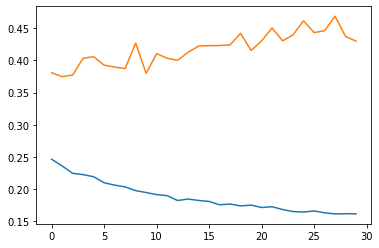

In [59]:
label_list = [tag_sequencer.idx2word[i] for i in range(len(tag_sequencer.idx2word))]

print(label_list)
train_true, train_pred, val_true, val_pred = run_training(lstm_clf, optimizer, loss_function, train_loader, val_loader, device, label_list, n_epochs=30)

['<unk>', '<pad>', '<s>', '</s>', 'O', 'B_language', 'B_director', 'I_director', 'B_subject', 'I_subject', 'B_mpaa_rating', 'B_movie', 'I_movie', 'B_person', 'I_person', 'B_producer', 'B_country', 'B_cast', 'I_cast', 'I_country', 'I_language', 'B_genre', 'I_producer', 'B_release_year', 'I_release_year', 'B_char', 'I_char', 'I_mpaa_rating', 'I-movie', 'I_genre', 'B_location']
SimpleLSTMTagger(
  (embedding): Embedding(302870, 300)
  (rnn): LSTM(300, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=100, out_features=31, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
CrossEntropyLoss()


0it [00:00, ?it/s]

Running loss:  3.4912328720092773
Running loss:  1.7233881501868218
Epoch completed!
Epoch Loss:  1.6155726327670834
Epoch Perplexity:  5.030767881343377
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        94
        char       0.00      0.00      0.00        15
     country       0.00      0.00      0.00       143
    director       0.00      0.00      0.00       165
       genre       0.00      0.00      0.00        66
    language       0.08      0.02      0.03       104
    location       0.00      0.00      0.00         2
       movie       0.17      0.00      0.00       889
 mpaa-rating       0.02      0.01      0.01       125
      person       0.00      0.00      0.00       162
    producer       0.00      0.00      0.00       138
release-year       0.00      0.00      0.00         4
     subject       0.01      0.02      0.01        92
        unk>       0.00      0.00      0.00         0

   micro avg       0.01      0.00 

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <unk> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0it [00:00, ?it/s]

Evaluation Loss:  1.1019027074178058
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.00      0.00      0.00        11
    director       0.00      0.00      0.00        15
       genre       0.00      0.00      0.00         5
    language       0.00      0.00      0.00        15
       movie       1.00      0.02      0.04       100
 mpaa-rating       0.00      0.00      0.00        15
      person       0.00      0.00      0.00        15
    producer       0.00      0.00      0.00        26
     subject       0.00      0.00      0.00         3

   micro avg       0.67      0.01      0.02       216
   macro avg       0.10      0.00      0.00       216
weighted avg       0.46      0.01      0.02       216



0it [00:00, ?it/s]

Running loss:  1.0449687242507935
Running loss:  0.9705050817810664
Epoch completed!
Epoch Loss:  0.938712939033358
Epoch Perplexity:  2.556688685598838
              precision    recall  f1-score   support

         /s>       0.00      0.00      0.00         0
        cast       0.00      0.00      0.00        94
        char       0.00      0.00      0.00        15
     country       0.00      0.00      0.00       143
    director       0.00      0.00      0.00       165
       genre       0.00      0.00      0.00        66
    language       0.00      0.00      0.00       104
    location       0.00      0.00      0.00         2
       movie       0.25      0.27      0.26       889
 mpaa-rating       0.50      0.01      0.02       125
      person       0.00      0.00      0.00       162
    producer       0.00      0.00      0.00       138
release-year       0.00      0.00      0.00         4
     subject       0.00      0.00      0.00        92

   micro avg       0.25      0.12  

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: </s> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


0it [00:00, ?it/s]

Evaluation Loss:  0.7986775795618694
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.00      0.00      0.00        11
    director       0.00      0.00      0.00        15
       genre       0.00      0.00      0.00         5
    language       0.00      0.00      0.00        15
       movie       0.30      0.43      0.35       100
 mpaa-rating       0.00      0.00      0.00        15
      person       0.00      0.00      0.00        15
    producer       0.00      0.00      0.00        26
     subject       0.00      0.00      0.00         3

   micro avg       0.30      0.20      0.24       216
   macro avg       0.03      0.04      0.04       216
weighted avg       0.14      0.20      0.16       216



0it [00:00, ?it/s]

Running loss:  0.7099266052246094
Running loss:  0.7471357601703983
Epoch completed!
Epoch Loss:  0.7314926066736536
Epoch Perplexity:  2.078180199497768
              precision    recall  f1-score   support

         /s>       0.00      0.00      0.00         0
        cast       0.00      0.00      0.00        94
        char       0.00      0.00      0.00        15
     country       0.20      0.01      0.01       143
    director       0.00      0.00      0.00       165
       genre       0.00      0.00      0.00        66
    language       0.00      0.00      0.00       104
    location       0.00      0.00      0.00         2
       movie       0.35      0.51      0.41       889
 mpaa-rating       1.00      0.05      0.09       125
      person       0.00      0.00      0.00       162
    producer       0.00      0.00      0.00       138
release-year       0.00      0.00      0.00         4
     subject       0.50      0.01      0.02        92

   micro avg       0.35      0.23 

0it [00:00, ?it/s]

Evaluation Loss:  0.6630989233652751
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.00      0.00      0.00        11
    director       0.00      0.00      0.00        15
       genre       0.00      0.00      0.00         5
    language       0.00      0.00      0.00        15
       movie       0.44      0.61      0.51       100
 mpaa-rating       0.50      0.20      0.29        15
      person       0.00      0.00      0.00        15
    producer       0.00      0.00      0.00        26
     subject       0.00      0.00      0.00         3

   micro avg       0.43      0.30      0.35       216
   macro avg       0.09      0.08      0.08       216
weighted avg       0.24      0.30      0.26       216



0it [00:00, ?it/s]

Running loss:  0.5610153079032898
Running loss:  0.6306879263703187
Epoch completed!
Epoch Loss:  0.619535012038674
Epoch Perplexity:  1.8580638636177191
              precision    recall  f1-score   support

         /s>       0.00      0.00      0.00         0
        cast       0.00      0.00      0.00        94
        char       0.00      0.00      0.00        15
     country       0.21      0.05      0.08       143
    director       0.03      0.02      0.02       165
       genre       0.00      0.00      0.00        66
    language       0.58      0.25      0.35       104
    location       0.00      0.00      0.00         2
       movie       0.50      0.62      0.55       889
 mpaa-rating       0.62      0.23      0.34       125
      person       0.00      0.00      0.00       162
    producer       0.00      0.00      0.00       138
release-year       0.00      0.00      0.00         4
     subject       0.38      0.14      0.21        92

   micro avg       0.45      0.31 

0it [00:00, ?it/s]

Evaluation Loss:  0.581663735707601
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.00      0.00      0.00        11
    director       0.05      0.07      0.06        15
       genre       0.00      0.00      0.00         5
    language       0.71      0.67      0.69        15
       movie       0.66      0.70      0.68       100
 mpaa-rating       0.33      0.27      0.30        15
      person       0.00      0.00      0.00        15
    producer       0.00      0.00      0.00        26
     subject       0.00      0.00      0.00         3

   micro avg       0.54      0.39      0.46       216
   macro avg       0.18      0.17      0.17       216
weighted avg       0.38      0.39      0.39       216



0it [00:00, ?it/s]

Running loss:  0.4697636067867279
Running loss:  0.5539592084023035
Epoch completed!
Epoch Loss:  0.5469881719726281
Epoch Perplexity:  1.728040611226053
              precision    recall  f1-score   support

         /s>       0.00      0.00      0.00         0
        cast       0.00      0.00      0.00        94
        char       0.00      0.00      0.00        15
     country       0.21      0.10      0.13       143
    director       0.01      0.01      0.01       165
       genre       0.00      0.00      0.00        66
    language       0.48      0.67      0.56       104
    location       0.00      0.00      0.00         2
       movie       0.61      0.65      0.63       889
 mpaa-rating       0.57      0.24      0.34       125
      person       0.00      0.00      0.00       162
    producer       0.00      0.00      0.00       138
release-year       0.00      0.00      0.00         4
     subject       0.43      0.42      0.43        92

   micro avg       0.50      0.37 

0it [00:00, ?it/s]

Evaluation Loss:  0.5328854540983836
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.00      0.00      0.00        11
    director       0.00      0.00      0.00        15
       genre       0.00      0.00      0.00         5
    language       0.72      0.87      0.79        15
       movie       0.72      0.72      0.72       100
 mpaa-rating       0.57      0.27      0.36        15
      person       0.00      0.00      0.00        15
    producer       0.38      0.19      0.26        26
     subject       0.00      0.00      0.00         3

   micro avg       0.61      0.44      0.51       216
   macro avg       0.24      0.20      0.21       216
weighted avg       0.47      0.44      0.44       216



0it [00:00, ?it/s]

Running loss:  0.397725909948349
Running loss:  0.4993691379481022
Epoch completed!
Epoch Loss:  0.49276911719577515
Epoch Perplexity:  1.6368425589582494
              precision    recall  f1-score   support

         /s>       0.00      0.00      0.00         0
        cast       0.11      0.01      0.02        94
        char       0.00      0.00      0.00        15
     country       0.19      0.12      0.15       143
    director       0.05      0.05      0.05       165
       genre       0.60      0.05      0.08        66
    language       0.51      0.76      0.61       104
    location       0.00      0.00      0.00         2
       movie       0.68      0.69      0.69       889
 mpaa-rating       0.66      0.25      0.36       125
      person       0.05      0.01      0.01       162
    producer       0.08      0.03      0.04       138
release-year       0.00      0.00      0.00         4
     subject       0.56      0.68      0.62        92

   micro avg       0.53      0.41

0it [00:00, ?it/s]

Evaluation Loss:  0.4984148681163788
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.00      0.00      0.00        11
    director       0.00      0.00      0.00        15
       genre       0.00      0.00      0.00         5
    language       0.80      0.80      0.80        15
       movie       0.76      0.79      0.77       100
 mpaa-rating       0.67      0.27      0.38        15
      person       0.00      0.00      0.00        15
    producer       0.38      0.31      0.34        26
     subject       0.43      1.00      0.60         3

   micro avg       0.61      0.49      0.54       216
   macro avg       0.30      0.32      0.29       216
weighted avg       0.51      0.49      0.49       216



0it [00:00, ?it/s]

Running loss:  0.35729965567588806
Running loss:  0.45588363677558325
Epoch completed!
Epoch Loss:  0.45195054479940666
Epoch Perplexity:  1.5713742340280195
              precision    recall  f1-score   support

        cast       0.11      0.02      0.04        94
        char       0.00      0.00      0.00        15
     country       0.19      0.14      0.16       143
    director       0.13      0.16      0.14       165
       genre       0.92      0.36      0.52        66
    language       0.58      0.79      0.67       104
    location       0.00      0.00      0.00         2
       movie       0.71      0.71      0.71       889
 mpaa-rating       0.80      0.28      0.41       125
      person       0.03      0.01      0.01       162
    producer       0.11      0.07      0.09       138
release-year       0.00      0.00      0.00         4
     subject       0.61      0.85      0.71        92

   micro avg       0.55      0.46      0.50      1999
   macro avg       0.32      0

0it [00:00, ?it/s]

Evaluation Loss:  0.46762438217798863
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.50      0.09      0.15        11
    director       0.00      0.00      0.00        15
       genre       1.00      0.20      0.33         5
    language       0.80      0.80      0.80        15
       movie       0.75      0.77      0.76       100
 mpaa-rating       0.67      0.27      0.38        15
      person       0.00      0.00      0.00        15
    producer       0.39      0.35      0.37        26
     subject       0.38      1.00      0.55         3

   micro avg       0.58      0.50      0.53       216
   macro avg       0.45      0.35      0.33       216
weighted avg       0.55      0.50      0.50       216



0it [00:00, ?it/s]

Running loss:  0.3218500018119812
Running loss:  0.41903470987730684
Epoch completed!
Epoch Loss:  0.4162989119141119
Epoch Perplexity:  1.5163390529448935
              precision    recall  f1-score   support

        cast       0.08      0.03      0.05        94
        char       0.00      0.00      0.00        15
     country       0.28      0.21      0.24       143
    director       0.17      0.24      0.20       165
       genre       0.87      0.59      0.70        66
    language       0.67      0.81      0.73       104
    location       0.00      0.00      0.00         2
       movie       0.75      0.75      0.75       889
 mpaa-rating       0.82      0.29      0.43       125
      person       0.06      0.02      0.04       162
    producer       0.19      0.15      0.17       138
release-year       0.00      0.00      0.00         4
     subject       0.64      0.90      0.75        92

   micro avg       0.57      0.50      0.53      1999
   macro avg       0.35      0.3

0it [00:00, ?it/s]

Evaluation Loss:  0.4438613633314768
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.50      0.09      0.15        11
    director       0.00      0.00      0.00        15
       genre       1.00      0.40      0.57         5
    language       0.80      0.80      0.80        15
       movie       0.75      0.82      0.78       100
 mpaa-rating       0.67      0.27      0.38        15
      person       0.06      0.07      0.06        15
    producer       0.33      0.35      0.34        26
     subject       0.43      1.00      0.60         3

   micro avg       0.56      0.53      0.54       216
   macro avg       0.45      0.38      0.37       216
weighted avg       0.55      0.53      0.52       216



0it [00:00, ?it/s]

Running loss:  0.29095715284347534
Running loss:  0.3917282055510152
Epoch completed!
Epoch Loss:  0.3888332362719408
Epoch Perplexity:  1.4752585112091607
              precision    recall  f1-score   support

        cast       0.07      0.04      0.05        94
        char       0.00      0.00      0.00        15
     country       0.43      0.23      0.30       143
    director       0.21      0.30      0.24       165
       genre       0.84      0.74      0.79        66
    language       0.74      0.88      0.80       104
    location       0.00      0.00      0.00         2
       movie       0.76      0.76      0.76       889
 mpaa-rating       0.84      0.30      0.44       125
      person       0.06      0.04      0.05       162
    producer       0.22      0.19      0.20       138
release-year       0.00      0.00      0.00         4
     subject       0.71      0.92      0.81        92

   micro avg       0.58      0.53      0.55      1999
   macro avg       0.38      0.3

0it [00:00, ?it/s]

Evaluation Loss:  0.42692171931266776
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.67      0.18      0.29        11
    director       0.00      0.00      0.00        15
       genre       1.00      0.40      0.57         5
    language       0.86      0.80      0.83        15
       movie       0.73      0.81      0.77       100
 mpaa-rating       0.83      0.33      0.48        15
      person       0.06      0.07      0.06        15
    producer       0.33      0.38      0.36        26
     subject       0.50      1.00      0.67         3

   micro avg       0.56      0.54      0.55       216
   macro avg       0.50      0.40      0.40       216
weighted avg       0.56      0.54      0.53       216



0it [00:00, ?it/s]

Running loss:  0.3025040626525879
Running loss:  0.3683829239689478
Epoch completed!
Epoch Loss:  0.36628020807044703
Epoch Perplexity:  1.4423593467647038
              precision    recall  f1-score   support

        cast       0.09      0.05      0.07        94
        char       0.00      0.00      0.00        15
     country       0.51      0.30      0.38       143
    director       0.22      0.35      0.27       165
       genre       0.92      0.83      0.87        66
    language       0.79      0.92      0.85       104
    location       0.00      0.00      0.00         2
       movie       0.76      0.77      0.76       889
 mpaa-rating       0.91      0.32      0.47       125
      person       0.07      0.05      0.06       162
    producer       0.29      0.22      0.25       138
release-year       0.00      0.00      0.00         4
     subject       0.80      0.96      0.87        92

   micro avg       0.60      0.55      0.57      1999
   macro avg       0.41      0.3

0it [00:00, ?it/s]

Evaluation Loss:  0.4083142817020416
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.71      0.45      0.56        11
    director       0.00      0.00      0.00        15
       genre       1.00      0.60      0.75         5
    language       0.80      0.80      0.80        15
       movie       0.77      0.87      0.82       100
 mpaa-rating       1.00      0.40      0.57        15
      person       0.05      0.07      0.06        15
    producer       0.39      0.35      0.37        26
     subject       0.75      1.00      0.86         3

   micro avg       0.60      0.58      0.59       216
   macro avg       0.55      0.45      0.48       216
weighted avg       0.60      0.58      0.58       216



0it [00:00, ?it/s]

Running loss:  0.279873788356781
Running loss:  0.34840844247010677
Epoch completed!
Epoch Loss:  0.3454862334362166
Epoch Perplexity:  1.4126766433186728
              precision    recall  f1-score   support

        cast       0.13      0.09      0.10        94
        char       0.00      0.00      0.00        15
     country       0.64      0.38      0.47       143
    director       0.23      0.35      0.28       165
       genre       0.92      0.85      0.88        66
    language       0.77      0.88      0.82       104
    location       0.00      0.00      0.00         2
       movie       0.78      0.79      0.79       889
 mpaa-rating       0.98      0.38      0.55       125
      person       0.08      0.06      0.07       162
    producer       0.34      0.26      0.30       138
release-year       0.00      0.00      0.00         4
     subject       0.82      0.95      0.88        92

   micro avg       0.61      0.58      0.59      1999
   macro avg       0.44      0.38

0it [00:00, ?it/s]

Evaluation Loss:  0.39158127307891843
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.86      0.55      0.67        11
    director       0.00      0.00      0.00        15
       genre       1.00      0.80      0.89         5
    language       0.86      0.80      0.83        15
       movie       0.77      0.85      0.81       100
 mpaa-rating       1.00      0.47      0.64        15
      person       0.05      0.07      0.05        15
    producer       0.46      0.42      0.44        26
     subject       1.00      1.00      1.00         3

   micro avg       0.61      0.60      0.60       216
   macro avg       0.60      0.50      0.53       216
weighted avg       0.62      0.60      0.60       216



0it [00:00, ?it/s]

Running loss:  0.28217798471450806
Running loss:  0.331146289954091
Epoch completed!
Epoch Loss:  0.3274004293943014
Epoch Perplexity:  1.3873569044531073
              precision    recall  f1-score   support

        cast       0.11      0.07      0.09        94
        char       0.00      0.00      0.00        15
     country       0.73      0.45      0.55       143
    director       0.26      0.39      0.31       165
       genre       0.86      0.85      0.85        66
    language       0.81      0.91      0.86       104
    location       0.00      0.00      0.00         2
       movie       0.79      0.80      0.79       889
 mpaa-rating       0.95      0.46      0.62       125
      person       0.09      0.09      0.09       162
    producer       0.35      0.24      0.29       138
release-year       0.00      0.00      0.00         4
     subject       0.87      0.96      0.91        92

   micro avg       0.63      0.59      0.61      1999
   macro avg       0.45      0.40

0it [00:00, ?it/s]

Evaluation Loss:  0.3828337699174882
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.86      0.55      0.67        11
    director       0.04      0.07      0.05        15
       genre       0.80      0.80      0.80         5
    language       0.86      0.80      0.83        15
       movie       0.79      0.84      0.81       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.07      0.07      0.07        15
    producer       0.40      0.38      0.39        26
     subject       1.00      1.00      1.00         3

   micro avg       0.60      0.59      0.60       216
   macro avg       0.57      0.50      0.52       216
weighted avg       0.62      0.59      0.60       216



0it [00:00, ?it/s]

Running loss:  0.2727717459201813
Running loss:  0.317272812128067
Epoch completed!
Epoch Loss:  0.31443831418442914
Epoch Perplexity:  1.3694898718501236
              precision    recall  f1-score   support

        cast       0.16      0.12      0.14        94
        char       0.00      0.00      0.00        15
     country       0.78      0.56      0.65       143
    director       0.33      0.42      0.37       165
       genre       0.84      0.88      0.86        66
    language       0.89      0.92      0.91       104
    location       0.00      0.00      0.00         2
       movie       0.79      0.81      0.80       889
 mpaa-rating       0.97      0.58      0.72       125
      person       0.09      0.09      0.09       162
    producer       0.41      0.25      0.31       138
release-year       0.00      0.00      0.00         4
     subject       0.92      0.96      0.94        92

   micro avg       0.66      0.62      0.64      1999
   macro avg       0.48      0.43

0it [00:00, ?it/s]

Evaluation Loss:  0.3750768383344014
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.86      0.55      0.67        11
    director       0.11      0.13      0.12        15
       genre       1.00      0.80      0.89         5
    language       0.86      0.80      0.83        15
       movie       0.79      0.88      0.83       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.08      0.13      0.10        15
    producer       0.52      0.42      0.47        26
     subject       1.00      1.00      1.00         3

   micro avg       0.62      0.62      0.62       216
   macro avg       0.61      0.52      0.55       216
weighted avg       0.64      0.62      0.63       216



0it [00:00, ?it/s]

Running loss:  0.26593825221061707
Running loss:  0.30741153657436376
Epoch completed!
Epoch Loss:  0.30407145091398496
Epoch Perplexity:  1.3553658947619895
              precision    recall  f1-score   support

        cast       0.13      0.11      0.12        94
        char       0.00      0.00      0.00        15
     country       0.82      0.56      0.67       143
    director       0.37      0.46      0.41       165
       genre       0.84      0.85      0.84        66
    language       0.84      0.88      0.86       104
    location       0.00      0.00      0.00         2
       movie       0.80      0.81      0.80       889
 mpaa-rating       0.96      0.61      0.75       125
      person       0.11      0.13      0.12       162
    producer       0.43      0.25      0.32       138
release-year       0.00      0.00      0.00         4
     subject       0.92      0.95      0.93        92

   micro avg       0.66      0.63      0.64      1999
   macro avg       0.48      0

0it [00:00, ?it/s]

Evaluation Loss:  0.36907615562280016
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.86      0.55      0.67        11
    director       0.20      0.27      0.23        15
       genre       0.80      0.80      0.80         5
    language       0.80      0.80      0.80        15
       movie       0.81      0.90      0.85       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.09      0.13      0.11        15
    producer       0.53      0.35      0.42        26
     subject       1.00      1.00      1.00         3

   micro avg       0.64      0.63      0.64       216
   macro avg       0.60      0.53      0.55       216
weighted avg       0.65      0.63      0.63       216



0it [00:00, ?it/s]

Running loss:  0.24790015816688538
Running loss:  0.29402562105419633
Epoch completed!
Epoch Loss:  0.2913651392450484
Epoch Perplexity:  1.3382531434909741
              precision    recall  f1-score   support

        cast       0.17      0.14      0.15        94
        char       0.00      0.00      0.00        15
     country       0.81      0.57      0.67       143
    director       0.39      0.50      0.44       165
       genre       0.90      0.91      0.90        66
    language       0.86      0.89      0.88       104
    location       0.00      0.00      0.00         2
       movie       0.82      0.83      0.82       889
 mpaa-rating       0.94      0.60      0.73       125
      person       0.15      0.16      0.15       162
    producer       0.51      0.28      0.36       138
release-year       1.00      0.25      0.40         4
     subject       0.95      0.96      0.95        92

   micro avg       0.68      0.65      0.67      1999
   macro avg       0.58      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.36378655632336937
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.86      0.55      0.67        11
    director       0.22      0.27      0.24        15
       genre       1.00      0.80      0.89         5
    language       0.86      0.80      0.83        15
       movie       0.81      0.93      0.87       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.14      0.20      0.16        15
    producer       0.45      0.35      0.39        26
     subject       1.00      1.00      1.00         3

   micro avg       0.65      0.65      0.65       216
   macro avg       0.62      0.54      0.57       216
weighted avg       0.65      0.65      0.64       216



0it [00:00, ?it/s]

Running loss:  0.25318777561187744
Running loss:  0.2849535427176127
Epoch completed!
Epoch Loss:  0.28239250083373296
Epoch Perplexity:  1.3262991913757773
              precision    recall  f1-score   support

        cast       0.18      0.15      0.16        94
        char       1.00      0.07      0.12        15
     country       0.84      0.59      0.70       143
    director       0.42      0.49      0.45       165
       genre       0.89      0.94      0.91        66
    language       0.88      0.89      0.89       104
    location       0.00      0.00      0.00         2
       movie       0.82      0.84      0.83       889
 mpaa-rating       0.92      0.61      0.73       125
      person       0.13      0.16      0.14       162
    producer       0.45      0.28      0.34       138
release-year       0.00      0.00      0.00         4
     subject       0.95      0.96      0.95        92

   micro avg       0.68      0.66      0.67      1999
   macro avg       0.57      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.35867394705613453
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.17      0.09      0.12        11
     country       0.86      0.55      0.67        11
    director       0.22      0.27      0.24        15
       genre       1.00      0.80      0.89         5
    language       0.80      0.80      0.80        15
       movie       0.82      0.92      0.87       100
 mpaa-rating       0.88      0.47      0.61        15
      person       0.12      0.20      0.15        15
    producer       0.50      0.35      0.41        26
     subject       1.00      1.00      1.00         3

   micro avg       0.66      0.65      0.65       216
   macro avg       0.64      0.54      0.58       216
weighted avg       0.67      0.65      0.65       216



0it [00:00, ?it/s]

Running loss:  0.24297581613063812
Running loss:  0.2782235055571737
Epoch completed!
Epoch Loss:  0.2747564920642245
Epoch Perplexity:  1.3162101282300085
              precision    recall  f1-score   support

        cast       0.28      0.26      0.27        94
        char       1.00      0.13      0.24        15
     country       0.82      0.59      0.69       143
    director       0.41      0.48      0.44       165
       genre       0.93      0.94      0.93        66
    language       0.86      0.88      0.87       104
    location       0.00      0.00      0.00         2
       movie       0.82      0.84      0.83       889
 mpaa-rating       0.96      0.63      0.76       125
      person       0.21      0.25      0.23       162
    producer       0.48      0.28      0.36       138
release-year       0.25      0.25      0.25         4
     subject       0.97      0.96      0.96        92

   micro avg       0.70      0.67      0.68      1999
   macro avg       0.62      0.5

0it [00:00, ?it/s]

Evaluation Loss:  0.3565021713574727
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.40      0.36      0.38        11
     country       0.86      0.55      0.67        11
    director       0.33      0.40      0.36        15
       genre       1.00      0.80      0.89         5
    language       0.86      0.80      0.83        15
       movie       0.80      0.90      0.85       100
 mpaa-rating       0.78      0.47      0.58        15
      person       0.12      0.20      0.15        15
    producer       0.53      0.31      0.39        26
     subject       1.00      1.00      1.00         3

   micro avg       0.66      0.66      0.66       216
   macro avg       0.67      0.58      0.61       216
weighted avg       0.68      0.66      0.66       216



0it [00:00, ?it/s]

Running loss:  0.23298312723636627
Running loss:  0.2675147305915851
Epoch completed!
Epoch Loss:  0.2665134053530655
Epoch Perplexity:  1.3054050886341533
              precision    recall  f1-score   support

        cast       0.29      0.32      0.30        94
        char       0.33      0.07      0.11        15
     country       0.83      0.58      0.68       143
    director       0.42      0.50      0.46       165
       genre       0.89      0.89      0.89        66
    language       0.85      0.88      0.86       104
    location       0.00      0.00      0.00         2
       movie       0.82      0.84      0.83       889
 mpaa-rating       0.92      0.67      0.78       125
      person       0.23      0.28      0.25       162
    producer       0.49      0.31      0.38       138
release-year       1.00      0.50      0.67         4
     subject       0.96      0.96      0.96        92

   micro avg       0.70      0.68      0.69      1999
   macro avg       0.62      0.5

0it [00:00, ?it/s]

Evaluation Loss:  0.3530958424011866
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.44      0.36      0.40        11
     country       0.75      0.55      0.63        11
    director       0.35      0.40      0.38        15
       genre       1.00      0.60      0.75         5
    language       0.80      0.80      0.80        15
       movie       0.80      0.91      0.85       100
 mpaa-rating       0.78      0.47      0.58        15
      person       0.14      0.20      0.17        15
    producer       0.64      0.35      0.45        26
     subject       0.75      1.00      0.86         3

   micro avg       0.67      0.67      0.67       216
   macro avg       0.65      0.56      0.59       216
weighted avg       0.69      0.67      0.66       216



0it [00:00, ?it/s]

Running loss:  0.25655943155288696
Running loss:  0.2632341564881918
Epoch completed!
Epoch Loss:  0.260486108932908
Epoch Perplexity:  1.2975606892246079
              precision    recall  f1-score   support

        cast       0.30      0.34      0.32        94
        char       0.60      0.20      0.30        15
     country       0.86      0.62      0.72       143
    director       0.47      0.50      0.48       165
       genre       0.93      0.95      0.94        66
    language       0.91      0.89      0.90       104
    location       0.00      0.00      0.00         2
       movie       0.83      0.84      0.84       889
 mpaa-rating       0.90      0.65      0.75       125
      person       0.28      0.31      0.30       162
    producer       0.55      0.33      0.41       138
release-year       0.67      0.50      0.57         4
     subject       0.97      0.96      0.96        92

   micro avg       0.72      0.69      0.71      1999
   macro avg       0.64      0.55

0it [00:00, ?it/s]

Evaluation Loss:  0.35054144163926443
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.33      0.27      0.30        11
     country       0.86      0.55      0.67        11
    director       0.41      0.47      0.44        15
       genre       0.75      0.60      0.67         5
    language       0.80      0.80      0.80        15
       movie       0.80      0.90      0.85       100
 mpaa-rating       0.70      0.47      0.56        15
      person       0.16      0.20      0.18        15
    producer       0.60      0.35      0.44        26
     subject       0.75      1.00      0.86         3

   micro avg       0.67      0.66      0.67       216
   macro avg       0.62      0.56      0.57       216
weighted avg       0.67      0.66      0.66       216



0it [00:00, ?it/s]

Running loss:  0.2303469181060791
Running loss:  0.25585288982285126
Epoch completed!
Epoch Loss:  0.2534390491998102
Epoch Perplexity:  1.2884488451038365
              precision    recall  f1-score   support

        cast       0.28      0.38      0.32        94
        char       0.40      0.13      0.20        15
     country       0.88      0.63      0.73       143
    director       0.48      0.51      0.49       165
       genre       0.95      0.94      0.95        66
    language       0.91      0.90      0.91       104
    location       0.00      0.00      0.00         2
       movie       0.84      0.85      0.85       889
 mpaa-rating       0.92      0.66      0.77       125
      person       0.33      0.35      0.34       162
    producer       0.53      0.35      0.42       138
release-year       1.00      0.50      0.67         4
     subject       0.98      0.97      0.97        92

   micro avg       0.73      0.70      0.72      1999
   macro avg       0.65      0.5

0it [00:00, ?it/s]

Evaluation Loss:  0.352043429017067
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.33      0.36      0.35        11
     country       0.67      0.55      0.60        11
    director       0.38      0.40      0.39        15
       genre       1.00      0.60      0.75         5
    language       0.80      0.80      0.80        15
       movie       0.81      0.91      0.86       100
 mpaa-rating       0.78      0.47      0.58        15
      person       0.14      0.20      0.17        15
    producer       0.62      0.38      0.48        26
     subject       0.75      1.00      0.86         3

   micro avg       0.67      0.67      0.67       216
   macro avg       0.63      0.57      0.58       216
weighted avg       0.68      0.67      0.67       216



0it [00:00, ?it/s]

Running loss:  0.23415742814540863
Running loss:  0.2458810079658385
Epoch completed!
Epoch Loss:  0.24379039280057888
Epoch Perplexity:  1.2760768275650924
              precision    recall  f1-score   support

        cast       0.31      0.43      0.36        94
        char       0.50      0.20      0.29        15
     country       0.83      0.62      0.71       143
    director       0.50      0.51      0.51       165
       genre       0.94      0.92      0.93        66
    language       0.88      0.88      0.88       104
    location       0.00      0.00      0.00         2
       movie       0.84      0.85      0.85       889
 mpaa-rating       0.91      0.69      0.78       125
      person       0.36      0.38      0.37       162
    producer       0.54      0.38      0.45       138
release-year       1.00      0.50      0.67         4
     subject       0.98      0.97      0.97        92

   micro avg       0.73      0.71      0.72      1999
   macro avg       0.66      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.35348962247371674
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.25      0.27      0.26        11
     country       0.67      0.55      0.60        11
    director       0.35      0.40      0.38        15
       genre       1.00      0.80      0.89         5
    language       0.86      0.80      0.83        15
       movie       0.78      0.91      0.84       100
 mpaa-rating       0.78      0.47      0.58        15
      person       0.17      0.20      0.18        15
    producer       0.64      0.35      0.45        26
     subject       1.00      1.00      1.00         3

   micro avg       0.66      0.67      0.67       216
   macro avg       0.65      0.57      0.60       216
weighted avg       0.67      0.67      0.66       216



0it [00:00, ?it/s]

Running loss:  0.23290441930294037
Running loss:  0.2381256783362662
Epoch completed!
Epoch Loss:  0.2360205195081515
Epoch Perplexity:  1.266200291707522
              precision    recall  f1-score   support

        cast       0.28      0.41      0.33        94
        char       0.50      0.20      0.29        15
     country       0.85      0.62      0.72       143
    director       0.52      0.51      0.51       165
       genre       0.98      0.97      0.98        66
    language       0.89      0.89      0.89       104
    location       0.00      0.00      0.00         2
       movie       0.84      0.86      0.85       889
 mpaa-rating       0.99      0.70      0.82       125
      person       0.43      0.46      0.45       162
    producer       0.51      0.38      0.43       138
release-year       1.00      0.50      0.67         4
     subject       0.97      0.97      0.97        92

   micro avg       0.74      0.72      0.73      1999
   macro avg       0.67      0.58

0it [00:00, ?it/s]

Evaluation Loss:  0.34803656935691835
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.36      0.36      0.36        11
     country       0.75      0.55      0.63        11
    director       0.39      0.47      0.42        15
       genre       1.00      0.60      0.75         5
    language       0.86      0.80      0.83        15
       movie       0.78      0.91      0.84       100
 mpaa-rating       0.70      0.47      0.56        15
      person       0.22      0.27      0.24        15
    producer       0.64      0.35      0.45        26
     subject       0.75      1.00      0.86         3

   micro avg       0.68      0.68      0.68       216
   macro avg       0.65      0.58      0.59       216
weighted avg       0.68      0.68      0.67       216



0it [00:00, ?it/s]

Running loss:  0.23132532835006714
Running loss:  0.23446498958781214
Epoch completed!
Epoch Loss:  0.2318566558867927
Epoch Perplexity:  1.260938967694984
              precision    recall  f1-score   support

        cast       0.32      0.49      0.38        94
        char       0.71      0.33      0.45        15
     country       0.84      0.62      0.71       143
    director       0.53      0.53      0.53       165
       genre       0.95      0.95      0.95        66
    language       0.92      0.91      0.92       104
    location       0.00      0.00      0.00         2
       movie       0.85      0.86      0.86       889
 mpaa-rating       0.93      0.68      0.79       125
      person       0.46      0.47      0.46       162
    producer       0.53      0.38      0.45       138
release-year       1.00      0.50      0.67         4
     subject       0.98      0.97      0.97        92

   micro avg       0.75      0.73      0.74      1999
   macro avg       0.69      0.5

0it [00:00, ?it/s]

Evaluation Loss:  0.3393446097771326
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.30      0.27      0.29        11
     country       0.75      0.55      0.63        11
    director       0.38      0.40      0.39        15
       genre       1.00      0.60      0.75         5
    language       0.86      0.80      0.83        15
       movie       0.82      0.91      0.86       100
 mpaa-rating       0.78      0.47      0.58        15
      person       0.44      0.53      0.48        15
    producer       0.65      0.42      0.51        26
     subject       0.75      1.00      0.86         3

   micro avg       0.71      0.69      0.70       216
   macro avg       0.67      0.60      0.62       216
weighted avg       0.71      0.69      0.70       216



0it [00:00, ?it/s]

Running loss:  0.24039462208747864
Running loss:  0.22875162619765443
Epoch completed!
Epoch Loss:  0.22608194118878971
Epoch Perplexity:  1.2536783889670309
              precision    recall  f1-score   support

        cast       0.34      0.53      0.41        94
        char       0.71      0.33      0.45        15
     country       0.85      0.61      0.71       143
    director       0.53      0.53      0.53       165
       genre       0.98      0.95      0.97        66
    language       0.90      0.89      0.90       104
    location       0.00      0.00      0.00         2
       movie       0.86      0.87      0.87       889
 mpaa-rating       0.94      0.70      0.80       125
      person       0.48      0.46      0.47       162
    producer       0.59      0.43      0.50       138
release-year       1.00      0.50      0.67         4
     subject       0.99      0.98      0.98        92

   micro avg       0.76      0.74      0.75      1999
   macro avg       0.71      0

0it [00:00, ?it/s]

Evaluation Loss:  0.34065349698066716
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.40      0.36      0.38        11
     country       0.67      0.55      0.60        11
    director       0.50      0.40      0.44        15
       genre       1.00      0.60      0.75         5
    language       0.86      0.80      0.83        15
       movie       0.80      0.90      0.85       100
 mpaa-rating       0.78      0.47      0.58        15
      person       0.47      0.47      0.47        15
    producer       0.75      0.58      0.65        26
     subject       0.75      1.00      0.86         3

   micro avg       0.73      0.71      0.72       216
   macro avg       0.70      0.61      0.64       216
weighted avg       0.73      0.71      0.71       216



0it [00:00, ?it/s]

Running loss:  0.21720901131629944
Running loss:  0.219283880426152
Epoch completed!
Epoch Loss:  0.21754659765113996
Epoch Perplexity:  1.2430233501266663
              precision    recall  f1-score   support

        cast       0.32      0.50      0.39        94
        char       0.57      0.27      0.36        15
     country       0.87      0.64      0.73       143
    director       0.59      0.54      0.56       165
       genre       0.98      0.97      0.98        66
    language       0.94      0.90      0.92       104
    location       0.00      0.00      0.00         2
       movie       0.87      0.88      0.87       889
 mpaa-rating       0.92      0.70      0.79       125
      person       0.51      0.53      0.52       162
    producer       0.67      0.47      0.55       138
release-year       1.00      0.50      0.67         4
     subject       1.00      0.99      0.99        92

   micro avg       0.78      0.75      0.76      1999
   macro avg       0.71      0.6

0it [00:00, ?it/s]

Evaluation Loss:  0.3432340860366821
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.30      0.27      0.29        11
     country       0.67      0.55      0.60        11
    director       0.50      0.40      0.44        15
       genre       1.00      0.60      0.75         5
    language       0.80      0.80      0.80        15
       movie       0.77      0.90      0.83       100
 mpaa-rating       0.70      0.47      0.56        15
      person       0.50      0.53      0.52        15
    producer       0.84      0.62      0.71        26
     subject       0.75      1.00      0.86         3

   micro avg       0.72      0.71      0.71       216
   macro avg       0.68      0.61      0.64       216
weighted avg       0.71      0.71      0.71       216



0it [00:00, ?it/s]

Running loss:  0.21721264719963074
Running loss:  0.21334829778954534
Epoch completed!
Epoch Loss:  0.2104158118425861
Epoch Perplexity:  1.2341911445699485
              precision    recall  f1-score   support

        cast       0.30      0.49      0.37        94
        char       0.71      0.33      0.45        15
     country       0.87      0.63      0.73       143
    director       0.59      0.55      0.57       165
       genre       0.98      0.95      0.97        66
    language       0.91      0.90      0.91       104
    location       0.00      0.00      0.00         2
       movie       0.86      0.87      0.86       889
 mpaa-rating       0.88      0.71      0.79       125
      person       0.57      0.55      0.56       162
    producer       0.72      0.53      0.61       138
release-year       1.00      0.50      0.67         4
     subject       0.99      0.98      0.98        92

   micro avg       0.78      0.75      0.76      1999
   macro avg       0.72      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.3422801633675893
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.33      0.27      0.30        11
     country       0.73      0.73      0.73        11
    director       0.45      0.33      0.38        15
       genre       1.00      0.60      0.75         5
    language       1.00      0.73      0.85        15
       movie       0.77      0.90      0.83       100
 mpaa-rating       0.78      0.47      0.58        15
      person       0.42      0.53      0.47        15
    producer       0.89      0.62      0.73        26
     subject       0.75      1.00      0.86         3

   micro avg       0.73      0.71      0.72       216
   macro avg       0.71      0.62      0.65       216
weighted avg       0.73      0.71      0.71       216



0it [00:00, ?it/s]

Running loss:  0.22729529440402985
Running loss:  0.20945344282553932
Epoch completed!
Epoch Loss:  0.20710841407926067
Epoch Perplexity:  1.2301159264374095
              precision    recall  f1-score   support

        cast       0.28      0.45      0.34        94
        char       0.71      0.33      0.45        15
     country       0.88      0.65      0.75       143
    director       0.59      0.56      0.58       165
       genre       0.98      0.97      0.98        66
    language       0.91      0.89      0.90       104
    location       0.00      0.00      0.00         2
       movie       0.85      0.87      0.86       889
 mpaa-rating       0.92      0.73      0.81       125
      person       0.51      0.52      0.51       162
    producer       0.76      0.54      0.63       138
release-year       1.00      0.50      0.67         4
     subject       1.00      0.99      0.99        92

   micro avg       0.77      0.75      0.76      1999
   macro avg       0.72      0

0it [00:00, ?it/s]

Evaluation Loss:  0.3404404183228811
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.30      0.27      0.29        11
     country       0.67      0.55      0.60        11
    director       0.55      0.40      0.46        15
       genre       1.00      0.60      0.75         5
    language       0.86      0.80      0.83        15
       movie       0.77      0.90      0.83       100
 mpaa-rating       0.70      0.47      0.56        15
      person       0.53      0.53      0.53        15
    producer       0.84      0.62      0.71        26
     subject       0.75      1.00      0.86         3

   micro avg       0.73      0.71      0.72       216
   macro avg       0.70      0.61      0.64       216
weighted avg       0.72      0.71      0.71       216



0it [00:00, ?it/s]

Running loss:  0.22712008655071259
Running loss:  0.20820436346353866
Epoch completed!
Epoch Loss:  0.204649609608913
Epoch Perplexity:  1.2270950273205248
              precision    recall  f1-score   support

        cast       0.32      0.50      0.39        94
        char       0.88      0.47      0.61        15
     country       0.88      0.64      0.74       143
    director       0.61      0.59      0.60       165
       genre       1.00      0.97      0.98        66
    language       0.95      0.93      0.94       104
    location       0.00      0.00      0.00         2
       movie       0.87      0.87      0.87       889
 mpaa-rating       0.94      0.72      0.81       125
      person       0.52      0.53      0.53       162
    producer       0.77      0.54      0.64       138
release-year       1.00      0.50      0.67         4
     subject       1.00      0.99      0.99        92

   micro avg       0.79      0.76      0.78      1999
   macro avg       0.75      0.6

0it [00:00, ?it/s]

Evaluation Loss:  0.3404409537712733
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.33      0.27      0.30        11
     country       0.73      0.73      0.73        11
    director       0.67      0.40      0.50        15
       genre       1.00      0.60      0.75         5
    language       0.92      0.73      0.81        15
       movie       0.80      0.90      0.85       100
 mpaa-rating       0.78      0.47      0.58        15
      person       0.53      0.53      0.53        15
    producer       0.89      0.65      0.76        26
     subject       0.75      1.00      0.86         3

   micro avg       0.77      0.72      0.74       216
   macro avg       0.74      0.63      0.67       216
weighted avg       0.77      0.72      0.73       216



0it [00:00, ?it/s]

Running loss:  0.20649467408657074
Running loss:  0.20441281965168392
Epoch completed!
Epoch Loss:  0.2021724945447576
Epoch Perplexity:  1.2240591334248287
              precision    recall  f1-score   support

        cast       0.34      0.53      0.41        94
        char       0.75      0.40      0.52        15
     country       0.85      0.64      0.73       143
    director       0.61      0.57      0.59       165
       genre       0.98      0.95      0.97        66
    language       0.95      0.91      0.93       104
    location       0.00      0.00      0.00         2
       movie       0.86      0.87      0.87       889
 mpaa-rating       0.90      0.73      0.81       125
      person       0.53      0.53      0.53       162
    producer       0.77      0.54      0.64       138
release-year       1.00      0.50      0.67         4
     subject       1.00      0.99      0.99        92

   micro avg       0.78      0.76      0.77      1999
   macro avg       0.73      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.34133814374605814
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.33      0.27      0.30        11
     country       0.75      0.55      0.63        11
    director       0.67      0.40      0.50        15
       genre       1.00      0.60      0.75         5
    language       0.75      0.80      0.77        15
       movie       0.76      0.91      0.83       100
 mpaa-rating       0.78      0.47      0.58        15
      person       0.50      0.53      0.52        15
    producer       0.89      0.62      0.73        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.73      0.72      0.72       216
   macro avg       0.65      0.56      0.59       216
weighted avg       0.74      0.72      0.71       216



0it [00:00, ?it/s]

Running loss:  0.2247544378042221
Running loss:  0.19854046006013848
Epoch completed!
Epoch Loss:  0.19617846998290753
Epoch Perplexity:  1.216744038245595
              precision    recall  f1-score   support

        cast       0.34      0.51      0.41        94
        char       0.82      0.60      0.69        15
     country       0.85      0.65      0.74       143
    director       0.65      0.57      0.61       165
       genre       0.98      0.95      0.97        66
    language       0.93      0.90      0.92       104
    location       0.00      0.00      0.00         2
       movie       0.86      0.88      0.87       889
 mpaa-rating       0.92      0.72      0.81       125
      person       0.59      0.58      0.58       162
    producer       0.79      0.57      0.66       138
release-year       0.67      0.50      0.57         4
     subject       0.99      0.98      0.98        92

   micro avg       0.80      0.77      0.78      1999
   macro avg       0.72      0.6

0it [00:00, ?it/s]

Evaluation Loss:  0.33875151673952736
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.33      0.27      0.30        11
     country       0.60      0.55      0.57        11
    director       0.43      0.40      0.41        15
       genre       1.00      0.60      0.75         5
    language       0.73      0.73      0.73        15
       movie       0.75      0.89      0.82       100
 mpaa-rating       0.78      0.47      0.58        15
      person       0.57      0.53      0.55        15
    producer       0.89      0.62      0.73        26
release-year       0.00      0.00      0.00         0
     subject       0.75      1.00      0.86         3

   micro avg       0.71      0.70      0.71       216
   macro avg       0.62      0.55      0.57       216
weighted avg       0.71      0.70      0.70       216



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


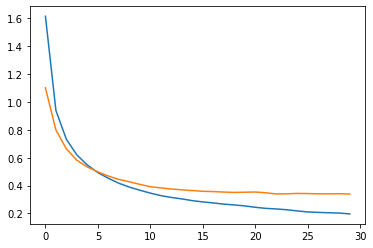

In [69]:
label_list = [tag_sequencer.idx2word[i] for i in range(len(tag_sequencer.idx2word))]

print(label_list)
train_true, train_pred, val_true, val_pred = run_training(lstm_clf, optimizer, loss_function, train_loader, val_loader, device, label_list, n_epochs=30)

['<unk>', '<pad>', '<s>', '</s>', 'O', 'B_language', 'B_director', 'I_director', 'B_subject', 'I_subject', 'B_mpaa_rating', 'B_movie', 'I_movie', 'B_person', 'I_person', 'B_producer', 'B_country', 'B_cast', 'I_cast', 'I_country', 'I_language', 'B_genre', 'I_producer', 'B_release_year', 'I_release_year', 'B_char', 'I_char', 'I_mpaa_rating', 'I-movie', 'I_genre', 'B_location']
SimpleLSTMTagger(
  (embedding): Embedding(302870, 300)
  (rnn): LSTM(300, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=100, out_features=31, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
CrossEntropyLoss()


0it [00:00, ?it/s]

Running loss:  0.9662039279937744
Running loss:  0.9115779978213928
Epoch completed!
Epoch Loss:  0.8684204178498993
Epoch Perplexity:  2.3831435079454018
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00       105
        char       0.00      0.00      0.00        15
     country       0.00      0.00      0.00       154
    director       0.00      0.00      0.00       180
       genre       0.00      0.00      0.00        71
    language       0.00      0.00      0.00       119
    location       0.00      0.00      0.00         2
       movie       0.28      0.34      0.31       989
 mpaa-rating       0.00      0.00      0.00       140
      person       0.00      0.00      0.00       177
    producer       0.00      0.00      0.00       164
release-year       0.00      0.00      0.00         4
     subject       0.00      0.00      0.00        95

   micro avg       0.28      0.15      0.20      2215
   macro avg       0.02      0.03

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0it [00:00, ?it/s]

Evaluation Loss:  0.7127415140469869
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.00      0.00      0.00        11
    director       0.00      0.00      0.00        15
       genre       0.00      0.00      0.00         5
    language       0.00      0.00      0.00        15
       movie       0.38      0.51      0.44       100
 mpaa-rating       0.00      0.00      0.00        15
      person       0.00      0.00      0.00        15
    producer       0.00      0.00      0.00        26
     subject       0.00      0.00      0.00         3

   micro avg       0.38      0.24      0.29       216
   macro avg       0.04      0.05      0.04       216
weighted avg       0.18      0.24      0.20       216



0it [00:00, ?it/s]

Running loss:  0.6514907479286194
Running loss:  0.6984233266056172
Epoch completed!
Epoch Loss:  0.6748442535704755
Epoch Perplexity:  1.96372710866586
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00       105
        char       0.00      0.00      0.00        15
     country       0.50      0.01      0.01       154
    director       0.00      0.00      0.00       180
       genre       0.00      0.00      0.00        71
    language       0.00      0.00      0.00       119
    location       0.00      0.00      0.00         2
       movie       0.42      0.59      0.49       989
 mpaa-rating       0.58      0.20      0.30       140
      person       0.05      0.01      0.01       177
    producer       0.07      0.02      0.03       164
release-year       0.00      0.00      0.00         4
     subject       0.00      0.00      0.00        95

   micro avg       0.41      0.28      0.33      2215
   macro avg       0.13      0.06  

0it [00:00, ?it/s]

Evaluation Loss:  0.5766138871510822
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.00      0.00      0.00        11
    director       0.00      0.00      0.00        15
       genre       0.00      0.00      0.00         5
    language       0.00      0.00      0.00        15
       movie       0.54      0.68      0.60       100
 mpaa-rating       0.67      0.27      0.38        15
      person       0.00      0.00      0.00        15
    producer       0.09      0.08      0.08        26
     subject       0.00      0.00      0.00         3

   micro avg       0.48      0.34      0.40       216
   macro avg       0.13      0.10      0.11       216
weighted avg       0.31      0.34      0.32       216



0it [00:00, ?it/s]

Running loss:  0.5201659798622131
Running loss:  0.5943623725140448
Epoch completed!
Epoch Loss:  0.5787655351855232
Epoch Perplexity:  1.7838349894651968
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00       105
        char       0.00      0.00      0.00        15
     country       0.16      0.02      0.03       154
    director       0.00      0.00      0.00       180
       genre       0.00      0.00      0.00        71
    language       0.66      0.45      0.53       119
    location       0.00      0.00      0.00         2
       movie       0.55      0.66      0.60       989
 mpaa-rating       0.38      0.29      0.33       140
      person       0.06      0.01      0.02       177
    producer       0.07      0.04      0.05       164
release-year       0.00      0.00      0.00         4
     subject       0.49      0.18      0.26        95

   micro avg       0.49      0.35      0.41      2215
   macro avg       0.18      0.13

0it [00:00, ?it/s]

Evaluation Loss:  0.5039100845654805
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.00      0.00      0.00        11
    director       0.00      0.00      0.00        15
       genre       0.00      0.00      0.00         5
    language       0.71      0.80      0.75        15
       movie       0.74      0.74      0.74       100
 mpaa-rating       0.67      0.27      0.38        15
      person       0.00      0.00      0.00        15
    producer       0.28      0.27      0.27        26
     subject       0.00      0.00      0.00         3

   micro avg       0.63      0.45      0.52       216
   macro avg       0.24      0.21      0.21       216
weighted avg       0.47      0.45      0.45       216



0it [00:00, ?it/s]

Running loss:  0.42929908633232117
Running loss:  0.5252179720319143
Epoch completed!
Epoch Loss:  0.5132607499547038
Epoch Perplexity:  1.6707301558610128
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00       105
        char       0.00      0.00      0.00        15
     country       0.20      0.06      0.10       154
    director       0.01      0.01      0.01       180
       genre       1.00      0.08      0.16        71
    language       0.56      0.73      0.64       119
    location       0.00      0.00      0.00         2
       movie       0.62      0.68      0.65       989
 mpaa-rating       0.58      0.28      0.38       140
      person       0.05      0.01      0.02       177
    producer       0.12      0.10      0.11       164
release-year       0.00      0.00      0.00         4
     subject       0.48      0.49      0.49        95

   micro avg       0.51      0.40      0.45      2215
   macro avg       0.28      0.1

0it [00:00, ?it/s]

Evaluation Loss:  0.4489013532797495
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       1.00      0.09      0.17        11
    director       0.00      0.00      0.00        15
       genre       1.00      0.20      0.33         5
    language       0.81      0.87      0.84        15
       movie       0.80      0.85      0.83       100
 mpaa-rating       0.67      0.27      0.38        15
      person       0.00      0.00      0.00        15
    producer       0.22      0.31      0.26        26
     subject       0.14      0.33      0.20         3

   micro avg       0.63      0.52      0.57       216
   macro avg       0.46      0.29      0.30       216
weighted avg       0.58      0.52      0.52       216



0it [00:00, ?it/s]

Running loss:  0.3733227550983429
Running loss:  0.4759608769770896
Epoch completed!
Epoch Loss:  0.4660325352604508
Epoch Perplexity:  1.5936588486107248
              precision    recall  f1-score   support

        cast       0.05      0.01      0.02       105
        char       0.00      0.00      0.00        15
     country       0.28      0.16      0.20       154
    director       0.03      0.02      0.02       180
       genre       0.89      0.44      0.58        71
    language       0.65      0.81      0.72       119
    location       0.00      0.00      0.00         2
       movie       0.72      0.74      0.73       989
 mpaa-rating       0.75      0.29      0.41       140
      person       0.03      0.01      0.02       177
    producer       0.13      0.12      0.12       164
release-year       0.00      0.00      0.00         4
     subject       0.66      0.81      0.73        95

   micro avg       0.56      0.46      0.51      2215
   macro avg       0.32      0.26

0it [00:00, ?it/s]

Evaluation Loss:  0.40910978317260743
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.50      0.09      0.15        11
    director       0.00      0.00      0.00        15
       genre       1.00      0.60      0.75         5
    language       0.87      0.87      0.87        15
       movie       0.79      0.79      0.79       100
 mpaa-rating       0.67      0.27      0.38        15
      person       0.00      0.00      0.00        15
    producer       0.32      0.38      0.35        26
     subject       0.50      1.00      0.67         3

   micro avg       0.63      0.52      0.57       216
   macro avg       0.46      0.40      0.40       216
weighted avg       0.57      0.52      0.53       216



0it [00:00, ?it/s]

Running loss:  0.3245337903499603
Running loss:  0.43406897930815663
Epoch completed!
Epoch Loss:  0.4261192473325324
Epoch Perplexity:  1.531303368088112
              precision    recall  f1-score   support

        cast       0.08      0.03      0.04       105
        char       0.00      0.00      0.00        15
     country       0.30      0.18      0.22       154
    director       0.06      0.07      0.06       180
       genre       0.88      0.70      0.78        71
    language       0.68      0.82      0.75       119
    location       0.00      0.00      0.00         2
       movie       0.74      0.76      0.75       989
 mpaa-rating       0.80      0.29      0.42       140
      person       0.07      0.03      0.05       177
    producer       0.22      0.21      0.21       164
release-year       0.00      0.00      0.00         4
     subject       0.69      0.86      0.77        95

   micro avg       0.56      0.50      0.53      2215
   macro avg       0.35      0.30

0it [00:00, ?it/s]

Evaluation Loss:  0.37492130796114603
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.25      0.09      0.13        11
    director       0.00      0.00      0.00        15
       genre       0.75      0.60      0.67         5
    language       0.87      0.87      0.87        15
       movie       0.85      0.88      0.87       100
 mpaa-rating       0.83      0.33      0.48        15
      person       0.17      0.07      0.10        15
    producer       0.38      0.42      0.40        26
     subject       0.60      1.00      0.75         3

   micro avg       0.64      0.58      0.61       216
   macro avg       0.47      0.43      0.43       216
weighted avg       0.61      0.58      0.58       216



0it [00:00, ?it/s]

Running loss:  0.2996513843536377
Running loss:  0.4000605934917336
Epoch completed!
Epoch Loss:  0.39216533958489175
Epoch Perplexity:  1.4801824239189327
              precision    recall  f1-score   support

        cast       0.12      0.06      0.08       105
        char       0.00      0.00      0.00        15
     country       0.41      0.23      0.30       154
    director       0.12      0.16      0.14       180
       genre       0.91      0.82      0.86        71
    language       0.77      0.90      0.83       119
    location       0.00      0.00      0.00         2
       movie       0.78      0.78      0.78       989
 mpaa-rating       0.94      0.34      0.49       140
      person       0.08      0.05      0.06       177
    producer       0.26      0.26      0.26       164
release-year       0.00      0.00      0.00         4
     subject       0.76      0.92      0.83        95

   micro avg       0.59      0.54      0.56      2215
   macro avg       0.39      0.3

0it [00:00, ?it/s]

Evaluation Loss:  0.34310207168261214
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.25      0.09      0.13        11
    director       0.00      0.00      0.00        15
       genre       1.00      0.80      0.89         5
    language       0.81      0.87      0.84        15
       movie       0.86      0.86      0.86       100
 mpaa-rating       1.00      0.40      0.57        15
      person       0.10      0.07      0.08        15
    producer       0.35      0.42      0.39        26
     subject       0.60      1.00      0.75         3

   micro avg       0.62      0.58      0.60       216
   macro avg       0.50      0.45      0.45       216
weighted avg       0.62      0.58      0.59       216



0it [00:00, ?it/s]

Running loss:  0.29576653242111206
Running loss:  0.3715863390134112
Epoch completed!
Epoch Loss:  0.36523283088038155
Epoch Perplexity:  1.4408494433422567
              precision    recall  f1-score   support

        cast       0.13      0.07      0.09       105
        char       0.00      0.00      0.00        15
     country       0.50      0.27      0.35       154
    director       0.20      0.28      0.23       180
       genre       0.80      0.86      0.83        71
    language       0.81      0.88      0.84       119
    location       0.00      0.00      0.00         2
       movie       0.79      0.79      0.79       989
 mpaa-rating       0.98      0.35      0.52       140
      person       0.09      0.07      0.08       177
    producer       0.30      0.29      0.30       164
release-year       0.00      0.00      0.00         4
     subject       0.78      0.94      0.85        95

   micro avg       0.61      0.56      0.58      2215
   macro avg       0.41      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.3189860244592031
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.00      0.00      0.00        11
     country       0.25      0.09      0.13        11
    director       0.00      0.00      0.00        15
       genre       1.00      0.80      0.89         5
    language       0.80      0.80      0.80        15
       movie       0.87      0.88      0.88       100
 mpaa-rating       1.00      0.40      0.57        15
      person       0.08      0.07      0.07        15
    producer       0.35      0.42      0.39        26
     subject       0.60      1.00      0.75         3

   micro avg       0.61      0.58      0.60       216
   macro avg       0.50      0.45      0.45       216
weighted avg       0.62      0.58      0.59       216



0it [00:00, ?it/s]

Running loss:  0.2809094190597534
Running loss:  0.3529333990104128
Epoch completed!
Epoch Loss:  0.3458260677173628
Epoch Perplexity:  1.4131568008526212
              precision    recall  f1-score   support

        cast       0.10      0.07      0.08       105
        char       0.00      0.00      0.00        15
     country       0.58      0.30      0.39       154
    director       0.19      0.30      0.23       180
       genre       0.94      0.86      0.90        71
    language       0.82      0.90      0.86       119
    location       0.00      0.00      0.00         2
       movie       0.79      0.80      0.80       989
 mpaa-rating       1.00      0.36      0.53       140
      person       0.09      0.07      0.08       177
    producer       0.30      0.30      0.30       164
release-year       0.00      0.00      0.00         4
     subject       0.83      0.96      0.89        95

   micro avg       0.60      0.58      0.59      2215
   macro avg       0.43      0.38

0it [00:00, ?it/s]

Evaluation Loss:  0.3012816568215689
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.12      0.09      0.11        11
     country       0.67      0.18      0.29        11
    director       0.00      0.00      0.00        15
       genre       1.00      0.80      0.89         5
    language       0.86      0.80      0.83        15
       movie       0.88      0.88      0.88       100
 mpaa-rating       0.86      0.40      0.55        15
      person       0.07      0.07      0.07        15
    producer       0.31      0.42      0.36        26
     subject       0.75      1.00      0.86         3

   micro avg       0.62      0.59      0.61       216
   macro avg       0.55      0.46      0.48       216
weighted avg       0.64      0.59      0.60       216



0it [00:00, ?it/s]

Running loss:  0.26803433895111084
Running loss:  0.3341800219351703
Epoch completed!
Epoch Loss:  0.3294836021695577
Epoch Perplexity:  1.3902500209705608
              precision    recall  f1-score   support

        cast       0.17      0.12      0.14       105
        char       0.00      0.00      0.00        15
     country       0.71      0.41      0.52       154
    director       0.20      0.32      0.24       180
       genre       0.86      0.89      0.88        71
    language       0.83      0.87      0.85       119
    location       0.00      0.00      0.00         2
       movie       0.79      0.80      0.79       989
 mpaa-rating       0.96      0.38      0.54       140
      person       0.15      0.12      0.13       177
    producer       0.32      0.32      0.32       164
release-year       0.00      0.00      0.00         4
     subject       0.87      0.96      0.91        95

   micro avg       0.62      0.59      0.60      2215
   macro avg       0.45      0.4

0it [00:00, ?it/s]

Evaluation Loss:  0.288780802488327
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.12      0.09      0.11        11
     country       0.67      0.18      0.29        11
    director       0.05      0.07      0.06        15
       genre       0.80      0.80      0.80         5
    language       0.86      0.80      0.83        15
       movie       0.88      0.84      0.86       100
 mpaa-rating       0.86      0.40      0.55        15
      person       0.06      0.07      0.06        15
    producer       0.34      0.42      0.38        26
     subject       1.00      1.00      1.00         3

   micro avg       0.61      0.58      0.60       216
   macro avg       0.56      0.47      0.49       216
weighted avg       0.65      0.58      0.60       216



0it [00:00, ?it/s]

Running loss:  0.23376980423927307
Running loss:  0.3172775000923929
Epoch completed!
Epoch Loss:  0.3138260304505096
Epoch Perplexity:  1.3686516121304058
              precision    recall  f1-score   support

        cast       0.23      0.15      0.18       105
        char       0.00      0.00      0.00        15
     country       0.77      0.49      0.60       154
    director       0.21      0.34      0.26       180
       genre       0.85      0.87      0.86        71
    language       0.86      0.87      0.86       119
    location       0.00      0.00      0.00         2
       movie       0.81      0.82      0.82       989
 mpaa-rating       0.96      0.37      0.54       140
      person       0.17      0.15      0.16       177
    producer       0.35      0.30      0.32       164
release-year       0.00      0.00      0.00         4
     subject       0.90      0.96      0.93        95

   micro avg       0.64      0.61      0.62      2215
   macro avg       0.47      0.4

0it [00:00, ?it/s]

Evaluation Loss:  0.2774634271860122
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.22      0.18      0.20        11
     country       0.83      0.45      0.59        11
    director       0.04      0.07      0.05        15
       genre       1.00      0.80      0.89         5
    language       0.86      0.80      0.83        15
       movie       0.90      0.89      0.89       100
 mpaa-rating       0.86      0.40      0.55        15
      person       0.09      0.07      0.08        15
    producer       0.32      0.42      0.37        26
     subject       0.75      1.00      0.86         3

   micro avg       0.64      0.62      0.63       216
   macro avg       0.59      0.51      0.53       216
weighted avg       0.67      0.62      0.64       216



0it [00:00, ?it/s]

Running loss:  0.24493728578090668
Running loss:  0.3028312849231284
Epoch completed!
Epoch Loss:  0.29805081723429616
Epoch Perplexity:  1.3472302486552425
              precision    recall  f1-score   support

        cast       0.23      0.20      0.21       105
        char       0.00      0.00      0.00        15
     country       0.81      0.54      0.65       154
    director       0.26      0.39      0.31       180
       genre       0.90      0.90      0.90        71
    language       0.84      0.87      0.86       119
    location       0.00      0.00      0.00         2
       movie       0.81      0.83      0.82       989
 mpaa-rating       0.94      0.49      0.64       140
      person       0.23      0.19      0.21       177
    producer       0.35      0.32      0.33       164
release-year       0.00      0.00      0.00         4
     subject       0.96      0.97      0.96        95

   micro avg       0.65      0.64      0.65      2215
   macro avg       0.49      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.2621938576300939
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.08      0.09      0.08        11
     country       0.80      0.36      0.50        11
    director       0.15      0.20      0.17        15
       genre       0.80      0.80      0.80         5
    language       0.86      0.80      0.83        15
       movie       0.90      0.90      0.90       100
 mpaa-rating       0.86      0.40      0.55        15
      person       0.18      0.13      0.15        15
    producer       0.35      0.46      0.40        26
     subject       1.00      1.00      1.00         3

   micro avg       0.65      0.63      0.64       216
   macro avg       0.60      0.51      0.54       216
weighted avg       0.68      0.63      0.64       216



0it [00:00, ?it/s]

Running loss:  0.25254708528518677
Running loss:  0.2904356449547381
Epoch completed!
Epoch Loss:  0.2862532339620252
Epoch Perplexity:  1.3314295757519354
              precision    recall  f1-score   support

        cast       0.23      0.24      0.23       105
        char       0.00      0.00      0.00        15
     country       0.82      0.62      0.70       154
    director       0.28      0.44      0.34       180
       genre       0.89      0.92      0.90        71
    language       0.88      0.87      0.87       119
    location       0.00      0.00      0.00         2
       movie       0.82      0.83      0.83       989
 mpaa-rating       0.95      0.55      0.70       140
      person       0.26      0.23      0.24       177
    producer       0.40      0.30      0.34       164
release-year       0.00      0.00      0.00         4
     subject       0.95      0.96      0.95        95

   micro avg       0.67      0.65      0.66      2215
   macro avg       0.50      0.4

0it [00:00, ?it/s]

Evaluation Loss:  0.25177814066410065
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.23      0.27      0.25        11
     country       1.00      0.55      0.71        11
    director       0.16      0.20      0.18        15
       genre       1.00      0.80      0.89         5
    language       0.87      0.87      0.87        15
       movie       0.90      0.90      0.90       100
 mpaa-rating       0.89      0.53      0.67        15
      person       0.33      0.27      0.30        15
    producer       0.39      0.46      0.42        26
     subject       1.00      1.00      1.00         3

   micro avg       0.69      0.68      0.68       216
   macro avg       0.68      0.58      0.62       216
weighted avg       0.72      0.68      0.69       216



0it [00:00, ?it/s]

Running loss:  0.23691660165786743
Running loss:  0.27834220628927253
Epoch completed!
Epoch Loss:  0.27491289995452206
Epoch Perplexity:  1.3164160099796984
              precision    recall  f1-score   support

        cast       0.23      0.30      0.26       105
        char       0.00      0.00      0.00        15
     country       0.85      0.60      0.70       154
    director       0.34      0.49      0.40       180
       genre       0.90      0.93      0.92        71
    language       0.87      0.87      0.87       119
    location       0.00      0.00      0.00         2
       movie       0.82      0.84      0.83       989
 mpaa-rating       0.93      0.59      0.72       140
      person       0.30      0.28      0.29       177
    producer       0.49      0.37      0.42       164
release-year       1.00      0.25      0.40         4
     subject       0.96      0.96      0.96        95

   micro avg       0.69      0.67      0.68      2215
   macro avg       0.59      0

0it [00:00, ?it/s]

Evaluation Loss:  0.2419987847407659
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.24      0.36      0.29        11
     country       1.00      0.55      0.71        11
    director       0.31      0.27      0.29        15
       genre       1.00      0.80      0.89         5
    language       0.87      0.87      0.87        15
       movie       0.90      0.88      0.89       100
 mpaa-rating       0.80      0.53      0.64        15
      person       0.42      0.33      0.37        15
    producer       0.73      0.73      0.73        26
     subject       1.00      1.00      1.00         3

   micro avg       0.75      0.71      0.73       216
   macro avg       0.73      0.63      0.67       216
weighted avg       0.77      0.71      0.73       216



0it [00:00, ?it/s]

Running loss:  0.233558788895607
Running loss:  0.2682933152312099
Epoch completed!
Epoch Loss:  0.26532366829560994
Epoch Perplexity:  1.303852923342585
              precision    recall  f1-score   support

        cast       0.30      0.36      0.33       105
        char       1.00      0.07      0.12        15
     country       0.85      0.61      0.71       154
    director       0.33      0.44      0.38       180
       genre       0.86      0.92      0.88        71
    language       0.89      0.87      0.88       119
    location       0.00      0.00      0.00         2
       movie       0.83      0.85      0.84       989
 mpaa-rating       0.97      0.61      0.75       140
      person       0.33      0.31      0.32       177
    producer       0.54      0.41      0.47       164
release-year       0.00      0.00      0.00         4
     subject       0.97      0.96      0.96        95

   micro avg       0.70      0.69      0.69      2215
   macro avg       0.60      0.49 

0it [00:00, ?it/s]

Evaluation Loss:  0.23098204334576924
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.36      0.36      0.36        11
     country       1.00      0.55      0.71        11
    director       0.33      0.40      0.36        15
       genre       1.00      0.80      0.89         5
    language       0.87      0.87      0.87        15
       movie       0.93      0.89      0.91       100
 mpaa-rating       0.89      0.53      0.67        15
      person       0.36      0.33      0.34        15
    producer       0.77      0.65      0.71        26
     subject       1.00      1.00      1.00         3

   micro avg       0.78      0.72      0.75       216
   macro avg       0.75      0.64      0.68       216
weighted avg       0.80      0.72      0.75       216



0it [00:00, ?it/s]

Running loss:  0.2296801656484604
Running loss:  0.2574341991307712
Epoch completed!
Epoch Loss:  0.2538701687932859
Epoch Perplexity:  1.289004440401556
              precision    recall  f1-score   support

        cast       0.33      0.38      0.35       105
        char       0.00      0.00      0.00        15
     country       0.83      0.58      0.69       154
    director       0.42      0.55      0.48       180
       genre       0.92      0.93      0.92        71
    language       0.82      0.86      0.84       119
    location       0.00      0.00      0.00         2
       movie       0.83      0.85      0.84       989
 mpaa-rating       0.96      0.64      0.76       140
      person       0.38      0.34      0.36       177
    producer       0.64      0.48      0.55       164
release-year       0.33      0.25      0.29         4
     subject       0.97      0.96      0.96        95

   micro avg       0.73      0.70      0.71      2215
   macro avg       0.57      0.52 

0it [00:00, ?it/s]

Evaluation Loss:  0.22461403608322145
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.31      0.45      0.37        11
     country       1.00      0.55      0.71        11
    director       0.27      0.20      0.23        15
       genre       1.00      0.80      0.89         5
    language       0.87      0.87      0.87        15
       movie       0.89      0.90      0.90       100
 mpaa-rating       0.80      0.53      0.64        15
      person       0.42      0.33      0.37        15
    producer       0.63      0.85      0.72        26
     subject       1.00      1.00      1.00         3

   micro avg       0.75      0.74      0.74       216
   macro avg       0.72      0.65      0.67       216
weighted avg       0.76      0.74      0.74       216



0it [00:00, ?it/s]

Running loss:  0.23151953518390656
Running loss:  0.2488675763701449
Epoch completed!
Epoch Loss:  0.2459912430627126
Epoch Perplexity:  1.2788883743474113
              precision    recall  f1-score   support

        cast       0.31      0.41      0.35       105
        char       0.50      0.13      0.21        15
     country       0.89      0.61      0.72       154
    director       0.46      0.55      0.50       180
       genre       0.92      0.93      0.92        71
    language       0.88      0.88      0.88       119
    location       0.00      0.00      0.00         2
       movie       0.84      0.85      0.85       989
 mpaa-rating       0.94      0.64      0.76       140
      person       0.41      0.38      0.39       177
    producer       0.67      0.52      0.59       164
release-year       0.50      0.25      0.33         4
     subject       0.97      0.96      0.96        95

   micro avg       0.74      0.71      0.73      2215
   macro avg       0.64      0.5

0it [00:00, ?it/s]

Evaluation Loss:  0.21479101578394572
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.42      0.45      0.43        11
     country       1.00      0.55      0.71        11
    director       0.55      0.40      0.46        15
       genre       0.80      0.80      0.80         5
    language       0.81      0.87      0.84        15
       movie       0.90      0.94      0.92       100
 mpaa-rating       0.89      0.53      0.67        15
      person       0.38      0.33      0.36        15
    producer       0.68      0.81      0.74        26
     subject       1.00      1.00      1.00         3

   micro avg       0.79      0.76      0.77       216
   macro avg       0.74      0.67      0.69       216
weighted avg       0.79      0.76      0.77       216



0it [00:00, ?it/s]

Running loss:  0.18271875381469727
Running loss:  0.24228771503018862
Epoch completed!
Epoch Loss:  0.2388186038385892
Epoch Perplexity:  1.26974818824501
              precision    recall  f1-score   support

        cast       0.35      0.45      0.39       105
        char       0.60      0.20      0.30        15
     country       0.84      0.61      0.71       154
    director       0.48      0.59      0.53       180
       genre       0.93      0.94      0.94        71
    language       0.86      0.87      0.86       119
    location       0.00      0.00      0.00         2
       movie       0.84      0.86      0.85       989
 mpaa-rating       0.93      0.65      0.76       140
      person       0.46      0.43      0.44       177
    producer       0.72      0.51      0.60       164
release-year       0.50      0.25      0.33         4
     subject       0.97      0.96      0.96        95

   micro avg       0.75      0.73      0.74      2215
   macro avg       0.65      0.56

0it [00:00, ?it/s]

Evaluation Loss:  0.20851410428682965
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.36      0.36      0.36        11
     country       1.00      0.55      0.71        11
    director       0.53      0.60      0.56        15
       genre       0.80      0.80      0.80         5
    language       0.81      0.87      0.84        15
       movie       0.93      0.93      0.93       100
 mpaa-rating       0.80      0.53      0.64        15
      person       0.54      0.47      0.50        15
    producer       0.83      0.73      0.78        26
     subject       1.00      1.00      1.00         3

   micro avg       0.81      0.77      0.79       216
   macro avg       0.76      0.68      0.71       216
weighted avg       0.82      0.77      0.79       216



0it [00:00, ?it/s]

Running loss:  0.22128058969974518
Running loss:  0.23644208893327429
Epoch completed!
Epoch Loss:  0.23388358987603627
Epoch Perplexity:  1.2634973997574852
              precision    recall  f1-score   support

        cast       0.30      0.39      0.34       105
        char       0.67      0.27      0.38        15
     country       0.84      0.61      0.71       154
    director       0.51      0.59      0.55       180
       genre       0.94      0.93      0.94        71
    language       0.86      0.87      0.86       119
    location       0.00      0.00      0.00         2
       movie       0.83      0.84      0.84       989
 mpaa-rating       0.90      0.67      0.77       140
      person       0.50      0.46      0.48       177
    producer       0.77      0.54      0.63       164
release-year       0.50      0.25      0.33         4
     subject       0.96      0.96      0.96        95

   micro avg       0.75      0.72      0.74      2215
   macro avg       0.66      0

0it [00:00, ?it/s]

Evaluation Loss:  0.2049928332368533
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.33      0.36      0.35        11
     country       1.00      0.55      0.71        11
    director       0.67      0.53      0.59        15
       genre       0.80      0.80      0.80         5
    language       0.81      0.87      0.84        15
       movie       0.91      0.93      0.92       100
 mpaa-rating       0.89      0.53      0.67        15
      person       0.67      0.53      0.59        15
    producer       0.72      0.81      0.76        26
     subject       1.00      1.00      1.00         3

   micro avg       0.82      0.78      0.80       216
   macro avg       0.78      0.69      0.72       216
weighted avg       0.82      0.78      0.79       216



0it [00:00, ?it/s]

Running loss:  0.20705772936344147
Running loss:  0.22701871166429902
Epoch completed!
Epoch Loss:  0.22460642235076173
Epoch Perplexity:  1.2518299269429163
              precision    recall  f1-score   support

        cast       0.35      0.44      0.39       105
        char       0.71      0.33      0.45        15
     country       0.82      0.64      0.72       154
    director       0.53      0.60      0.56       180
       genre       0.92      0.92      0.92        71
    language       0.88      0.87      0.88       119
    location       0.00      0.00      0.00         2
       movie       0.85      0.86      0.85       989
 mpaa-rating       0.96      0.67      0.79       140
      person       0.51      0.49      0.50       177
    producer       0.77      0.58      0.66       164
release-year       0.50      0.25      0.33         4
     subject       0.97      0.96      0.96        95

   micro avg       0.77      0.74      0.76      2215
   macro avg       0.68      0

0it [00:00, ?it/s]

Evaluation Loss:  0.1972383732597033
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.45      0.45      0.45        11
     country       1.00      0.55      0.71        11
    director       0.50      0.53      0.52        15
       genre       0.80      0.80      0.80         5
    language       0.81      0.87      0.84        15
       movie       0.92      0.92      0.92       100
 mpaa-rating       1.00      0.53      0.70        15
      person       0.67      0.53      0.59        15
    producer       0.80      0.77      0.78        26
     subject       1.00      1.00      1.00         3

   micro avg       0.83      0.77      0.80       216
   macro avg       0.80      0.70      0.73       216
weighted avg       0.84      0.77      0.80       216



0it [00:00, ?it/s]

Running loss:  0.18542443215847015
Running loss:  0.22335855766098103
Epoch completed!
Epoch Loss:  0.22114777522729653
Epoch Perplexity:  1.2475077676874236
              precision    recall  f1-score   support

        cast       0.34      0.42      0.37       105
        char       0.71      0.33      0.45        15
     country       0.83      0.65      0.73       154
    director       0.50      0.59      0.55       180
       genre       0.93      0.94      0.94        71
    language       0.90      0.88      0.89       119
    location       0.00      0.00      0.00         2
       movie       0.86      0.86      0.86       989
 mpaa-rating       0.93      0.68      0.79       140
      person       0.51      0.49      0.50       177
    producer       0.75      0.57      0.65       164
release-year       1.00      0.50      0.67         4
     subject       0.97      0.96      0.96        95

   micro avg       0.77      0.75      0.76      2215
   macro avg       0.71      0

0it [00:00, ?it/s]

Evaluation Loss:  0.19315161059300107
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.36      0.45      0.40        11
     country       1.00      0.55      0.71        11
    director       0.62      0.53      0.57        15
       genre       0.80      0.80      0.80         5
    language       0.81      0.87      0.84        15
       movie       0.91      0.92      0.92       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.67      0.53      0.59        15
    producer       0.74      0.77      0.75        26
     subject       1.00      1.00      1.00         3

   micro avg       0.82      0.78      0.80       216
   macro avg       0.79      0.70      0.73       216
weighted avg       0.83      0.78      0.79       216



0it [00:00, ?it/s]

Running loss:  0.19964352250099182
Running loss:  0.2180534600473866
Epoch completed!
Epoch Loss:  0.21455418175839355
Epoch Perplexity:  1.23930926711071
              precision    recall  f1-score   support

        cast       0.35      0.42      0.38       105
        char       0.71      0.33      0.45        15
     country       0.85      0.69      0.76       154
    director       0.54      0.64      0.59       180
       genre       0.97      0.96      0.96        71
    language       0.90      0.87      0.89       119
    location       0.00      0.00      0.00         2
       movie       0.84      0.86      0.85       989
 mpaa-rating       0.96      0.71      0.82       140
      person       0.60      0.55      0.58       177
    producer       0.82      0.57      0.67       164
release-year       1.00      0.50      0.67         4
     subject       0.97      0.97      0.97        95

   micro avg       0.78      0.76      0.77      2215
   macro avg       0.73      0.62

0it [00:00, ?it/s]

Evaluation Loss:  0.18671192725499472
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.42      0.45      0.43        11
     country       1.00      0.73      0.84        11
    director       0.50      0.60      0.55        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.92      0.92      0.92       100
 mpaa-rating       1.00      0.67      0.80        15
      person       0.67      0.53      0.59        15
    producer       0.86      0.73      0.79        26
     subject       1.00      1.00      1.00         3

   micro avg       0.84      0.79      0.81       216
   macro avg       0.81      0.73      0.76       216
weighted avg       0.85      0.79      0.82       216



0it [00:00, ?it/s]

Running loss:  0.18498247861862183
Running loss:  0.21392769897633265
Epoch completed!
Epoch Loss:  0.21008993695813719
Epoch Perplexity:  1.2337890181983249
              precision    recall  f1-score   support

        cast       0.34      0.41      0.37       105
        char       0.86      0.40      0.55        15
     country       0.83      0.68      0.75       154
    director       0.55      0.64      0.59       180
       genre       0.94      0.93      0.94        71
    language       0.90      0.88      0.89       119
    location       0.00      0.00      0.00         2
       movie       0.85      0.86      0.86       989
 mpaa-rating       0.92      0.69      0.79       140
      person       0.55      0.53      0.54       177
    producer       0.79      0.58      0.67       164
release-year       1.00      0.50      0.67         4
     subject       0.97      0.97      0.97        95

   micro avg       0.78      0.75      0.77      2215
   macro avg       0.73      0

0it [00:00, ?it/s]

Evaluation Loss:  0.18181242793798447
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.33      0.45      0.38        11
     country       0.89      0.73      0.80        11
    director       0.50      0.60      0.55        15
       genre       0.80      0.80      0.80         5
    language       0.81      0.87      0.84        15
       movie       0.94      0.93      0.93       100
 mpaa-rating       0.90      0.60      0.72        15
      person       0.73      0.53      0.62        15
    producer       0.95      0.73      0.83        26
     subject       1.00      1.00      1.00         3

   micro avg       0.83      0.79      0.81       216
   macro avg       0.79      0.72      0.75       216
weighted avg       0.85      0.79      0.81       216



0it [00:00, ?it/s]

Running loss:  0.20273755490779877
Running loss:  0.20871115807849594
Epoch completed!
Epoch Loss:  0.2064602776357891
Epoch Perplexity:  1.2293189017940507
              precision    recall  f1-score   support

        cast       0.36      0.42      0.39       105
        char       0.89      0.53      0.67        15
     country       0.80      0.67      0.73       154
    director       0.58      0.64      0.61       180
       genre       0.97      0.94      0.96        71
    language       0.89      0.89      0.89       119
    location       0.00      0.00      0.00         2
       movie       0.86      0.87      0.86       989
 mpaa-rating       0.92      0.69      0.79       140
      person       0.57      0.55      0.56       177
    producer       0.83      0.59      0.69       164
release-year       1.00      0.50      0.67         4
     subject       0.96      0.97      0.96        95

   micro avg       0.79      0.76      0.77      2215
   macro avg       0.74      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.18001020203034082
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.42      0.45      0.43        11
     country       1.00      0.73      0.84        11
    director       0.47      0.60      0.53        15
       genre       0.80      0.80      0.80         5
    language       0.81      0.87      0.84        15
       movie       0.92      0.94      0.93       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.67      0.53      0.59        15
    producer       0.95      0.73      0.83        26
     subject       1.00      1.00      1.00         3

   micro avg       0.83      0.80      0.82       216
   macro avg       0.80      0.73      0.75       216
weighted avg       0.85      0.80      0.82       216



0it [00:00, ?it/s]

Running loss:  0.16586504876613617
Running loss:  0.2037675320216925
Epoch completed!
Epoch Loss:  0.2001692218613539
Epoch Perplexity:  1.221609463697423
              precision    recall  f1-score   support

        cast       0.38      0.48      0.42       105
        char       0.88      0.47      0.61        15
     country       0.79      0.67      0.72       154
    director       0.56      0.62      0.58       180
       genre       0.96      0.94      0.95        71
    language       0.89      0.90      0.90       119
    location       0.00      0.00      0.00         2
       movie       0.86      0.88      0.87       989
 mpaa-rating       0.95      0.72      0.82       140
      person       0.56      0.56      0.56       177
    producer       0.81      0.58      0.67       164
release-year       0.50      0.25      0.33         4
     subject       0.97      0.97      0.97        95

   micro avg       0.78      0.77      0.78      2215
   macro avg       0.70      0.62

0it [00:00, ?it/s]

Evaluation Loss:  0.17531371911366778
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.33      0.45      0.38        11
     country       1.00      0.73      0.84        11
    director       0.47      0.60      0.53        15
       genre       0.80      0.80      0.80         5
    language       0.81      0.87      0.84        15
       movie       0.94      0.90      0.92       100
 mpaa-rating       0.90      0.60      0.72        15
      person       0.67      0.53      0.59        15
    producer       0.95      0.73      0.83        26
     subject       1.00      1.00      1.00         3

   micro avg       0.82      0.78      0.80       216
   macro avg       0.79      0.72      0.75       216
weighted avg       0.85      0.78      0.81       216



0it [00:00, ?it/s]

Running loss:  0.16173478960990906
Running loss:  0.19834124046091992
Epoch completed!
Epoch Loss:  0.19561464017164634
Epoch Perplexity:  1.2160581950517464
              precision    recall  f1-score   support

        cast       0.38      0.46      0.42       105
        char       0.83      0.67      0.74        15
     country       0.82      0.70      0.76       154
    director       0.58      0.64      0.61       180
       genre       0.94      0.94      0.94        71
    language       0.93      0.91      0.92       119
    location       0.00      0.00      0.00         2
       movie       0.88      0.88      0.88       989
 mpaa-rating       0.95      0.72      0.82       140
      person       0.58      0.59      0.59       177
    producer       0.79      0.58      0.67       164
release-year       1.00      0.50      0.67         4
     subject       0.98      0.97      0.97        95

   micro avg       0.80      0.78      0.79      2215
   macro avg       0.74      0

0it [00:00, ?it/s]

Evaluation Loss:  0.1720641002058983
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.38      0.45      0.42        11
     country       0.89      0.73      0.80        11
    director       0.53      0.67      0.59        15
       genre       0.80      0.80      0.80         5
    language       0.81      0.87      0.84        15
       movie       0.93      0.92      0.92       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.73      0.53      0.62        15
    producer       0.95      0.73      0.83        26
     subject       1.00      1.00      1.00         3

   micro avg       0.84      0.79      0.81       216
   macro avg       0.80      0.73      0.76       216
weighted avg       0.85      0.79      0.82       216



0it [00:00, ?it/s]

Running loss:  0.1550595611333847
Running loss:  0.19562976932761691
Epoch completed!
Epoch Loss:  0.1935151758874562
Epoch Perplexity:  1.213507802469598
              precision    recall  f1-score   support

        cast       0.39      0.44      0.41       105
        char       0.83      0.67      0.74        15
     country       0.83      0.69      0.76       154
    director       0.59      0.66      0.62       180
       genre       0.97      0.96      0.96        71
    language       0.88      0.87      0.88       119
    location       0.00      0.00      0.00         2
       movie       0.88      0.88      0.88       989
 mpaa-rating       0.94      0.71      0.81       140
      person       0.60      0.58      0.59       177
    producer       0.84      0.58      0.69       164
release-year       1.00      0.50      0.67         4
     subject       0.99      0.98      0.98        95

   micro avg       0.81      0.78      0.79      2215
   macro avg       0.75      0.66

0it [00:00, ?it/s]

Evaluation Loss:  0.1707881033420563
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.45      0.45      0.45        11
     country       1.00      0.91      0.95        11
    director       0.56      0.67      0.61        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.93      0.92      0.92       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.73      0.53      0.62        15
    producer       0.95      0.73      0.83        26
     subject       1.00      1.00      1.00         3

   micro avg       0.86      0.80      0.83       216
   macro avg       0.83      0.75      0.78       216
weighted avg       0.87      0.80      0.83       216



0it [00:00, ?it/s]

Running loss:  0.18799319863319397
Running loss:  0.19458919933231744
Epoch completed!
Epoch Loss:  0.19132632711994724
Epoch Perplexity:  1.2108545222856653
              precision    recall  f1-score   support

        cast       0.40      0.47      0.43       105
        char       0.90      0.60      0.72        15
     country       0.79      0.68      0.73       154
    director       0.62      0.68      0.65       180
       genre       0.94      0.92      0.93        71
    language       0.90      0.91      0.90       119
    location       0.00      0.00      0.00         2
       movie       0.87      0.88      0.88       989
 mpaa-rating       0.90      0.72      0.80       140
      person       0.57      0.56      0.56       177
    producer       0.79      0.59      0.67       164
release-year       1.00      0.50      0.67         4
     subject       0.97      0.97      0.97        95

   micro avg       0.80      0.78      0.79      2215
   macro avg       0.74      0

0it [00:00, ?it/s]

Evaluation Loss:  0.16882089922825497
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.42      0.45      0.43        11
     country       0.91      0.91      0.91        11
    director       0.53      0.60      0.56        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.92      0.93      0.93       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.67      0.53      0.59        15
    producer       0.95      0.77      0.85        26
     subject       1.00      1.00      1.00         3

   micro avg       0.85      0.81      0.83       216
   macro avg       0.81      0.75      0.77       216
weighted avg       0.86      0.81      0.83       216



0it [00:00, ?it/s]

Running loss:  0.15815383195877075
Running loss:  0.1908402420432851
Epoch completed!
Epoch Loss:  0.1889536627271075
Epoch Perplexity:  1.2079849764565196
              precision    recall  f1-score   support

        cast       0.45      0.50      0.47       105
        char       0.91      0.67      0.77        15
     country       0.76      0.69      0.72       154
    director       0.59      0.66      0.62       180
       genre       0.97      0.94      0.96        71
    language       0.91      0.89      0.90       119
    location       0.00      0.00      0.00         2
       movie       0.88      0.89      0.88       989
 mpaa-rating       0.91      0.71      0.80       140
      person       0.58      0.56      0.57       177
    producer       0.82      0.59      0.69       164
release-year       0.67      0.50      0.57         4
     subject       0.98      0.98      0.98        95

   micro avg       0.80      0.78      0.79      2215
   macro avg       0.72      0.6

0it [00:00, ?it/s]

Evaluation Loss:  0.16478434701760608
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.45      0.45      0.45        11
     country       1.00      0.91      0.95        11
    director       0.53      0.60      0.56        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.92      0.94      0.93       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.67      0.53      0.59        15
    producer       0.95      0.77      0.85        26
     subject       1.00      1.00      1.00         3

   micro avg       0.86      0.81      0.83       216
   macro avg       0.83      0.75      0.78       216
weighted avg       0.86      0.81      0.83       216



0it [00:00, ?it/s]

Running loss:  0.16583040356636047
Running loss:  0.1867635553278545
Epoch completed!
Epoch Loss:  0.18426987716386503
Epoch Perplexity:  1.2023402634951177
              precision    recall  f1-score   support

        cast       0.46      0.49      0.47       105
        char       0.92      0.73      0.81        15
     country       0.82      0.73      0.77       154
    director       0.63      0.68      0.66       180
       genre       0.99      0.96      0.97        71
    language       0.92      0.90      0.91       119
    location       0.00      0.00      0.00         2
       movie       0.88      0.88      0.88       989
 mpaa-rating       0.93      0.72      0.81       140
      person       0.62      0.59      0.60       177
    producer       0.78      0.59      0.67       164
release-year       1.00      0.50      0.67         4
     subject       1.00      0.99      0.99        95

   micro avg       0.82      0.79      0.80      2215
   macro avg       0.76      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.16394715259472528
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.42      0.45      0.43        11
     country       0.91      0.91      0.91        11
    director       0.53      0.60      0.56        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.92      0.94      0.93       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.62      0.53      0.57        15
    producer       0.95      0.77      0.85        26
     subject       1.00      1.00      1.00         3

   micro avg       0.85      0.81      0.83       216
   macro avg       0.81      0.75      0.77       216
weighted avg       0.85      0.81      0.83       216



0it [00:00, ?it/s]

Running loss:  0.15708020329475403
Running loss:  0.18480579082918638
Epoch completed!
Epoch Loss:  0.18308704925027294
Epoch Perplexity:  1.200918942624532
              precision    recall  f1-score   support

        cast       0.42      0.48      0.45       105
        char       0.92      0.80      0.86        15
     country       0.77      0.72      0.74       154
    director       0.63      0.70      0.66       180
       genre       0.97      0.96      0.96        71
    language       0.93      0.90      0.91       119
    location       0.00      0.00      0.00         2
       movie       0.87      0.88      0.88       989
 mpaa-rating       0.93      0.71      0.80       140
      person       0.59      0.57      0.58       177
    producer       0.82      0.59      0.69       164
release-year       1.00      0.50      0.67         4
     subject       0.99      0.98      0.98        95

   micro avg       0.81      0.78      0.80      2215
   macro avg       0.76      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.1631852815548579
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.42      0.45      0.43        11
     country       0.91      0.91      0.91        11
    director       0.53      0.60      0.56        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.94      0.92      0.93       100
 mpaa-rating       0.90      0.60      0.72        15
      person       0.62      0.53      0.57        15
    producer       0.95      0.77      0.85        26
     subject       1.00      1.00      1.00         3

   micro avg       0.85      0.80      0.82       216
   macro avg       0.80      0.75      0.77       216
weighted avg       0.86      0.80      0.82       216



0it [00:00, ?it/s]

Running loss:  0.144159734249115
Running loss:  0.1823871444431272
Epoch completed!
Epoch Loss:  0.17992658479839346
Epoch Perplexity:  1.197129472394027
              precision    recall  f1-score   support

        cast       0.44      0.50      0.47       105
        char       0.92      0.80      0.86        15
     country       0.77      0.73      0.75       154
    director       0.64      0.69      0.66       180
       genre       0.96      0.96      0.96        71
    language       0.92      0.87      0.90       119
    location       0.00      0.00      0.00         2
       movie       0.87      0.89      0.88       989
 mpaa-rating       0.94      0.72      0.81       140
      person       0.61      0.60      0.60       177
    producer       0.81      0.61      0.70       164
release-year       1.00      0.50      0.67         4
     subject       0.99      0.98      0.98        95

   micro avg       0.81      0.79      0.80      2215
   macro avg       0.76      0.68 

0it [00:00, ?it/s]

Evaluation Loss:  0.16207693864901862
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.38      0.45      0.42        11
     country       1.00      0.91      0.95        11
    director       0.53      0.60      0.56        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.92      0.91      0.91       100
 mpaa-rating       0.90      0.60      0.72        15
      person       0.62      0.53      0.57        15
    producer       0.95      0.77      0.85        26
     subject       1.00      1.00      1.00         3

   micro avg       0.84      0.80      0.82       216
   macro avg       0.80      0.74      0.77       216
weighted avg       0.85      0.80      0.82       216



0it [00:00, ?it/s]

Running loss:  0.14703908562660217
Running loss:  0.18040025414954317
Epoch completed!
Epoch Loss:  0.17800777434562962
Epoch Perplexity:  1.194834610255923
              precision    recall  f1-score   support

        cast       0.49      0.54      0.51       105
        char       1.00      0.80      0.89        15
     country       0.79      0.75      0.77       154
    director       0.62      0.68      0.65       180
       genre       0.99      0.96      0.97        71
    language       0.93      0.89      0.91       119
    location       0.00      0.00      0.00         2
       movie       0.89      0.89      0.89       989
 mpaa-rating       0.94      0.71      0.81       140
      person       0.61      0.58      0.59       177
    producer       0.86      0.62      0.72       164
release-year       0.67      0.50      0.57         4
     subject       1.00      0.99      0.99        95

   micro avg       0.82      0.79      0.81      2215
   macro avg       0.75      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.1589164433379968
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.50      0.55      0.52        11
     country       0.91      0.91      0.91        11
    director       0.56      0.67      0.61        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.91      0.93      0.92       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.73      0.53      0.62        15
    producer       0.91      0.77      0.83        26
     subject       1.00      1.00      1.00         3

   micro avg       0.85      0.81      0.83       216
   macro avg       0.82      0.76      0.79       216
weighted avg       0.86      0.81      0.83       216



0it [00:00, ?it/s]

Running loss:  0.1405973732471466
Running loss:  0.1775023509370218
Epoch completed!
Epoch Loss:  0.17558412808687127
Epoch Perplexity:  1.1919422602553902
              precision    recall  f1-score   support

        cast       0.53      0.55      0.54       105
        char       1.00      0.87      0.93        15
     country       0.78      0.73      0.76       154
    director       0.65      0.70      0.68       180
       genre       0.99      0.94      0.96        71
    language       0.89      0.88      0.89       119
    location       0.00      0.00      0.00         2
       movie       0.89      0.89      0.89       989
 mpaa-rating       0.92      0.73      0.81       140
      person       0.64      0.60      0.62       177
    producer       0.82      0.62      0.71       164
release-year       1.00      0.50      0.67         4
     subject       0.99      0.99      0.99        95

   micro avg       0.83      0.80      0.81      2215
   macro avg       0.78      0.6

0it [00:00, ?it/s]

Evaluation Loss:  0.1575671116511027
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.42      0.45      0.43        11
     country       0.91      0.91      0.91        11
    director       0.50      0.60      0.55        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.93      0.91      0.92       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.67      0.53      0.59        15
    producer       0.91      0.77      0.83        26
     subject       1.00      1.00      1.00         3

   micro avg       0.84      0.80      0.82       216
   macro avg       0.81      0.74      0.77       216
weighted avg       0.85      0.80      0.82       216



0it [00:00, ?it/s]

Running loss:  0.1323000192642212
Running loss:  0.1746629632197984
Epoch completed!
Epoch Loss:  0.17239670484518327
Epoch Perplexity:  1.1881490842324596
              precision    recall  f1-score   support

        cast       0.50      0.51      0.51       105
        char       1.00      0.67      0.80        15
     country       0.76      0.73      0.75       154
    director       0.62      0.69      0.66       180
       genre       0.99      0.96      0.97        71
    language       0.91      0.89      0.90       119
    location       0.00      0.00      0.00         2
       movie       0.89      0.90      0.89       989
 mpaa-rating       0.97      0.71      0.82       140
      person       0.65      0.61      0.63       177
    producer       0.85      0.63      0.72       164
release-year       0.67      0.50      0.57         4
     subject       1.00      0.99      0.99        95

   micro avg       0.83      0.80      0.81      2215
   macro avg       0.75      0.6

0it [00:00, ?it/s]

Evaluation Loss:  0.15409918253620467
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.38      0.45      0.42        11
     country       0.91      0.91      0.91        11
    director       0.50      0.60      0.55        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.92      0.94      0.93       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.73      0.53      0.62        15
    producer       0.87      0.77      0.82        26
     subject       1.00      1.00      1.00         3

   micro avg       0.84      0.81      0.82       216
   macro avg       0.80      0.75      0.77       216
weighted avg       0.85      0.81      0.82       216



0it [00:00, ?it/s]

Running loss:  0.12915854156017303
Running loss:  0.169554544446787
Epoch completed!
Epoch Loss:  0.16790000320220672
Epoch Perplexity:  1.1828183266888608
              precision    recall  f1-score   support

        cast       0.48      0.50      0.49       105
        char       0.92      0.80      0.86        15
     country       0.79      0.76      0.77       154
    director       0.65      0.71      0.68       180
       genre       0.99      0.96      0.97        71
    language       0.92      0.92      0.92       119
    location       0.00      0.00      0.00         2
       movie       0.90      0.90      0.90       989
 mpaa-rating       0.95      0.72      0.82       140
      person       0.63      0.60      0.61       177
    producer       0.84      0.64      0.73       164
release-year       1.00      0.50      0.67         4
     subject       1.00      0.99      0.99        95

   micro avg       0.83      0.81      0.82      2215
   macro avg       0.77      0.6

0it [00:00, ?it/s]

Evaluation Loss:  0.15448596229155862
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.45      0.45      0.45        11
     country       0.91      0.91      0.91        11
    director       0.59      0.67      0.62        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.91      0.93      0.92       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.73      0.53      0.62        15
    producer       0.91      0.77      0.83        26
     subject       1.00      1.00      1.00         3

   micro avg       0.85      0.81      0.83       216
   macro avg       0.82      0.75      0.78       216
weighted avg       0.86      0.81      0.83       216



0it [00:00, ?it/s]

Running loss:  0.1359090507030487
Running loss:  0.17239623612696578
Epoch completed!
Epoch Loss:  0.17026915443493124
Epoch Perplexity:  1.1856239243158735
              precision    recall  f1-score   support

        cast       0.49      0.50      0.49       105
        char       0.92      0.80      0.86        15
     country       0.78      0.75      0.76       154
    director       0.65      0.73      0.69       180
       genre       0.97      0.93      0.95        71
    language       0.93      0.92      0.92       119
    location       0.00      0.00      0.00         2
       movie       0.89      0.89      0.89       989
 mpaa-rating       0.94      0.72      0.82       140
      person       0.68      0.60      0.64       177
    producer       0.86      0.62      0.72       164
release-year       1.00      0.50      0.67         4
     subject       0.98      0.98      0.98        95

   micro avg       0.83      0.80      0.82      2215
   macro avg       0.78      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.15256043300032615
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.50      0.45      0.48        11
     country       1.00      1.00      1.00        11
    director       0.50      0.60      0.55        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.92      0.94      0.93       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.73      0.53      0.62        15
    producer       0.87      0.77      0.82        26
     subject       1.00      1.00      1.00         3

   micro avg       0.85      0.81      0.83       216
   macro avg       0.82      0.76      0.78       216
weighted avg       0.86      0.81      0.83       216



0it [00:00, ?it/s]

Running loss:  0.14503547549247742
Running loss:  0.16690342360646412
Epoch completed!
Epoch Loss:  0.16522856459602814
Epoch Perplexity:  1.179662717032269
              precision    recall  f1-score   support

        cast       0.49      0.50      0.50       105
        char       0.92      0.80      0.86        15
     country       0.76      0.76      0.76       154
    director       0.64      0.71      0.67       180
       genre       0.96      0.96      0.96        71
    language       0.92      0.91      0.91       119
    location       0.00      0.00      0.00         2
       movie       0.90      0.90      0.90       989
 mpaa-rating       0.94      0.72      0.82       140
      person       0.63      0.59      0.61       177
    producer       0.85      0.64      0.73       164
release-year       1.00      0.50      0.67         4
     subject       0.99      0.98      0.98        95

   micro avg       0.83      0.80      0.82      2215
   macro avg       0.77      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.15037709499398866
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.56      0.45      0.50        11
     country       1.00      1.00      1.00        11
    director       0.56      0.67      0.61        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.92      0.94      0.93       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.73      0.53      0.62        15
    producer       0.87      0.77      0.82        26
     subject       1.00      1.00      1.00         3

   micro avg       0.86      0.82      0.84       216
   macro avg       0.84      0.76      0.79       216
weighted avg       0.87      0.82      0.84       216



0it [00:00, ?it/s]

Running loss:  0.1459585428237915
Running loss:  0.16903996183583062
Epoch completed!
Epoch Loss:  0.16558754319945973
Epoch Perplexity:  1.18008626672504
              precision    recall  f1-score   support

        cast       0.50      0.52      0.51       105
        char       0.93      0.87      0.90        15
     country       0.75      0.77      0.76       154
    director       0.65      0.73      0.68       180
       genre       0.99      0.94      0.96        71
    language       0.95      0.90      0.92       119
    location       0.00      0.00      0.00         2
       movie       0.89      0.89      0.89       989
 mpaa-rating       0.95      0.72      0.82       140
      person       0.65      0.60      0.63       177
    producer       0.86      0.64      0.73       164
release-year       1.00      0.50      0.67         4
     subject       1.00      0.99      0.99        95

   micro avg       0.83      0.80      0.82      2215
   macro avg       0.78      0.70

0it [00:00, ?it/s]

Evaluation Loss:  0.14891017079353333
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.64      0.64      0.64        11
     country       1.00      1.00      1.00        11
    director       0.53      0.60      0.56        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.92      0.94      0.93       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.73      0.53      0.62        15
    producer       0.87      0.77      0.82        26
     subject       1.00      1.00      1.00         3

   micro avg       0.86      0.82      0.84       216
   macro avg       0.84      0.77      0.80       216
weighted avg       0.87      0.82      0.84       216



0it [00:00, ?it/s]

Running loss:  0.13521060347557068
Running loss:  0.16527455248455009
Epoch completed!
Epoch Loss:  0.1630546454313799
Epoch Perplexity:  1.1771010111235454
              precision    recall  f1-score   support

        cast       0.46      0.50      0.48       105
        char       1.00      0.87      0.93        15
     country       0.76      0.77      0.77       154
    director       0.65      0.71      0.68       180
       genre       0.99      0.94      0.96        71
    language       0.94      0.89      0.91       119
    location       0.00      0.00      0.00         2
       movie       0.89      0.90      0.89       989
 mpaa-rating       0.92      0.72      0.81       140
      person       0.64      0.59      0.62       177
    producer       0.85      0.63      0.72       164
release-year       1.00      0.50      0.67         4
     subject       0.99      0.99      0.99        95

   micro avg       0.83      0.80      0.82      2215
   macro avg       0.78      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.14890747939546906
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.50      0.45      0.48        11
     country       1.00      1.00      1.00        11
    director       0.56      0.67      0.61        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.93      0.92      0.92       100
 mpaa-rating       0.90      0.60      0.72        15
      person       0.73      0.53      0.62        15
    producer       0.87      0.77      0.82        26
     subject       1.00      1.00      1.00         3

   micro avg       0.86      0.81      0.83       216
   macro avg       0.82      0.76      0.79       216
weighted avg       0.86      0.81      0.83       216



0it [00:00, ?it/s]

Running loss:  0.1302664577960968
Running loss:  0.16288926013477953
Epoch completed!
Epoch Loss:  0.16104010353855627
Epoch Perplexity:  1.1747320787824418
              precision    recall  f1-score   support

        cast       0.46      0.50      0.48       105
        char       1.00      0.87      0.93        15
     country       0.78      0.78      0.78       154
    director       0.66      0.71      0.68       180
       genre       0.99      0.96      0.97        71
    language       0.95      0.92      0.94       119
    location       0.00      0.00      0.00         2
       movie       0.90      0.90      0.90       989
 mpaa-rating       0.93      0.72      0.81       140
      person       0.67      0.62      0.64       177
    producer       0.84      0.64      0.73       164
release-year       1.00      0.50      0.67         4
     subject       1.00      0.99      0.99        95

   micro avg       0.84      0.81      0.82      2215
   macro avg       0.78      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.14530939360459647
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.55      0.55      0.55        11
     country       1.00      1.00      1.00        11
    director       0.56      0.60      0.58        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.93      0.92      0.92       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.73      0.53      0.62        15
    producer       0.87      0.77      0.82        26
     subject       1.00      1.00      1.00         3

   micro avg       0.87      0.81      0.84       216
   macro avg       0.84      0.76      0.79       216
weighted avg       0.87      0.81      0.83       216



0it [00:00, ?it/s]

Running loss:  0.1286250501871109
Running loss:  0.1623887825425309
Epoch completed!
Epoch Loss:  0.15912415161200455
Epoch Perplexity:  1.1724835033619736
              precision    recall  f1-score   support

        cast       0.52      0.58      0.55       105
        char       1.00      0.87      0.93        15
     country       0.79      0.75      0.77       154
    director       0.68      0.73      0.70       180
       genre       0.99      0.96      0.97        71
    language       0.92      0.92      0.92       119
    location       0.00      0.00      0.00         2
       movie       0.90      0.90      0.90       989
 mpaa-rating       0.93      0.71      0.81       140
      person       0.69      0.63      0.65       177
    producer       0.85      0.66      0.75       164
release-year       1.00      0.50      0.67         4
     subject       1.00      0.99      0.99        95

   micro avg       0.84      0.81      0.83      2215
   macro avg       0.79      0.7

0it [00:00, ?it/s]

Evaluation Loss:  0.14453358575701714
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.56      0.45      0.50        11
     country       1.00      1.00      1.00        11
    director       0.56      0.67      0.61        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.93      0.92      0.92       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.75      0.60      0.67        15
    producer       0.91      0.81      0.86        26
     subject       1.00      1.00      1.00         3

   micro avg       0.87      0.82      0.84       216
   macro avg       0.84      0.77      0.80       216
weighted avg       0.88      0.82      0.84       216



0it [00:00, ?it/s]

Running loss:  0.12892019748687744
Running loss:  0.16197166945969704
Epoch completed!
Epoch Loss:  0.15924560705345153
Epoch Perplexity:  1.1726259165117145
              precision    recall  f1-score   support

        cast       0.49      0.55      0.52       105
        char       1.00      0.87      0.93        15
     country       0.79      0.78      0.79       154
    director       0.67      0.72      0.70       180
       genre       0.99      0.96      0.97        71
    language       0.95      0.91      0.93       119
    location       0.00      0.00      0.00         2
       movie       0.89      0.90      0.90       989
 mpaa-rating       0.96      0.72      0.82       140
      person       0.71      0.64      0.68       177
    producer       0.89      0.66      0.76       164
release-year       0.67      0.50      0.57         4
     subject       1.00      0.99      0.99        95

   micro avg       0.84      0.81      0.83      2215
   macro avg       0.77      0

0it [00:00, ?it/s]

Evaluation Loss:  0.14520682469010351
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.45      0.45      0.45        11
     country       1.00      1.00      1.00        11
    director       0.50      0.60      0.55        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.90      0.94      0.92       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.73      0.53      0.62        15
    producer       0.87      0.77      0.82        26
     subject       1.00      1.00      1.00         3

   micro avg       0.84      0.81      0.83       216
   macro avg       0.82      0.76      0.78       216
weighted avg       0.85      0.81      0.83       216



0it [00:00, ?it/s]

Running loss:  0.12824362516403198
Running loss:  0.1585715802589265
Epoch completed!
Epoch Loss:  0.15705116928046467
Epoch Perplexity:  1.1700554832663468
              precision    recall  f1-score   support

        cast       0.50      0.55      0.52       105
        char       1.00      0.87      0.93        15
     country       0.77      0.77      0.77       154
    director       0.67      0.72      0.70       180
       genre       0.96      0.96      0.96        71
    language       0.94      0.91      0.92       119
    location       0.00      0.00      0.00         2
       movie       0.91      0.90      0.90       989
 mpaa-rating       0.96      0.72      0.82       140
      person       0.69      0.62      0.65       177
    producer       0.88      0.65      0.75       164
release-year       1.00      0.50      0.67         4
     subject       0.99      0.98      0.98        95

   micro avg       0.85      0.81      0.83      2215
   macro avg       0.79      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.1428582126895587
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.45      0.45      0.45        11
     country       1.00      1.00      1.00        11
    director       0.50      0.60      0.55        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.92      0.94      0.93       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.73      0.53      0.62        15
    producer       0.92      0.85      0.88        26
     subject       1.00      1.00      1.00         3

   micro avg       0.86      0.82      0.84       216
   macro avg       0.82      0.76      0.79       216
weighted avg       0.86      0.82      0.84       216



0it [00:00, ?it/s]

Running loss:  0.1286291927099228
Running loss:  0.15750935581503528
Epoch completed!
Epoch Loss:  0.15474268638178815
Epoch Perplexity:  1.1673575454624947
              precision    recall  f1-score   support

        cast       0.51      0.55      0.53       105
        char       1.00      0.87      0.93        15
     country       0.78      0.79      0.78       154
    director       0.65      0.71      0.68       180
       genre       0.99      0.96      0.97        71
    language       0.96      0.92      0.94       119
    location       0.00      0.00      0.00         2
       movie       0.91      0.90      0.91       989
 mpaa-rating       0.93      0.71      0.81       140
      person       0.67      0.63      0.65       177
    producer       0.85      0.63      0.73       164
release-year       1.00      0.50      0.67         4
     subject       1.00      0.99      0.99        95

   micro avg       0.84      0.81      0.83      2215
   macro avg       0.79      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.1416117211182912
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.58      0.64      0.61        11
     country       1.00      1.00      1.00        11
    director       0.53      0.60      0.56        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.92      0.94      0.93       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.73      0.53      0.62        15
    producer       0.91      0.81      0.86        26
     subject       1.00      1.00      1.00         3

   micro avg       0.86      0.83      0.85       216
   macro avg       0.84      0.78      0.80       216
weighted avg       0.87      0.83      0.84       216



0it [00:00, ?it/s]

Running loss:  0.11540085822343826
Running loss:  0.15804344223867542
Epoch completed!
Epoch Loss:  0.1549142450754735
Epoch Perplexity:  1.1675578329780991
              precision    recall  f1-score   support

        cast       0.53      0.52      0.53       105
        char       1.00      0.87      0.93        15
     country       0.80      0.82      0.81       154
    director       0.66      0.72      0.69       180
       genre       0.99      0.96      0.97        71
    language       0.97      0.93      0.95       119
    location       1.00      0.50      0.67         2
       movie       0.90      0.90      0.90       989
 mpaa-rating       0.93      0.74      0.82       140
      person       0.67      0.62      0.65       177
    producer       0.83      0.64      0.72       164
release-year       1.00      0.50      0.67         4
     subject       1.00      0.99      0.99        95

   micro avg       0.85      0.82      0.83      2215
   macro avg       0.87      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.14052209059397378
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.58      0.64      0.61        11
     country       1.00      1.00      1.00        11
    director       0.56      0.60      0.58        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.93      0.92      0.92       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.75      0.60      0.67        15
    producer       0.91      0.81      0.86        26
     subject       1.00      1.00      1.00         3

   micro avg       0.87      0.82      0.85       216
   macro avg       0.85      0.78      0.81       216
weighted avg       0.88      0.82      0.85       216



0it [00:00, ?it/s]

Running loss:  0.10877768695354462
Running loss:  0.15670627877485052
Epoch completed!
Epoch Loss:  0.1543349017725981
Epoch Perplexity:  1.1668816120677852
              precision    recall  f1-score   support

        cast       0.48      0.51      0.50       105
        char       1.00      0.87      0.93        15
     country       0.79      0.77      0.78       154
    director       0.68      0.74      0.71       180
       genre       0.99      0.96      0.97        71
    language       0.95      0.92      0.94       119
    location       1.00      0.50      0.67         2
       movie       0.90      0.90      0.90       989
 mpaa-rating       0.95      0.71      0.82       140
      person       0.67      0.62      0.65       177
    producer       0.88      0.66      0.76       164
release-year       0.67      0.50      0.57         4
     subject       1.00      0.99      0.99        95

   micro avg       0.84      0.82      0.83      2215
   macro avg       0.84      0.

0it [00:00, ?it/s]

Evaluation Loss:  0.1392348105708758
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.55      0.55      0.55        11
     country       1.00      1.00      1.00        11
    director       0.56      0.60      0.58        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.92      0.94      0.93       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.75      0.60      0.67        15
    producer       0.91      0.81      0.86        26
     subject       1.00      1.00      1.00         3

   micro avg       0.87      0.83      0.85       216
   macro avg       0.84      0.78      0.80       216
weighted avg       0.87      0.83      0.85       216



0it [00:00, ?it/s]

Running loss:  0.11939526349306107
Running loss:  0.1561035843621386
Epoch completed!
Epoch Loss:  0.15371653654262535
Epoch Perplexity:  1.166160276098914
              precision    recall  f1-score   support

        cast       0.53      0.53      0.53       105
        char       1.00      0.87      0.93        15
     country       0.80      0.77      0.78       154
    director       0.71      0.76      0.73       180
       genre       0.99      0.96      0.97        71
    language       0.92      0.92      0.92       119
    location       0.00      0.00      0.00         2
       movie       0.89      0.90      0.90       989
 mpaa-rating       0.97      0.72      0.83       140
      person       0.72      0.64      0.68       177
    producer       0.87      0.66      0.75       164
release-year       0.67      0.50      0.57         4
     subject       1.00      0.99      0.99        95

   micro avg       0.85      0.82      0.83      2215
   macro avg       0.77      0.7

0it [00:00, ?it/s]

Evaluation Loss:  0.13901041299104688
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.64      0.64      0.64        11
     country       1.00      1.00      1.00        11
    director       0.56      0.60      0.58        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.93      0.92      0.92       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.75      0.60      0.67        15
    producer       0.91      0.81      0.86        26
     subject       1.00      1.00      1.00         3

   micro avg       0.88      0.82      0.85       216
   macro avg       0.85      0.78      0.81       216
weighted avg       0.88      0.82      0.85       216



0it [00:00, ?it/s]

Running loss:  0.10919655859470367
Running loss:  0.154890348102049
Epoch completed!
Epoch Loss:  0.15253137176235512
Epoch Perplexity:  1.1647790026915086
              precision    recall  f1-score   support

        cast       0.51      0.55      0.53       105
        char       0.93      0.87      0.90        15
     country       0.80      0.78      0.79       154
    director       0.69      0.74      0.72       180
       genre       0.99      0.96      0.97        71
    language       0.93      0.93      0.93       119
    location       0.00      0.00      0.00         2
       movie       0.91      0.91      0.91       989
 mpaa-rating       0.94      0.74      0.82       140
      person       0.66      0.60      0.63       177
    producer       0.87      0.66      0.75       164
release-year       1.00      0.50      0.67         4
     subject       1.00      0.99      0.99        95

   micro avg       0.85      0.82      0.83      2215
   macro avg       0.79      0.7

0it [00:00, ?it/s]

Evaluation Loss:  0.13838536192973455
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.55      0.55      0.55        11
     country       1.00      1.00      1.00        11
    director       0.53      0.60      0.56        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.91      0.94      0.93       100
 mpaa-rating       0.90      0.60      0.72        15
      person       0.75      0.60      0.67        15
    producer       0.87      0.77      0.82        26
     subject       1.00      1.00      1.00         3

   micro avg       0.85      0.82      0.84       216
   macro avg       0.82      0.77      0.79       216
weighted avg       0.85      0.82      0.84       216



0it [00:00, ?it/s]

Running loss:  0.11426737904548645
Running loss:  0.1516571721191159
Epoch completed!
Epoch Loss:  0.1492046621093091
Epoch Perplexity:  1.160910559301244
              precision    recall  f1-score   support

        cast       0.54      0.58      0.56       105
        char       1.00      0.87      0.93        15
     country       0.81      0.80      0.81       154
    director       0.68      0.73      0.70       180
       genre       0.99      0.96      0.97        71
    language       0.96      0.93      0.94       119
    location       0.00      0.00      0.00         2
       movie       0.91      0.91      0.91       989
 mpaa-rating       0.93      0.73      0.82       140
      person       0.71      0.64      0.68       177
    producer       0.87      0.67      0.76       164
release-year       1.00      0.50      0.67         4
     subject       1.00      0.99      0.99        95

   micro avg       0.86      0.82      0.84      2215
   macro avg       0.80      0.72

0it [00:00, ?it/s]

Evaluation Loss:  0.1388307352860769
Eval classification report after epoch:
              precision    recall  f1-score   support

        cast       0.50      0.55      0.52        11
     country       1.00      1.00      1.00        11
    director       0.53      0.60      0.56        15
       genre       0.80      0.80      0.80         5
    language       0.93      0.87      0.90        15
       movie       0.91      0.94      0.93       100
 mpaa-rating       1.00      0.60      0.75        15
      person       0.75      0.60      0.67        15
    producer       0.91      0.81      0.86        26
     subject       1.00      1.00      1.00         3

   micro avg       0.86      0.83      0.84       216
   macro avg       0.83      0.78      0.80       216
weighted avg       0.86      0.83      0.84       216



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


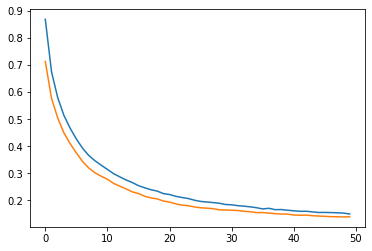

In [85]:
label_list = [tag_sequencer.idx2word[i] for i in range(len(tag_sequencer.idx2word))]

print(label_list)
train_true, train_pred, val_true, val_pred = run_training(lstm_clf, optimizer, loss_function, train_loader, val_loader, device, label_list, n_epochs=50)

In [39]:
a = [1, 2, 3]
b = [4, 5, 6]
list(zip(a,b))

[(1, 4), (2, 5), (3, 6)]

In [ ]:
non_padding_true_values = [[4, 4, 4, 4, 4, 4, 4, 5], [4, 4, 4, 6, 7], [4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 8, 9], [4, 4, 4, 4, 4, 4, 6, 7, 4], [4, 4, 4, 4, 4, 10, 4], [11, 12, 12], [4, 4, 4, 4, 11, 12, 12]]

In [ ]:
[[str(tag_sequencer.idx2word[_y]).replace('_', '-') for _y in _x] for _x in non_padding_true_values]

In [ ]:
train_true[0]

In [ ]:
train_pred[0]

In [ ]:
[len(_x) for _x in train_true[0]]

In [ ]:
[len(_x) for _x in train_pred[0]]

In [ ]:
print(classification_report(train_true[0], train_pred[0], scheme=IOB2))

In [ ]:
train_true

In [87]:
lstm_clf_state_dict = lstm_clf.state_dict()
torch.save(lstm_clf_state_dict, '/content/drive/MyDrive/NLP243/assignments/2/model/20201021/2/model.pth')

In [ ]:
# with open('/content/drive/MyDrive/NLP243/assignments/2/model/20201021/1/train_dataset.pkl', "wb") as output_file:
#     pkl.dump(train_dataset, output_file)
# with open('/content/drive/MyDrive/NLP243/assignments/2/model/20201021/1/val_dataset.pkl', "wb") as output_file:
#     pkl.dump(val_dataset, output_file)
# with open('/content/drive/MyDrive/NLP243/assignments/2/model/20201021/1/text_sequencer.pkl', "wb") as output_file:
#     pkl.dump(text_sequencer, output_file)
# with open('/content/drive/MyDrive/NLP243/assignments/2/model/20201021/1/tag_sequencer.pkl', "wb") as output_file:
#     pkl.dump(tag_sequencer, output_file)

In [88]:
test_df = pd.read_csv('/content/drive/MyDrive/NLP243/assignments/2/hw2_test.csv')
test_data = [(_text, " ".join(['O'] * len(_tag.split(' ')))) for _text, _tag in zip(test_df.UTTERANCES, test_df.UTTERANCES)]
test_dataset = TaggerDataset(test_data, text_sequencer, tag_sequencer)

# Loader iterator: which produces a list of batches
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, collate_fn=lambda batch: prepare_batch(batch, text_sequencer, tag_sequencer), shuffle=False)

In [91]:
def predictions(model, optimizer, loss_function, loader, device, labels, log_every_n=10):
    """
    Evaluate the model on a validation set
    """

    model.eval() # Run model in eval mode (disables dropout layer)

    batch_wise_true_labels = []
    batch_wise_predictions = []

    loss_history = []
    running_loss = 0.
    running_loss_history = []

    with torch.no_grad(): # Disable gradient computation - required only during training
        for i, batch in tqdm_notebook(enumerate(loader)):
            # batch[0] shape: (batch_size, input_size)

            logits = model(batch[0].to(device), batch[1]) # Run forward pass (except we don't store gradients)
            # logits shape: (batch_size, num_classes)
            
            loss = loss_function(logits.view(-1, logits.size(2)), batch[2].view(-1).to(device)) # Compute loss
            # No backprop is done during validation
            
            # Instead of using CrossEntropyLoss, you use BCEWithLogitsLoss
            # BCEWithLogitsLoss - independently calculates loss for each class
            

            loss_history.append(loss.item())

            running_loss += (loss_history[-1] - running_loss) / (i + 1) # Compute rolling average
            
            running_loss_history.append(running_loss)

            # logits : [batch_size, seq_len, num_classes] and each of the values in logits can be anything (-infinity, +infity)
            # Converts the raw outputs into probabilities for each class using softmax
            probs = F.softmax(logits, dim=-1) 
            # probs shape: (batch_size, seq_len, num_classes)
            # -1 dimension picks the last dimension in the shape of the tensor, in this case 'num_classes'
            

            # softmax vector: [[0.1, 0.2, 0.6, 0.1, 0.0], [0.9, 0.01, 0.01, 0.01, 0.07]]
            # output tensor: [2, 0]
            predictions = torch.argmax(probs, dim=-1) # Output predictions; Argmax picks the index with the highest probability among all the classes (choosing our most probable class)
            print('predictions')
            print(predictions)
            # predictions shape: (batch_size, seq_len)

            batch_wise_true_labels.append(batch[2].tolist())
            batch_wise_predictions.append(predictions.tolist())

            # batch_wise_true_labels.append(batch[2].view(-1).tolist())
            # batch_wise_predictions.append(predictions.view(-1).tolist())
    
    # flatten the list of predictions using itertools
    
    all_true_labels = batch_wise_true_labels
    all_predictions = batch_wise_predictions

    # Non padding indices
    pad_index = labels.index('<pad>')

    # non_padding_true_values = [[_batch[i] for i in range(len(_batch)) if _batch[i] != pad_index] for _batch in all_true_labels]
    # non_padding_predictions = [[_batch[i] for i in range(len(_batch)) if _batch[i] != pad_index] for _batch in all_predictions]

    non_padding_true_values = [[_x[i] for i in range(len(_x)) if _x[i] != pad_index] for _batch in all_true_labels for _x in _batch]
    non_padding_predictions = [[_x[i] for i in range(len(_x)) if _x[i] != pad_index] for _batch in all_predictions for _x in _batch]

    true_labels = [[str(tag_sequencer.idx2word[_y]).replace('_', '-') for _y in _x] for _x in non_padding_true_values]
    predicted_labels = [[str(tag_sequencer.idx2word[_y]).replace('_', '-') for _y in _x][:len(_t)] for _x, _t in zip(non_padding_predictions, true_labels)]

    return predicted_labels
    
    # all_true_labels = batch_wise_true_labels
    # all_predictions = batch_wise_predictions

    # # Non padding indices
    # pad_index = labels.index('<pad>')

    # # non_padding_labels = [all_true_labels[i] for i in range(len(all_true_labels)) if all_true_labels[i] != pad_index]
    # # non_padding_predictions = [all_predictions[i] for i in range(len(all_true_labels)) if all_true_labels[i] != pad_index]

    # non_padding_labels = [[_batch[i] for i in range(len(_batch)) if _batch[i] != pad_index] for _batch in all_true_labels]
    # non_padding_predictions = [[_batch[i] for i in range(len(_batch)) if _batch[i] != pad_index] for _batch in all_predictions]

    # return non_padding_labels, non_padding_predictions

In [92]:
predicted_labels = predictions(lstm_clf, optimizer, loss_function, test_loader, device, label_list)

0it [00:00, ?it/s]

predictions
tensor([[11,  4, 11]], device='cuda:0')
predictions
tensor([[ 4,  4,  4,  4,  4, 11, 12]], device='cuda:0')
predictions
tensor([[ 4,  4,  4,  4,  4,  4, 11, 12]], device='cuda:0')
predictions
tensor([[ 4,  4,  4, 11]], device='cuda:0')
predictions
tensor([[ 4,  4,  4, 11]], device='cuda:0')
predictions
tensor([[ 4,  4, 11]], device='cuda:0')
predictions
tensor([[ 4,  4,  4, 11,  4, 11]], device='cuda:0')
predictions
tensor([[ 4,  4,  4, 11,  4, 11, 12]], device='cuda:0')
predictions
tensor([[ 4,  4,  4,  4, 11, 12]], device='cuda:0')
predictions
tensor([[ 4,  4,  4,  4, 11, 12]], device='cuda:0')
predictions
tensor([[ 4,  4, 11, 12, 12, 12]], device='cuda:0')
predictions
tensor([[ 4,  4,  4, 11, 12]], device='cuda:0')
predictions
tensor([[ 4,  4,  4, 12, 12,  4]], device='cuda:0')
predictions
tensor([[ 4,  4,  4,  4,  4,  4,  4,  4,  4, 11, 12]], device='cuda:0')
predictions
tensor([[ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 11, 12]],
       device='cuda:0')
p

In [93]:
labels = [" ".join(_x) for _x in predicted_labels]

In [94]:
labels

['B-movie O B-movie',
 'O O O O O B-movie I-movie',
 'O O O O O O B-movie I-movie',
 'O O O B-movie',
 'O O O B-movie',
 'O O B-movie',
 'O O O B-movie O B-movie',
 'O O O B-movie O B-movie I-movie',
 'O O O O B-movie I-movie',
 'O O O O B-movie I-movie',
 'O O B-movie I-movie I-movie I-movie',
 'O O O B-movie I-movie',
 'O O O I-movie I-movie O',
 'O O O O O O O O O B-movie I-movie',
 'O O O O O O O O O O O O O O B-movie I-movie',
 'O O O B-movie I-movie',
 'O O B-movie I-movie',
 'O O O',
 'O O O O O B-movie I-movie',
 'B-movie I-movie O',
 'O O O O O O B-movie I-movie',
 'O O O B-movie',
 'O O O O O O B-movie',
 'B-movie O B-movie I-movie I-movie',
 'O O O O',
 'O O O O O O O',
 'O O O',
 'O O O B-movie',
 'B-movie O B-movie I-movie',
 'O O O O O O O O B-movie',
 'O O O O O O O O B-movie',
 'O O O O O O B-movie',
 'O O O O O O O B-movie I-movie',
 'O O O O O O O O B-movie I-movie',
 'O O O O O O O B-movie I-movie',
 'O O B-movie I-movie',
 'O O O O O B-movie I-movie',
 'O O B-movie'

In [95]:
submission_df = pd.DataFrame(columns=['ID', 'IOB Slot tags'], data={'ID': list(test_df.ID), 'IOB Slot tags': labels})
submission_df.to_csv('/content/drive/MyDrive/NLP243/assignments/2/model/20201021/2/submission.csv', index=False)

In [ ]:
print("done")

In [ ]:
pass